# V&V maternal outcomes and intervention coverage

## Setup

In [1]:
import pandas as pd, numpy as np, os
from vivarium import Artifact
import db_queries
from get_draws.api import get_draws
import matplotlib.pyplot as plt
from pathlib import Path
import yaml

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning) 

In [3]:
locations = ['Pakistan', 'Ethiopia', 'Nigeria']

In [4]:
# Parameters cell for papermill
model_dir = "model28.0"

In [5]:
# Parameters
model_dir = "model28.0"


In [6]:
base_results_dir = Path("/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/results/") / model_dir

In [7]:
results_dirs = {}
assert set([p.stem for p in base_results_dir.iterdir()]) == set([l.lower() for l in locations])
for location in locations:
    location_dir = base_results_dir / location.lower()
    timestamps = sorted(location_dir.iterdir())
    last_timestamp = timestamps[-1]
    if len(timestamps) > 1:
        print(f'Multiple timestamps: {timestamps}, using {last_timestamp}')
    results_dirs[location] = location_dir / last_timestamp / 'results'

results_dirs

{'Pakistan': PosixPath('/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/results/model28.0/pakistan/2026_01_22_10_48_48/results'),
 'Ethiopia': PosixPath('/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/results/model28.0/ethiopia/2026_01_22_10_43_03/results'),
 'Nigeria': PosixPath('/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/results/model28.0/nigeria/2026_01_22_10_46_09/results')}

In [8]:
location_ids = db_queries.get_ids('location')
location_ids = location_ids.loc[location_ids.location_name.str.lower().isin([x.lower() for x in results_dirs.keys()])]
location_ids

location_id location_name location_type location_description
139          165      Pakistan        admin0               admin0
150          179      Ethiopia        admin0               admin0
183          214       Nigeria        admin0               admin0

In [9]:
def load_yaml_file(path):
    with open(path) as stream:
        return yaml.safe_load(stream)

In [10]:
artifact_paths = {
    location: load_yaml_file(result_dir.parent / 'model_specification.yaml')['configuration']['input_data']['artifact_path']
    for location, result_dir
    in results_dirs.items()
}
artifact_paths

{'Pakistan': '/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model28.0/pakistan.hdf',
 'Ethiopia': '/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model28.0/ethiopia.hdf',
 'Nigeria': '/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model28.0/nigeria.hdf'}

In [11]:
def read_results(result_file_name, baseline_only=True):
    all_locations_results = []
    for location, result_dir in results_dirs.items():
        if baseline_only:
           filters = [('scenario', '==', 'baseline')]
           location_results = pd.read_parquet(result_dir / f'{result_file_name}.parquet', filters=filters).drop(columns=['measure','entity','sub_entity','entity_type'])
        else:
            location_results = pd.read_parquet(result_dir / f'{result_file_name}.parquet').drop(columns=['measure','entity','sub_entity','entity_type'])
        location_results['location'] = location
        #if 'scenario' not in location_results.columns:
        #    location_results['scenario'] = 'baseline'
        #if baseline_only:
        #    location_results = location_results.loc[location_results.scenario == 'baseline']

        # Aggregate over random seeds (if necessary)
        # TODO: Could use vivarium_helpers marginalize method here
        if 'random_seed' in location_results.columns:
            location_results = location_results.groupby([
                c for c in location_results.columns if c != 'random_seed' and c != 'value'
            ]).sum().reset_index().drop(columns='random_seed')

        all_locations_results.append(location_results)
    return pd.concat(all_locations_results, ignore_index=True)

In [12]:
causes = [
    'maternal_sepsis_and_other_maternal_infections',
    'maternal_hemorrhage',
    'maternal_obstructed_labor_and_uterine_rupture',
    'postpartum_depression',
]

In [13]:
def combine_count_results_by_cause(measure, results_file_suffix=None, baseline_only=True):
    if results_file_suffix is None:
        results_file_suffix = measure

    all_causes_results = []

    for cause in causes:
        cause_results = read_results(f'{cause}_{results_file_suffix}', baseline_only=baseline_only)
        if baseline_only:
            cause_results = cause_results.drop(columns=['scenario'])
        cause_results['cause'] = cause
        cause_results['measure'] = measure
        all_causes_results.append(cause_results)

    return pd.concat(all_causes_results, ignore_index=True)

## Verify burden

In [14]:
incidence = combine_count_results_by_cause('incidence', 'counts')
incidence

age_group  azithromycin_availability delivery_facility_type  \
0       10_to_14                      False                 BEmONC   
1       10_to_14                      False                 BEmONC   
2       10_to_14                      False                 BEmONC   
3       10_to_14                      False                 BEmONC   
4       10_to_14                      False                 BEmONC   
...          ...                        ...                    ...   
103675   95_plus                       True                   none   
103676   95_plus                       True                   none   
103677   95_plus                       True                   none   
103678   95_plus                       True                   none   
103679   95_plus                       True                   none   

        misoprostol_availability pregnancy_outcome  input_draw  location  \
0                          False        live_birth          22  Pakistan   
1                          False        live_birth          60  Pakistan   
2                          False        live_birth          71  Pakistan   
3                          False        live_birth          79  Pakistan   
4                          False        live_birth         115  Pakistan   
...                          ...               ...         ...       ...   
103675                      True        stillbirth         118   Nigeria   
103676                      True        stillbirth         146   Nigeria   
103677                      True        stillbirth         167   Nigeria   
103678                      True        stillbirth         197   Nigeria   
103679                      True        stillbirth         244   Nigeria   

        value                                          cause    measure  
0        10.0  maternal_sepsis_and_other_maternal_infections  incidence  
1        17.0  maternal_sepsis_and_other_maternal_infections  incidence  
2        25.0  maternal_sepsis_and_other_maternal_infections  incidence  
3        24.0  maternal_sepsis_and_other_maternal_infections  incidence  
4        21.0  maternal_sepsis_and_other_maternal_infections  incidence  
...       ...                                            ...        ...  
103675    0.0                          postpartum_depression  incidence  
103676    0.0                          postpartum_depression  incidence  
103677    0.0                          postpartum_depression  incidence  
103678    0.0                          postpartum_depression  incidence  
103679    0.0                          postpartum_depression  incidence  

[103680 rows x 10 columns]

In [15]:
ylds = combine_count_results_by_cause('ylds')
ylds

age_group  azithromycin_availability delivery_facility_type  \
0       10_to_14                      False                 BEmONC   
1       10_to_14                      False                 BEmONC   
2       10_to_14                      False                 BEmONC   
3       10_to_14                      False                 BEmONC   
4       10_to_14                      False                 BEmONC   
...          ...                        ...                    ...   
103675   95_plus                       True                   none   
103676   95_plus                       True                   none   
103677   95_plus                       True                   none   
103678   95_plus                       True                   none   
103679   95_plus                       True                   none   

        misoprostol_availability pregnancy_outcome  input_draw  location  \
0                          False        live_birth          22  Pakistan   
1                          False        live_birth          60  Pakistan   
2                          False        live_birth          71  Pakistan   
3                          False        live_birth          79  Pakistan   
4                          False        live_birth         115  Pakistan   
...                          ...               ...         ...       ...   
103675                      True        stillbirth         118   Nigeria   
103676                      True        stillbirth         146   Nigeria   
103677                      True        stillbirth         167   Nigeria   
103678                      True        stillbirth         197   Nigeria   
103679                      True        stillbirth         244   Nigeria   

           value                                          cause measure  
0       0.075965  maternal_sepsis_and_other_maternal_infections    ylds  
1       0.084314  maternal_sepsis_and_other_maternal_infections    ylds  
2       0.136485  maternal_sepsis_and_other_maternal_infections    ylds  
3       0.075288  maternal_sepsis_and_other_maternal_infections    ylds  
4       0.090697  maternal_sepsis_and_other_maternal_infections    ylds  
...          ...                                            ...     ...  
103675  0.000000                          postpartum_depression    ylds  
103676  0.000000                          postpartum_depression    ylds  
103677  0.000000                          postpartum_depression    ylds  
103678  0.000000                          postpartum_depression    ylds  
103679  0.000000                          postpartum_depression    ylds  

[103680 rows x 10 columns]

In [16]:
deaths = (read_results('maternal_disorders_burden_observer_disorder_deaths', baseline_only=True).drop(columns=['scenario'])
          .rename(columns={'maternal_disorders_burden_observer_cause_of_death':'cause'}))
deaths['measure'] = 'mortality'
deaths

age_group  azithromycin_availability delivery_facility_type  \
0       10_to_14                      False                 BEmONC   
1       10_to_14                      False                 BEmONC   
2       10_to_14                      False                 BEmONC   
3       10_to_14                      False                 BEmONC   
4       10_to_14                      False                 BEmONC   
...          ...                        ...                    ...   
129595   95_plus                       True                   none   
129596   95_plus                       True                   none   
129597   95_plus                       True                   none   
129598   95_plus                       True                   none   
129599   95_plus                       True                   none   

                                         cause  misoprostol_availability  \
0       abortion_miscarriage_ectopic_pregnancy                     False   
1       abortion_miscarriage_ectopic_pregnancy                     False   
2       abortion_miscarriage_ectopic_pregnancy                     False   
3       abortion_miscarriage_ectopic_pregnancy                     False   
4       abortion_miscarriage_ectopic_pregnancy                     False   
...                                        ...                       ...   
129595             residual_maternal_disorders                      True   
129596             residual_maternal_disorders                      True   
129597             residual_maternal_disorders                      True   
129598             residual_maternal_disorders                      True   
129599             residual_maternal_disorders                      True   

       pregnancy_outcome  input_draw  location  value    measure  
0             live_birth          22  Pakistan    0.0  mortality  
1             live_birth          60  Pakistan    0.0  mortality  
2             live_birth          71  Pakistan    0.0  mortality  
3             live_birth          79  Pakistan    0.0  mortality  
4             live_birth         115  Pakistan    0.0  mortality  
...                  ...         ...       ...    ...        ...  
129595        stillbirth         118   Nigeria    0.0  mortality  
129596        stillbirth         146   Nigeria    0.0  mortality  
129597        stillbirth         167   Nigeria    0.0  mortality  
129598        stillbirth         197   Nigeria    0.0  mortality  
129599        stillbirth         244   Nigeria    0.0  mortality  

[129600 rows x 10 columns]

In [17]:
deaths.cause.unique()

['abortion_miscarriage_ectopic_pregnancy', 'maternal_hemorrhage', 'maternal_obstructed_labor_and_uterine_rupture', 'maternal_sepsis_and_other_maternal_infections', 'residual_maternal_disorders']
Categories (5, object): ['abortion_miscarriage_ectopic_pregnancy', 'maternal_hemorrhage', 'maternal_obstructed_labor_and_uterine_rupture', 'maternal_sepsis_and_other_maternal_infections', 'residual_maternal_disorders']

In [18]:
births = read_results('anc_other', baseline_only=True).drop(columns=['scenario'])
births

acs_availability  acs_eligibility age_group  \
0                   False            False  10_to_14   
1                   False            False  10_to_14   
2                   False            False  10_to_14   
3                   False            False  10_to_14   
4                   False            False  10_to_14   
...                   ...              ...       ...   
4976635              True             True   95_plus   
4976636              True             True   95_plus   
4976637              True             True   95_plus   
4976638              True             True   95_plus   
4976639              True             True   95_plus   

                                anc_coverage  azithromycin_availability  \
0        first_trimester_and_later_pregnancy                      False   
1        first_trimester_and_later_pregnancy                      False   
2        first_trimester_and_later_pregnancy                      False   
3        first_trimester_and_later_pregnancy                      False   
4        first_trimester_and_later_pregnancy                      False   
...                                      ...                        ...   
4976635                                 none                       True   
4976636                                 none                       True   
4976637                                 none                       True   
4976638                                 none                       True   
4976639                                 none                       True   

         believed_preterm delivery_facility_type  misoprostol_availability  \
0                   False                 BEmONC                     False   
1                   False                 BEmONC                     False   
2                   False                 BEmONC                     False   
3                   False                 BEmONC                     False   
4                   False                 BEmONC                     False   
...                   ...                    ...                       ...   
4976635              True                   none                      True   
4976636              True                   none                      True   
4976637              True                   none                      True   
4976638              True                   none                      True   
4976639              True                   none                      True   

        pregnancy_outcome  preterm_birth ultrasound_type  input_draw  \
0              live_birth          False     AI_assisted          22   
1              live_birth          False     AI_assisted          60   
2              live_birth          False     AI_assisted          71   
3              live_birth          False     AI_assisted          79   
4              live_birth          False     AI_assisted         115   
...                   ...            ...             ...         ...   
4976635        stillbirth           True        standard         118   
4976636        stillbirth           True        standard         146   
4976637        stillbirth           True        standard         167   
4976638        stillbirth           True        standard         197   
4976639        stillbirth           True        standard         244   

         location  value  
0        Pakistan    0.0  
1        Pakistan    0.0  
2        Pakistan    0.0  
3        Pakistan    0.0  
4        Pakistan    0.0  
...           ...    ...  
4976635   Nigeria    0.0  
4976636   Nigeria    0.0  
4976637   Nigeria    0.0  
4976638   Nigeria    0.0  
4976639   Nigeria    0.0  

[4976640 rows x 14 columns]

In [19]:
population_stratification_cols = [x for x in births.columns if x in deaths.columns and x != 'value']
postpartum_population = (
    births.groupby(population_stratification_cols).value.sum()
    - deaths.groupby(population_stratification_cols).value.sum()
).reset_index()
postpartum_population

age_group  azithromycin_availability delivery_facility_type  \
0      10_to_14                      False                 BEmONC   
1      10_to_14                      False                 BEmONC   
2      10_to_14                      False                 BEmONC   
3      10_to_14                      False                 BEmONC   
4      10_to_14                      False                 BEmONC   
...         ...                        ...                    ...   
25915   95_plus                       True                   none   
25916   95_plus                       True                   none   
25917   95_plus                       True                   none   
25918   95_plus                       True                   none   
25919   95_plus                       True                   none   

       misoprostol_availability pregnancy_outcome  input_draw  location  value  
0                         False        live_birth          22  Ethiopia   74.0  
1                         False        live_birth          22   Nigeria  235.0  
2                         False        live_birth          22  Pakistan  235.0  
3                         False        live_birth          60  Ethiopia  113.0  
4                         False        live_birth          60   Nigeria  444.0  
...                         ...               ...         ...       ...    ...  
25915                      True        stillbirth         197   Nigeria    0.0  
25916                      True        stillbirth         197  Pakistan    0.0  
25917                      True        stillbirth         244  Ethiopia    0.0  
25918                      True        stillbirth         244   Nigeria    0.0  
25919                      True        stillbirth         244  Pakistan    0.0  

[25920 rows x 8 columns]

In [20]:
count_results = pd.concat([incidence, deaths, ylds], ignore_index=True)
count_results.cause.unique()

array(['maternal_sepsis_and_other_maternal_infections',
       'maternal_hemorrhage',
       'maternal_obstructed_labor_and_uterine_rupture',
       'postpartum_depression', 'abortion_miscarriage_ectopic_pregnancy',
       'residual_maternal_disorders'], dtype=object)

In [21]:
groupby_cols = ['location','input_draw','age_group']
# Postpartum causes use the postpartum population as a denominator
# All other causes use births
postpartum_causes = ['postpartum_depression']

grouped_counts = count_results.groupby(groupby_cols + ['cause', 'measure'])['value'].sum()

assert grouped_counts.notnull().all()

rate_results = pd.concat([
    grouped_counts[~grouped_counts.index.get_level_values('cause').isin(postpartum_causes)]
        / births.groupby(groupby_cols)['value'].sum(),
    grouped_counts[grouped_counts.index.get_level_values('cause').isin(postpartum_causes)]
        / postpartum_population.groupby(groupby_cols)['value'].sum(),
]).reset_index()
# Drop where denominator was zero
rate_results = rate_results.dropna(subset='value')
rate_results

location  input_draw age_group                                   cause  \
0     Ethiopia          22  10_to_14  abortion_miscarriage_ectopic_pregnancy   
1     Ethiopia          22  10_to_14  abortion_miscarriage_ectopic_pregnancy   
2     Ethiopia          22  10_to_14  abortion_miscarriage_ectopic_pregnancy   
3     Ethiopia          22  10_to_14                     maternal_hemorrhage   
4     Ethiopia          22  10_to_14                     maternal_hemorrhage   
...        ...         ...       ...                                     ...   
9688  Pakistan         244  45_to_49                   postpartum_depression   
9689  Pakistan         244  45_to_49                   postpartum_depression   
9690  Pakistan         244  50_to_54                   postpartum_depression   
9691  Pakistan         244  50_to_54                   postpartum_depression   
9692  Pakistan         244  50_to_54                   postpartum_depression   

        measure     value  
0     incidence  0.000000  
1     mortality  0.000000  
2          ylds  0.000000  
3     incidence  0.144737  
4     mortality  0.000000  
...         ...       ...  
9688  mortality  0.000000  
9689       ylds  0.012316  
9690  incidence  0.083916  
9691  mortality  0.000000  
9692       ylds  0.008467  

[4860 rows x 6 columns]

In [22]:
draws = list(deaths.input_draw.unique())
draws

[22, 60, 71, 79, 115, 118, 146, 167, 197, 244]

In [23]:
def read_artifact(key, filter_terms=['sex == Female' , 'age_start > 5', 'age_end < 60']):
    all_locations_data = []
    for location in locations:
        art = Artifact(artifact_paths[location], filter_terms=filter_terms)
        location_data = art.load(key)
        if not isinstance(location_data, pd.DataFrame):
            location_data = pd.DataFrame({'value': location_data, 'location': location}, index=[0]).set_index('location')
        else:
            location_data['location'] = location
            location_data = location_data.reset_index().set_index(['location'] + [c for c in location_data.index.names if c is not None])
        all_locations_data.append(location_data)

    all_locations_data = pd.concat(all_locations_data)
    if 'draw' in all_locations_data.columns[0]:
        all_locations_data = all_locations_data[[f'draw_{draw}' for draw in draws]]
    else:
        for draw in draws:
            all_locations_data[f'draw_{draw}'] = all_locations_data['value']
        all_locations_data = all_locations_data.drop(columns='value')
    return all_locations_data

In [24]:
asfr = read_artifact('covariate.age_specific_fertility_rate.estimate')
sbr = read_artifact('covariate.stillbirth_24_weeks_to_live_birth_ratio.estimate')
still = asfr * sbr
ectopic = read_artifact('cause.ectopic_pregnancy.raw_incidence_rate')
miscarriage = read_artifact('cause.maternal_abortion_and_miscarriage.raw_incidence_rate')

pregnancy_incidence = (asfr
                       + still
                       + ectopic
                       + miscarriage)

# TODO: check to see if "pregnancy_incidence" is a key in the artifact that I can use directly

asfr['outcome'] = 'live_birth'
still['outcome'] = 'stillbirth'
# FIXME: update these to "abortion/miscarriage/ectopic" rather than "partial term" which we have moved away from in docs
ectopic['outcome'] = 'partial_term'
miscarriage['outcome'] = 'partial_term'
artifact_birth_outcomes = pd.concat([
    asfr,
    still.reorder_levels(asfr.index.names),
    ectopic.reorder_levels(asfr.index.names),
    miscarriage.reorder_levels(asfr.index.names),
]).set_index('outcome', append=True)
artifact_birth_outcomes = (artifact_birth_outcomes / pregnancy_incidence).groupby(artifact_birth_outcomes.index.names).sum()

artifact_birth_outcomes

draw_22  \
location sex    age_start age_end year_start year_end outcome                  
Ethiopia Female 10.0      15.0    2023       2024     live_birth    0.352333   
                                                      partial_term  0.638147   
                                                      stillbirth    0.009520   
                15.0      20.0    2023       2024     live_birth    0.439290   
                                                      partial_term  0.548840   
...                                                                      ...   
Pakistan Female 45.0      50.0    2023       2024     partial_term  0.387485   
                                                      stillbirth    0.023314   
                50.0      55.0    2023       2024     live_birth    0.529497   
                                                      partial_term  0.449551   
                                                      stillbirth    0.020952   

                                                                     draw_60  \
location sex    age_start age_end year_start year_end outcome                  
Ethiopia Female 10.0      15.0    2023       2024     live_birth    0.483888   
                                                      partial_term  0.502343   
                                                      stillbirth    0.013768   
                15.0      20.0    2023       2024     live_birth    0.520200   
                                                      partial_term  0.464999   
...                                                                      ...   
Pakistan Female 45.0      50.0    2023       2024     partial_term  0.198012   
                                                      stillbirth    0.032167   
                50.0      55.0    2023       2024     live_birth    0.608004   
                                                      partial_term  0.366590   
                                                      stillbirth    0.025406   

                                                                     draw_71  \
location sex    age_start age_end year_start year_end outcome                  
Ethiopia Female 10.0      15.0    2023       2024     live_birth    0.351738   
                                                      partial_term  0.635668   
                                                      stillbirth    0.012594   
                15.0      20.0    2023       2024     live_birth    0.468258   
                                                      partial_term  0.514976   
...                                                                      ...   
Pakistan Female 45.0      50.0    2023       2024     partial_term  0.301912   
                                                      stillbirth    0.035227   
                50.0      55.0    2023       2024     live_birth    0.507084   
                                                      partial_term  0.465968   
                                                      stillbirth    0.026949   

                                                                     draw_79  \
location sex    age_start age_end year_start year_end outcome                  
Ethiopia Female 10.0      15.0    2023       2024     live_birth    0.581578   
                                                      partial_term  0.396024   
                                                      stillbirth    0.022398   
                15.0      20.0    2023       2024     live_birth    0.457699   
                                                      partial_term  0.524674   
...                                                                      ...   
Pakistan Female 45.0      50.0    2023       2024     partial_term  0.246542   
                                                      stillbirth    0.040851   
                50.0      55.0    2023       2024     live_birth    0.570720   
                                                      partial_term

In [25]:
postpartum_depression_severity_split = Artifact(artifact_paths['Ethiopia']).load('cause.postpartum_depression.case_severity')

for location in locations:
    assert postpartum_depression_severity_split == Artifact(artifact_paths[location]).load('cause.postpartum_depression.case_severity')

postpartum_depression_severity_split

{'asymptomatic': 0.14, 'mild': 0.59, 'moderate': 0.17, 'severe': 0.1}

In [26]:
postpartum_depression_severity_split = pd.DataFrame({
    'postpartum_depression_case_type': postpartum_depression_severity_split.keys(),
    **{
        f'draw_{draw}': postpartum_depression_severity_split.values()
        for draw in draws
    }
}).set_index('postpartum_depression_case_type')
postpartum_depression_severity_split

draw_22  draw_60  draw_71  draw_79  draw_115  \
postpartum_depression_case_type                                                 
asymptomatic                        0.14     0.14     0.14     0.14      0.14   
mild                                0.59     0.59     0.59     0.59      0.59   
moderate                            0.17     0.17     0.17     0.17      0.17   
severe                              0.10     0.10     0.10     0.10      0.10   

                                 draw_118  draw_146  draw_167  draw_197  \
postpartum_depression_case_type                                           
asymptomatic                         0.14      0.14      0.14      0.14   
mild                                 0.59      0.59      0.59      0.59   
moderate                             0.17      0.17      0.17      0.17   
severe                               0.10      0.10      0.10      0.10   

                                 draw_244  
postpartum_depression_case_type            
asymptomatic                         0.14  
mild                                 0.59  
moderate                             0.17  
severe                               0.10

In [27]:
postpartum_depression_duration = read_artifact('cause.postpartum_depression.case_duration')
postpartum_depression_duration

draw_22  draw_60  \
location sex    age_start age_end year_start year_end                      
Pakistan Female 10.0      15.0    2023       2024      0.653662  0.69536   
                15.0      20.0    2023       2024      0.653662  0.69536   
                20.0      25.0    2023       2024      0.653662  0.69536   
                25.0      30.0    2023       2024      0.653662  0.69536   
                30.0      35.0    2023       2024      0.653662  0.69536   
                35.0      40.0    2023       2024      0.653662  0.69536   
                40.0      45.0    2023       2024      0.653662  0.69536   
                45.0      50.0    2023       2024      0.653662  0.69536   
                50.0      55.0    2023       2024      0.653662  0.69536   
Ethiopia Female 10.0      15.0    2023       2024      0.653662  0.69536   
                15.0      20.0    2023       2024      0.653662  0.69536   
                20.0      25.0    2023       2024      0.653662  0.69536   
                25.0      30.0    2023       2024      0.653662  0.69536   
                30.0      35.0    2023       2024      0.653662  0.69536   
                35.0      40.0    2023       2024      0.653662  0.69536   
                40.0      45.0    2023       2024      0.653662  0.69536   
                45.0      50.0    2023       2024      0.653662  0.69536   
                50.0      55.0    2023       2024      0.653662  0.69536   
Nigeria  Female 10.0      15.0    2023       2024      0.653662  0.69536   
                15.0      20.0    2023       2024      0.653662  0.69536   
                20.0      25.0    2023       2024      0.653662  0.69536   
                25.0      30.0    2023       2024      0.653662  0.69536   
                30.0      35.0    2023       2024      0.653662  0.69536   
                35.0      40.0    2023       2024      0.653662  0.69536   
                40.0      45.0    2023       2024      0.653662  0.69536   
                45.0      50.0    2023       2024      0.653662  0.69536   
                50.0      55.0    2023       2024      0.653662  0.69536   

                                                        draw_71  draw_79  \
location sex    age_start age_end year_start year_end                      
Pakistan Female 10.0      15.0    2023       2024      0.670808  0.63045   
                15.0      20.0    2023       2024      0.670808  0.63045   
                20.0      25.0    2023       2024      0.670808  0.63045   
                25.0      30.0    2023       2024      0.670808  0.63045   
                30.0      35.0    2023       2024      0.670808  0.63045   
                35.0      40.0    2023       2024      0.670808  0.63045   
                40.0      45.0    2023       2024      0.670808  0.63045   
                45.0      50.0    2023       2024      0.670808  0.63045   
                50.0      55.0    2023       2024      0.670808  0.63045   
Ethiopia Female 10.0      15.0    2023       2024      0.670808  0.63045   
                15.0      20.0    2023       2024      0.670808  0.63045   
                20.0      25.0    2023       2024      0.670808  0.63045   
                25.0      30.0    2023       2024      0.670808  0.63045   
                30.0      35.0    2023       2024      0.670808  0.63045   
                35.0      40.0    2023       2024      0.670808  0.63045   
                40.0      45.0    2023       2024      0.670808  0.63045   
                45.0      50.0    2023       2024      0.670808  0.63045   
                50.0      55.0    2023       2024      0.670808  0.63045   
Nigeria  Female 10.0      15.0    2023       2024      0.670808  0.63045   
                15.0      20.0    2023       2024      0.670808  0.63045   
                20.0      25.0    2023       2024      0.670808  0.63045   
                25.0      30.0    2023       2024      0.670808  0.63045   
                30.0      3

In [28]:
postpartum_depression_disability_weights = read_artifact('cause.postpartum_depression.disability_weight')
postpartum_depression_disability_weights

draw_22  \
location sex    age_start age_end year_start year_end postpartum_depression_case_type             
Pakistan Female 10.0      15.0    2023       2024     asymptomatic                     0.000000   
                15.0      20.0    2023       2024     asymptomatic                     0.000000   
                20.0      25.0    2023       2024     asymptomatic                     0.000000   
                25.0      30.0    2023       2024     asymptomatic                     0.000000   
                30.0      35.0    2023       2024     asymptomatic                     0.000000   
...                                                                                         ...   
Nigeria  Female 30.0      35.0    2023       2024     severe                           0.737733   
                35.0      40.0    2023       2024     severe                           0.737733   
                40.0      45.0    2023       2024     severe                           0.737733   
                45.0      50.0    2023       2024     severe                           0.737733   
                50.0      55.0    2023       2024     severe                           0.737733   

                                                                                        draw_60  \
location sex    age_start age_end year_start year_end postpartum_depression_case_type             
Pakistan Female 10.0      15.0    2023       2024     asymptomatic                     0.000000   
                15.0      20.0    2023       2024     asymptomatic                     0.000000   
                20.0      25.0    2023       2024     asymptomatic                     0.000000   
                25.0      30.0    2023       2024     asymptomatic                     0.000000   
                30.0      35.0    2023       2024     asymptomatic                     0.000000   
...                                                                                         ...   
Nigeria  Female 30.0      35.0    2023       2024     severe                           0.545422   
                35.0      40.0    2023       2024     severe                           0.545422   
                40.0      45.0    2023       2024     severe                           0.545422   
                45.0      50.0    2023       2024     severe                           0.545422   
                50.0      55.0    2023       2024     severe                           0.545422   

                                                                                        draw_71  \
location sex    age_start age_end year_start year_end postpartum_depression_case_type             
Pakistan Female 10.0      15.0    2023       2024     asymptomatic                     0.000000   
                15.0      20.0    2023       2024     asymptomatic                     0.000000   
                20.0      25.0    2023       2024     asymptomatic                     0.000000   
                25.0      30.0    2023       2024     asymptomatic                     0.000000   
                30.0      35.0    2023       2024     asymptomatic                     0.000000   
...                                                                                         ...   
Nigeria  Female 30.0      35.0    2023       2024     severe                           0.674509   
                35.0      40.0    2023       2024     severe                           0.674509   
                40.0      45.0    2023       2024     severe                           0.674509   
                45.0      50.0    2023       2024     severe                           0.674509   
                50.0      55.0    2023       2024     severe                           0.674509   

                                                                                        draw_79  \
location sex    age_start age_end year_start year_end postpartum_depression_case_type             
Pakistan Female 10.0      

In [29]:
postpartum_depression_incidence_risk = read_artifact('cause.postpartum_depression.incidence_risk')
postpartum_depression_incidence_risk

draw_22   draw_60  \
location sex    age_start age_end year_start year_end                      
Pakistan Female 10.0      15.0    2023       2024      0.11702  0.146247   
                15.0      20.0    2023       2024      0.11702  0.146247   
                20.0      25.0    2023       2024      0.11702  0.146247   
                25.0      30.0    2023       2024      0.11702  0.146247   
                30.0      35.0    2023       2024      0.11702  0.146247   
                35.0      40.0    2023       2024      0.11702  0.146247   
                40.0      45.0    2023       2024      0.11702  0.146247   
                45.0      50.0    2023       2024      0.11702  0.146247   
                50.0      55.0    2023       2024      0.11702  0.146247   
Ethiopia Female 10.0      15.0    2023       2024      0.11702  0.146247   
                15.0      20.0    2023       2024      0.11702  0.146247   
                20.0      25.0    2023       2024      0.11702  0.146247   
                25.0      30.0    2023       2024      0.11702  0.146247   
                30.0      35.0    2023       2024      0.11702  0.146247   
                35.0      40.0    2023       2024      0.11702  0.146247   
                40.0      45.0    2023       2024      0.11702  0.146247   
                45.0      50.0    2023       2024      0.11702  0.146247   
                50.0      55.0    2023       2024      0.11702  0.146247   
Nigeria  Female 10.0      15.0    2023       2024      0.11702  0.146247   
                15.0      20.0    2023       2024      0.11702  0.146247   
                20.0      25.0    2023       2024      0.11702  0.146247   
                25.0      30.0    2023       2024      0.11702  0.146247   
                30.0      35.0    2023       2024      0.11702  0.146247   
                35.0      40.0    2023       2024      0.11702  0.146247   
                40.0      45.0    2023       2024      0.11702  0.146247   
                45.0      50.0    2023       2024      0.11702  0.146247   
                50.0      55.0    2023       2024      0.11702  0.146247   

                                                        draw_71  draw_79  \
location sex    age_start age_end year_start year_end                      
Pakistan Female 10.0      15.0    2023       2024      0.088141  0.11719   
                15.0      20.0    2023       2024      0.088141  0.11719   
                20.0      25.0    2023       2024      0.088141  0.11719   
                25.0      30.0    2023       2024      0.088141  0.11719   
                30.0      35.0    2023       2024      0.088141  0.11719   
                35.0      40.0    2023       2024      0.088141  0.11719   
                40.0      45.0    2023       2024      0.088141  0.11719   
                45.0      50.0    2023       2024      0.088141  0.11719   
                50.0      55.0    2023       2024      0.088141  0.11719   
Ethiopia Female 10.0      15.0    2023       2024      0.088141  0.11719   
                15.0      20.0    2023       2024      0.088141  0.11719   
                20.0      25.0    2023       2024      0.088141  0.11719   
                25.0      30.0    2023       2024      0.088141  0.11719   
                30.0      35.0    2023       2024      0.088141  0.11719   
                35.0      40.0    2023       2024      0.088141  0.11719   
                40.0      45.0    2023       2024      0.088141  0.11719   
                45.0      50.0    2023       2024      0.088141  0.11719   
                50.0      55.0    2023       2024      0.088141  0.11719   
Nigeria  Female 10.0      15.0    2023       2024      0.088141  0.11719   
                15.0      20.0    2023       2024      0.088141  0.11719   
                20.0      25.0    2023       2024      0.088141  0.11719   
                25.0      30.0    2023       2024      0.088141  0.11719   
                30.0      

In [30]:
postpartum_depression_ylds_per_case = (
    postpartum_depression_severity_split * postpartum_depression_disability_weights * postpartum_depression_duration
).groupby(postpartum_depression_duration.index.names).sum()
postpartum_depression_ylds_per_case

draw_22   draw_60  \
location sex    age_start age_end year_start year_end                       
Ethiopia Female 10.0      15.0    2023       2024      0.141829  0.156319   
                15.0      20.0    2023       2024      0.141829  0.156319   
                20.0      25.0    2023       2024      0.141829  0.156319   
                25.0      30.0    2023       2024      0.141829  0.156319   
                30.0      35.0    2023       2024      0.141829  0.156319   
                35.0      40.0    2023       2024      0.141829  0.156319   
                40.0      45.0    2023       2024      0.141829  0.156319   
                45.0      50.0    2023       2024      0.141829  0.156319   
                50.0      55.0    2023       2024      0.141829  0.156319   
Nigeria  Female 10.0      15.0    2023       2024      0.141829  0.156319   
                15.0      20.0    2023       2024      0.141829  0.156319   
                20.0      25.0    2023       2024      0.141829  0.156319   
                25.0      30.0    2023       2024      0.141829  0.156319   
                30.0      35.0    2023       2024      0.141829  0.156319   
                35.0      40.0    2023       2024      0.141829  0.156319   
                40.0      45.0    2023       2024      0.141829  0.156319   
                45.0      50.0    2023       2024      0.141829  0.156319   
                50.0      55.0    2023       2024      0.141829  0.156319   
Pakistan Female 10.0      15.0    2023       2024      0.141829  0.156319   
                15.0      20.0    2023       2024      0.141829  0.156319   
                20.0      25.0    2023       2024      0.141829  0.156319   
                25.0      30.0    2023       2024      0.141829  0.156319   
                30.0      35.0    2023       2024      0.141829  0.156319   
                35.0      40.0    2023       2024      0.141829  0.156319   
                40.0      45.0    2023       2024      0.141829  0.156319   
                45.0      50.0    2023       2024      0.141829  0.156319   
                50.0      55.0    2023       2024      0.141829  0.156319   

                                                        draw_71   draw_79  \
location sex    age_start age_end year_start year_end                       
Ethiopia Female 10.0      15.0    2023       2024      0.162143  0.161599   
                15.0      20.0    2023       2024      0.162143  0.161599   
                20.0      25.0    2023       2024      0.162143  0.161599   
                25.0      30.0    2023       2024      0.162143  0.161599   
                30.0      35.0    2023       2024      0.162143  0.161599   
                35.0      40.0    2023       2024      0.162143  0.161599   
                40.0      45.0    2023       2024      0.162143  0.161599   
                45.0      50.0    2023       2024      0.162143  0.161599   
                50.0      55.0    2023       2024      0.162143  0.161599   
Nigeria  Female 10.0      15.0    2023       2024      0.162143  0.161599   
                15.0      20.0    2023       2024      0.162143  0.161599   
                20.0      25.0    2023       2024      0.162143  0.161599   
                25.0      30.0    2023       2024      0.162143  0.161599   
                30.0      35.0    2023       2024      0.162143  0.161599   
                35.0      40.0    2023       2024      0.162143  0.161599   
                40.0      45.0    2023       2024      0.162143  0.161599   
                45.0      50.0    2023       2024      0.162143  0.161599   
                50.0      55.0    2023       2024      0.162143  0.161599   
Pakistan Female 10.0      15.0    2023       2024      0.162143  0.161599   
                15.0      20.0    2023       2024      0.162143  0.161599   
                20.0      25.0    2023       2024      0.162143  0.161599   
                25.0      30.0    2023       2024  

In [31]:
postpartum_depression_yld_rate = (
    postpartum_depression_ylds_per_case * postpartum_depression_incidence_risk
)
postpartum_depression_yld_rate['measure'] = 'ylds'
postpartum_depression_yld_rate['cause'] = 'postpartum_depression'
postpartum_depression_yld_rate = postpartum_depression_yld_rate.set_index(['cause', 'measure'], append=True)
postpartum_depression_yld_rate

draw_22  \
location sex    age_start age_end year_start year_end cause                 measure             
Ethiopia Female 10.0      15.0    2023       2024     postpartum_depression ylds     0.016597   
                15.0      20.0    2023       2024     postpartum_depression ylds     0.016597   
                20.0      25.0    2023       2024     postpartum_depression ylds     0.016597   
                25.0      30.0    2023       2024     postpartum_depression ylds     0.016597   
                30.0      35.0    2023       2024     postpartum_depression ylds     0.016597   
                35.0      40.0    2023       2024     postpartum_depression ylds     0.016597   
                40.0      45.0    2023       2024     postpartum_depression ylds     0.016597   
                45.0      50.0    2023       2024     postpartum_depression ylds     0.016597   
                50.0      55.0    2023       2024     postpartum_depression ylds     0.016597   
Nigeria  Female 10.0      15.0    2023       2024     postpartum_depression ylds     0.016597   
                15.0      20.0    2023       2024     postpartum_depression ylds     0.016597   
                20.0      25.0    2023       2024     postpartum_depression ylds     0.016597   
                25.0      30.0    2023       2024     postpartum_depression ylds     0.016597   
                30.0      35.0    2023       2024     postpartum_depression ylds     0.016597   
                35.0      40.0    2023       2024     postpartum_depression ylds     0.016597   
                40.0      45.0    2023       2024     postpartum_depression ylds     0.016597   
                45.0      50.0    2023       2024     postpartum_depression ylds     0.016597   
                50.0      55.0    2023       2024     postpartum_depression ylds     0.016597   
Pakistan Female 10.0      15.0    2023       2024     postpartum_depression ylds     0.016597   
                15.0      20.0    2023       2024     postpartum_depression ylds     0.016597   
                20.0      25.0    2023       2024     postpartum_depression ylds     0.016597   
                25.0      30.0    2023       2024     postpartum_depression ylds     0.016597   
                30.0      35.0    2023       2024     postpartum_depression ylds     0.016597   
                35.0      40.0    2023       2024     postpartum_depression ylds     0.016597   
                40.0      45.0    2023       2024     postpartum_depression ylds     0.016597   
                45.0      50.0    2023       2024     postpartum_depression ylds     0.016597   
                50.0      55.0    2023       2024     postpartum_depression ylds     0.016597   

                                                                                      draw_60  \
location sex    age_start age_end year_start year_end cause                 measure             
Ethiopia Female 10.0      15.0    2023       2024     postpartum_depression ylds     0.022861   
                15.0      20.0    2023       2024     postpartum_depression ylds     0.022861   
                20.0      25.0    2023       2024     postpartum_depression ylds     0.022861   
                25.0      30.0    2023       2024     postpartum_depression ylds     0.022861   
                30.0      35.0    2023       2024     postpartum_depression ylds     0.022861   
                35.0      40.0    2023       2024     postpartum_depression ylds     0.022861   
                40.0      45.0    2023       2024     postpartum_depression ylds     0.022861   
                45.0      50.0    2023       2024     postpartum_depression ylds     0.022861   
                50.0      55.0    2023       2024     postpartum_depression ylds     0.022861   
Nigeria  Female 10.0      15.0    2023       2024     postpartum_depression ylds     0.022861   
                15.0      20.0    2023       2024     postpartum_depression ylds     0.022861   
           

In [32]:
postpartum_depression_incidence_risk['measure'] = 'incidence'
postpartum_depression_incidence_risk['cause'] = 'postpartum_depression'
postpartum_depression_incidence_risk = postpartum_depression_incidence_risk.set_index(['cause', 'measure'], append=True)

In [33]:
pakistan_ol_ylds_from_file = (
    pd.read_csv('/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/data/pakistan_obstructed_labor_yld_rate.csv')
        .set_index(['age_group_id'])
        .filter(like='draw')
)
pakistan_ol_ylds_from_file

draw_0    draw_1   draw_10  draw_100  draw_101  draw_102  \
age_group_id                                                               
7             0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
8             0.000131  0.000106  0.000103  0.000129  0.000095  0.000061   
9             0.000974  0.000640  0.000595  0.000811  0.000638  0.000484   
10            0.002898  0.001833  0.001472  0.002019  0.001683  0.001789   
11            0.004868  0.003209  0.002786  0.003204  0.002833  0.003609   
12            0.004441  0.003149  0.002691  0.003168  0.002660  0.003420   
13            0.002986  0.002329  0.002037  0.002590  0.001877  0.002147   
14            0.001943  0.001600  0.001466  0.001883  0.001257  0.001428   
15            0.001258  0.001091  0.001019  0.001271  0.000813  0.001000   
16            0.000893  0.000829  0.000765  0.000950  0.000580  0.000737   

              draw_103  draw_104  draw_105  draw_106  ...   draw_90   draw_91  \
age_group_id                                          ...                       
7             0.000002  0.000001  0.000001  0.000003  ...  0.000002  0.000001   
8             0.000114  0.000113  0.000116  0.000119  ...  0.000140  0.000154   
9             0.000944  0.000667  0.000519  0.000831  ...  0.000775  0.000947   
10            0.002306  0.001940  0.001390  0.002564  ...  0.001941  0.002283   
11            0.003786  0.003050  0.002320  0.004294  ...  0.003285  0.003904   
12            0.003931  0.002818  0.002291  0.004113  ...  0.003158  0.003654   
13            0.003159  0.002085  0.001730  0.002954  ...  0.002197  0.002417   
14            0.002346  0.001490  0.001203  0.001979  ...  0.001508  0.001520   
15            0.001605  0.001034  0.000836  0.001350  ...  0.001079  0.001035   
16            0.001153  0.000745  0.000640  0.001008  ...  0.000832  0.000792   

               draw_92   draw_93   draw_94   draw_95   draw_96   draw_97  \
age_group_id                                                               
7             0.000003  0.000002  0.000001  0.000001  0.000001  0.000002   
8             0.000173  0.000138  0.000064  0.000124  0.000193  0.000124   
9             0.000814  0.000794  0.000441  0.000752  0.000919  0.000740   
10            0.001976  0.001622  0.001847  0.002060  0.001968  0.002551   
11            0.003750  0.002417  0.004148  0.003265  0.003269  0.005662   
12            0.003640  0.002549  0.004188  0.002915  0.003152  0.005420   
13            0.002328  0.002311  0.002968  0.001848  0.002195  0.003399   
14            0.001496  0.001768  0.001915  0.001222  0.001452  0.002057   
15            0.001012  0.001162  0.001271  0.000892  0.000963  0.001274   
16            0.000730  0.000825  0.000953  0.000705  0.000719  0.000870   

               draw_98   draw_99  
age_group_id                      
7             0.000002  0.000001  
8             0.000174  0.000103  
9             0.000966  0.000596  
10            0.001905  0.001807  
11            0.003114  0.003200  
12            0.003006  0.003109  
13            0.002136  0.002417  
14            0.001399  0.001773  
15            0.000893  0.001267  
16            0.000645  0.000928  

[10 rows x 250 columns]

In [34]:
age_groups = (
    db_queries.get_age_metadata(release_id=16)
        .set_index('age_group_id')
        [['age_group_years_start', 'age_group_years_end']]
        .rename(columns=lambda c: c.replace('age_group_years_', 'age_'))
)

In [35]:
raw_artifact_pakistan_obstructed_labor_yld_rates = (
    Artifact(artifact_paths['Pakistan']).load('cause.maternal_obstructed_labor_and_uterine_rupture.yld_rate').droplevel(['sex', 'year_start', 'year_end'])
)
raw_artifact_pakistan_obstructed_labor_yld_rates

draw_0    draw_1   draw_10  draw_100  draw_101  \
age_start age_end                                                        
0.000000  0.019178    0.000000  0.000000  0.000000  0.000000  0.000000   
0.019178  0.076712    0.000000  0.000000  0.000000  0.000000  0.000000   
0.076712  0.500000    0.000000  0.000000  0.000000  0.000000  0.000000   
0.500000  1.000000    0.000000  0.000000  0.000000  0.000000  0.000000   
1.000000  2.000000    0.000000  0.000000  0.000000  0.000000  0.000000   
2.000000  5.000000    0.000000  0.000000  0.000000  0.000000  0.000000   
5.000000  10.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
10.000000 15.000000   0.000001  0.000001  0.000001  0.000001  0.000001   
15.000000 20.000000   0.000131  0.000106  0.000103  0.000129  0.000095   
20.000000 25.000000   0.000974  0.000640  0.000595  0.000811  0.000638   
25.000000 30.000000   0.002898  0.001833  0.001472  0.002019  0.001683   
30.000000 35.000000   0.004868  0.003209  0.002786  0.003204  0.002833   
35.000000 40.000000   0.004441  0.003149  0.002691  0.003168  0.002660   
40.000000 45.000000   0.002986  0.002329  0.002037  0.002590  0.001877   
45.000000 50.000000   0.001943  0.001600  0.001466  0.001883  0.001257   
50.000000 55.000000   0.001258  0.001091  0.001019  0.001271  0.000813   
55.000000 60.000000   0.000893  0.000829  0.000765  0.000950  0.000580   
60.000000 65.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
65.000000 70.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
70.000000 75.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
75.000000 80.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
80.000000 85.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
85.000000 90.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
90.000000 95.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
95.000000 125.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                      draw_102  draw_103  draw_104  draw_105  draw_106  ...  \
age_start age_end                                                       ...   
0.000000  0.019178    0.000000  0.000000  0.000000  0.000000  0.000000  ...   
0.019178  0.076712    0.000000  0.000000  0.000000  0.000000  0.000000  ...   
0.076712  0.500000    0.000000  0.000000  0.000000  0.000000  0.000000  ...   
0.500000  1.000000    0.000000  0.000000  0.000000  0.000000  0.000000  ...   
1.000000  2.000000    0.000000  0.000000  0.000000  0.000000  0.000000  ...   
2.000000  5.000000    0.000000  0.000000  0.000000  0.000000  0.000000  ...   
5.000000  10.000000   0.000000  0.000000  0.000000  0.000000  0.000000  ...   
10.000000 15.000000   0.000001  0.000002  0.000001  0.000001  0.000003  ...   
15.000000 20.000000   0.000061  0.000114  0.000113  0.000116  0.000119  ...   
20.000000 25.000000   0.000484  0.000944  0.000667  0.000519  0.000831  ...   
25.000000 30.000000   0.001789  0.002306  0.001940  0.001390  0.002564  ...   
30.000000 35.000000   0.003609  0.003786  0.003050  0.002320  0.004294  ...   
35.000000 40.000000   0.003420  0.003931  0.002818  0.002291  0.004113  ...   
40.000000 45.000000   0.002147  0.003159  0.002085  0.001730  0.002954  ...   
45.000000 50.000000   0.001428  0.002346  0.001490  0.001203  0.001979  ...   
50.000000 55.000000   0.001000  0.001605  0.001034  0.000836  0.001350  ...   
55.000000 60.000000   0.000737  0.001153  0.000745  0.000640  0.001008  ...   
60.000000 65.000000   0.000000  0.000000  0.000000  0.000000  0.000000  ...   
65.000000 70.000000   0.000000  0.000000  0.000000  0.000000  0.000000  ...   
70.000000 75.000000   0.000000  0.000000  0.000000  0.000000  0.000000  ...   
75.000000 80.000000   0.000000  0.000000  0.000000  0.000000  0.000000  ...   
80.000000 85.000000   0.000000  0.000000  0.000000  0.000000  0.000000  ...   
85.000000 90.000000   0.000000  0.000000  0.000000  0.000000  0.000000  ...   
90.000000 95.000000   0.000000  0.000000  0.000000

In [36]:
assert (
    pakistan_ol_ylds_from_file
        .join(age_groups, how='left')
        .set_index(['age_start', 'age_end'])
        .reindex(raw_artifact_pakistan_obstructed_labor_yld_rates.index, fill_value=0)
).equals(raw_artifact_pakistan_obstructed_labor_yld_rates), "OL YLD rates in artifact match those in flat file for Pakistan"

In [37]:
artifact_rates = []

for cause in causes:
    if cause in postpartum_causes:
        # Handled separately above
        continue

    cause_artifact_rates = pd.concat([
        read_artifact(f'cause.{cause}.cause_specific_mortality_rate').assign(
            cause=cause,
            measure='mortality',
        ),
        read_artifact(f'cause.{cause}.incidence_rate').assign(
            cause=cause,
            measure='incidence',
        ),
        read_artifact(f'cause.{cause}.yld_rate').assign(
            cause=cause,
            measure='ylds',
        ),
    ])
    artifact_rates.append(cause_artifact_rates)

artifact_rates = pd.concat(artifact_rates).set_index(['cause', 'measure'], append=True)
artifact_rates = artifact_rates / pregnancy_incidence
# add in the PPD data
artifact_rates = pd.concat([
    artifact_rates,
    postpartum_depression_incidence_risk,
    postpartum_depression_yld_rate,
])

artifact_rates

draw_22  \
location sex    age_start age_end year_start year_end cause                                         measure               
Ethiopia Female 10.0      15.0    2023       2024     maternal_sepsis_and_other_maternal_infections mortality  0.000086   
                                                                                                    incidence  0.055747   
                                                                                                    ylds       0.000421   
                                                      maternal_hemorrhage                           mortality  0.000121   
                                                                                                    incidence  0.141879   
...                                                                                                                 ...   
Pakistan Female 30.0      35.0    2023       2024     postpartum_depression                         ylds       0.016597   
                35.0      40.0    2023       2024     postpartum_depression                         ylds       0.016597   
                40.0      45.0    2023       2024     postpartum_depression                         ylds       0.016597   
                45.0      50.0    2023       2024     postpartum_depression                         ylds       0.016597   
                50.0      55.0    2023       2024     postpartum_depression                         ylds       0.016597   

                                                                                                                draw_60  \
location sex    age_start age_end year_start year_end cause                                         measure               
Ethiopia Female 10.0      15.0    2023       2024     maternal_sepsis_and_other_maternal_infections mortality  0.000063   
                                                                                                    incidence  0.092843   
                                                                                                    ylds       0.000440   
                                                      maternal_hemorrhage                           mortality  0.000145   
                                                                                                    incidence  0.099704   
...                                                                                                                 ...   
Pakistan Female 30.0      35.0    2023       2024     postpartum_depression                         ylds       0.022861   
                35.0      40.0    2023       2024     postpartum_depression                         ylds       0.022861   
                40.0      45.0    2023       2024     postpartum_depression                         ylds       0.022861   
                45.0      50.0    2023       2024     postpartum_depression                         ylds       0.022861   
                50.0      55.0    2023       2024     postpartum_depression                         ylds       0.022861   

                                                                                                                draw_71  \
location sex    age_start age_end year_start year_end cause                                         measure               
Ethiopia Female 10.0      15.0    2023       2024     maternal_sepsis_and_other_maternal_infections mortality  0.000124   
                                                                                                    incidence  0.086997   
                                                                                                    ylds       0.000462   
                                                      maternal_hemorrhage                           mortality  0.000307   
                                                                                                    incidence  0.150454   
...                                                

In [38]:
def describe_rowwise(df, percentiles=(0.025, 0.975)):
    # The pandas .describe() method describes columns
    # We can transpose before and after to describe rows instead
    return df.transpose().describe(percentiles=percentiles).transpose()

In [39]:
rate_results['age_start'] = rate_results.age_group.str.split('_to_').str[0].astype(float)
rate_results['age_end'] = rate_results.age_group.str.split('_to_').str[1].astype(float) + 1
rate_results


location  input_draw age_group                                   cause  \
0     Ethiopia          22  10_to_14  abortion_miscarriage_ectopic_pregnancy   
1     Ethiopia          22  10_to_14  abortion_miscarriage_ectopic_pregnancy   
2     Ethiopia          22  10_to_14  abortion_miscarriage_ectopic_pregnancy   
3     Ethiopia          22  10_to_14                     maternal_hemorrhage   
4     Ethiopia          22  10_to_14                     maternal_hemorrhage   
...        ...         ...       ...                                     ...   
9688  Pakistan         244  45_to_49                   postpartum_depression   
9689  Pakistan         244  45_to_49                   postpartum_depression   
9690  Pakistan         244  50_to_54                   postpartum_depression   
9691  Pakistan         244  50_to_54                   postpartum_depression   
9692  Pakistan         244  50_to_54                   postpartum_depression   

        measure     value  age_start  age_end  
0     incidence  0.000000       10.0     15.0  
1     mortality  0.000000       10.0     15.0  
2          ylds  0.000000       10.0     15.0  
3     incidence  0.144737       10.0     15.0  
4     mortality  0.000000       10.0     15.0  
...         ...       ...        ...      ...  
9688  mortality  0.000000       45.0     50.0  
9689       ylds  0.012316       45.0     50.0  
9690  incidence  0.083916       50.0     55.0  
9691  mortality  0.000000       50.0     55.0  
9692       ylds  0.008467       50.0     55.0  

[4860 rows x 8 columns]

In [40]:
artifact_rates_prepped = artifact_rates.stack().reset_index().rename(columns={0: 'value', 'level_8':'input_draw'})
artifact_rates_prepped['input_draw'] = artifact_rates_prepped.input_draw.str.replace('draw_', '').astype(int)
assert artifact_rates_prepped.year_start.nunique() == artifact_rates_prepped.year_end.nunique() == 1
assert artifact_rates_prepped.sex.nunique() == 1
artifact_rates_prepped = artifact_rates_prepped.drop(columns=['year_start', 'year_end', 'sex'])
artifact_rates_prepped['age_group'] = (
    artifact_rates_prepped.age_start.astype(int).astype(str) + '_to_' + (artifact_rates_prepped.age_end.astype(int) - 1).astype(str)
)

In [41]:
location = 'Ethiopia'
measure = 'mortality'
cause = 'maternal_sepsis_and_other_maternal_infections'

import matplotlib

def plot_quantitative_comparison(simulation_data, artifact_data, filters={}, scalar=1):
    all_columns = set(simulation_data.columns) | set([c for c in simulation_data.index.names if c is not None])
    assert all_columns == set(artifact_data.columns) | set([c for c in artifact_data.index.names if c is not None])
    data_for_plot = artifact_data.merge(simulation_data, on=[c for c in all_columns if c != 'value'], how='outer', suffixes=('_artifact', '_simulation'))

    for filter_col, filter_value in filters.items():
        data_for_plot = data_for_plot[
            (data_for_plot[filter_col] == filter_value)
        ]

    # Exclude edge age groups which are very noisy
    data_for_plot = data_for_plot[
        (data_for_plot.age_start >= 15) &
        (data_for_plot.age_end <= 45)
    ]

    age_groups = data_for_plot.age_group.unique()
    colors = matplotlib.colormaps.get_cmap('tab20')
    color_map = {age: colors(i) for i, age in enumerate(age_groups)}

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))#, gridspec_kw={'height_ratios': [2, 1]})

    for ax, relative in [(ax1, False), (ax2, True)]:
        for age in age_groups:
            data_for_plot_age = data_for_plot[data_for_plot.age_group == age]
            if relative:
                y_value = data_for_plot_age.value_simulation / data_for_plot_age.value_artifact
            else:
                y_value = data_for_plot_age.value_artifact
            ax.scatter(data_for_plot_age.value_simulation * scalar, y_value * scalar, color=color_map[age], label=age)
            mean_x = data_for_plot_age.value_simulation.mean() * scalar
            mean_y = y_value.mean() * scalar
            ax.scatter(mean_x, mean_y, color=color_map[age], marker='o', s=200, edgecolors='black', zorder=10)

        if scalar != 1:
            scalar_suffix = f' per {scalar:,} pregnancies'
        else:
            scalar_suffix = ''
        if not relative:
            # Plot line x=y
            max_value = max(data_for_plot.value_simulation.max() * scalar, data_for_plot.value_artifact.max() * scalar)
            min_value = min(data_for_plot.value_simulation.min() * scalar, data_for_plot.value_artifact.min() * scalar)
            ax.plot([min_value, max_value], [min_value, max_value], 'k--')
            ax.set_xlabel(f'Simulation{scalar_suffix}')
            ax.set_ylabel(f'Artifact{scalar_suffix}')
            ax.set_title('Simulation vs Artifact')
        else:
            # Plot heuristic bounds
            ax.axhline(1, color='k', linestyle='--')
            ax.axhline(1.1, color='k', linestyle='dotted')
            ax.axhline(0.9, color='k', linestyle='dotted')
            ax.set_xlabel(f'Simulation{scalar_suffix}')
            ax.set_ylabel('Simulation / Artifact value')
            ax.set_title('Relative error')

        ax.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True)

    filter_desc = ', '.join([f'{filter_col}={filter_value.replace("_", " ")}' for filter_col, filter_value in filters.items()])
    fig.suptitle(f"{filter_desc}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

In [42]:
measures = ['incidence', 'mortality', 'ylds']

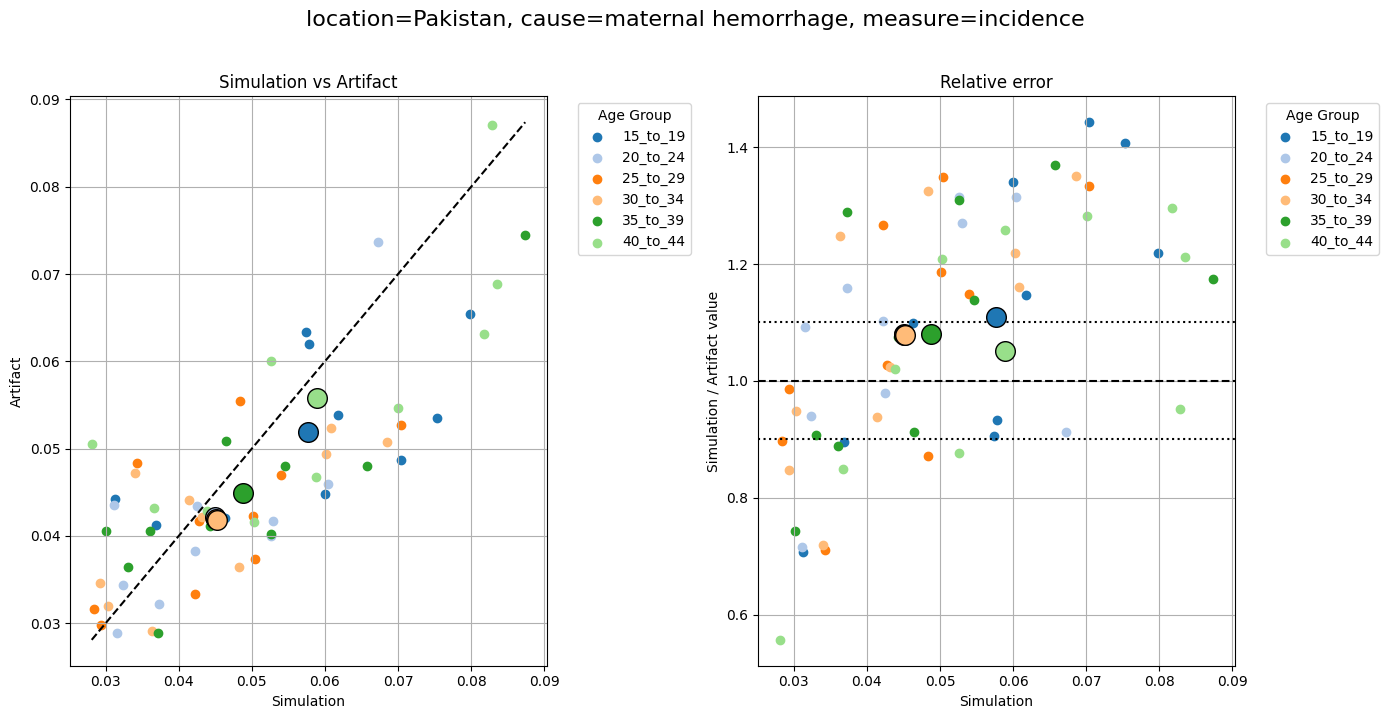

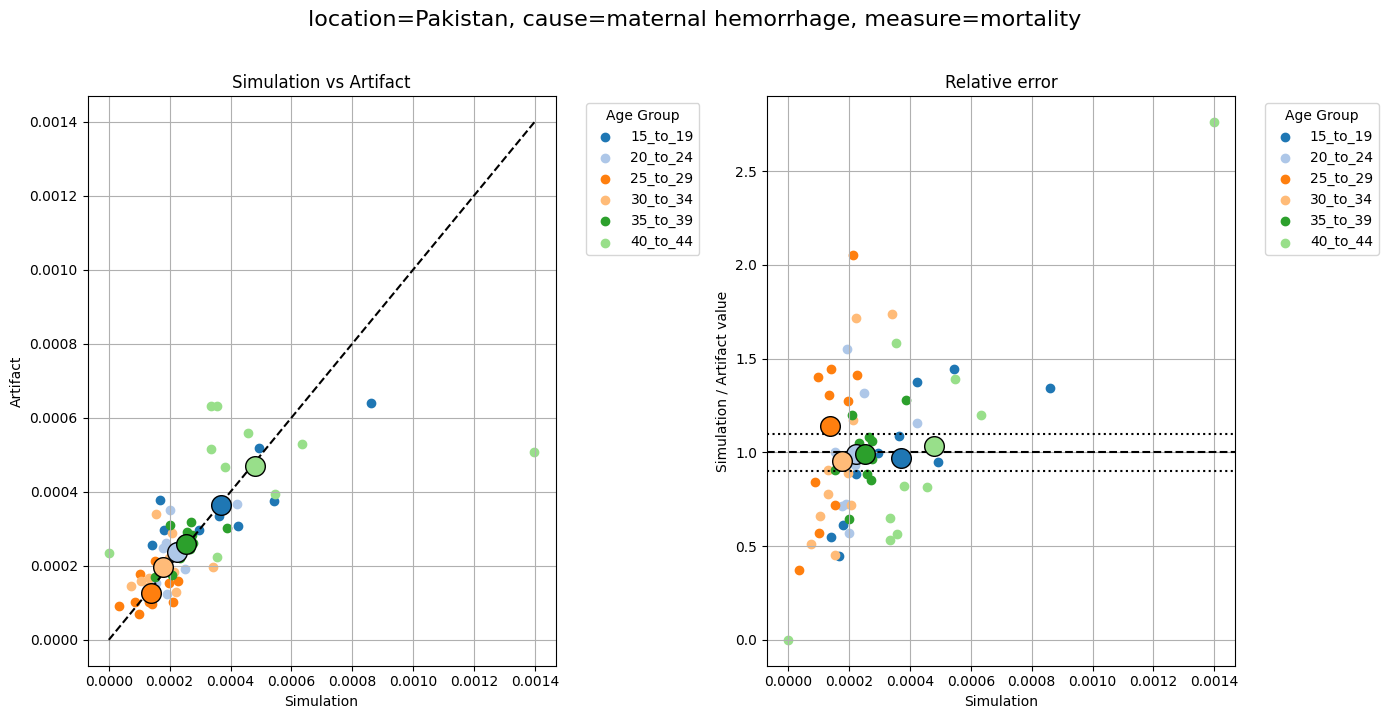

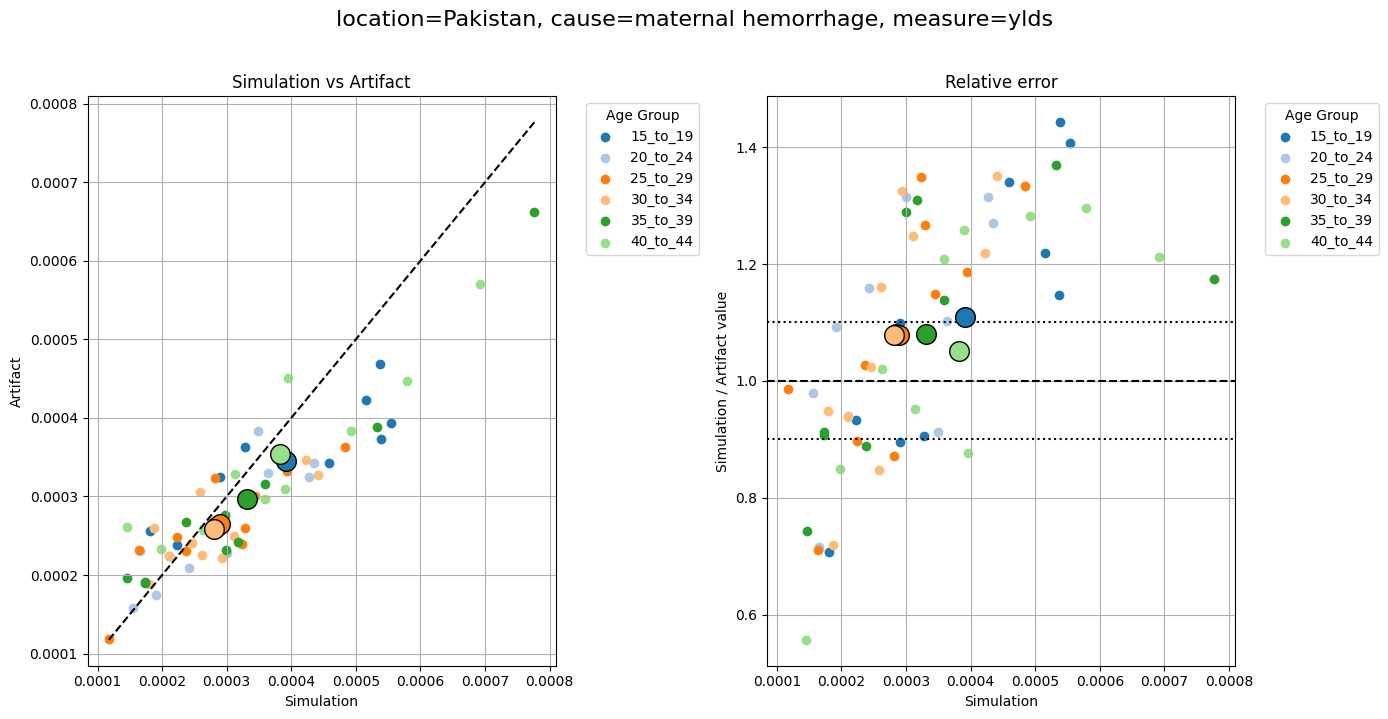

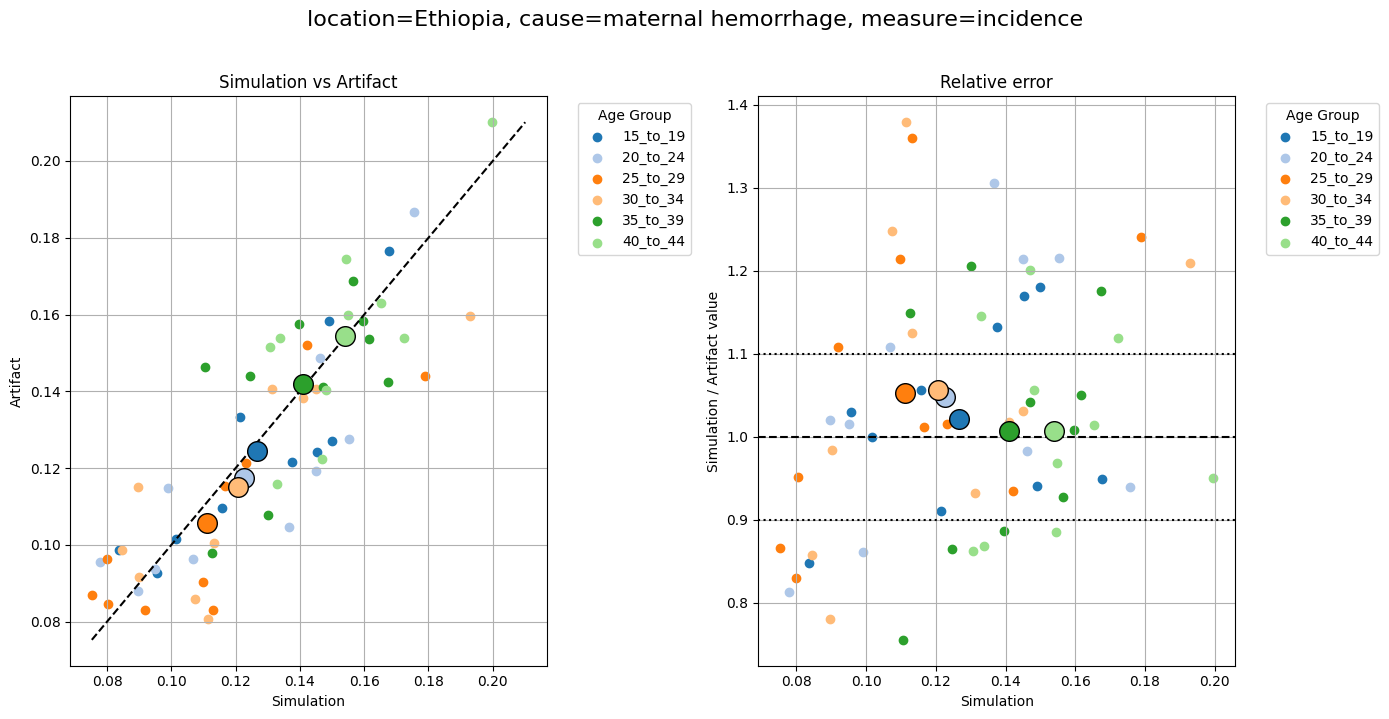

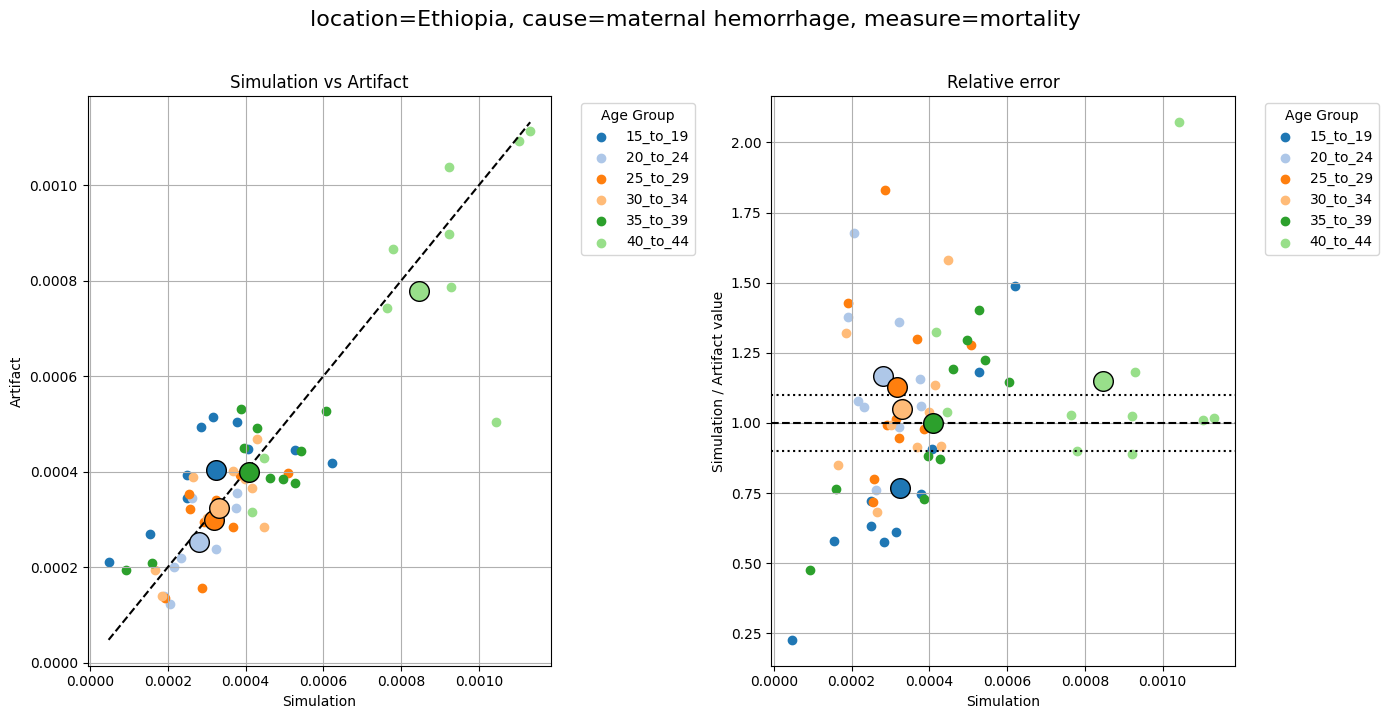

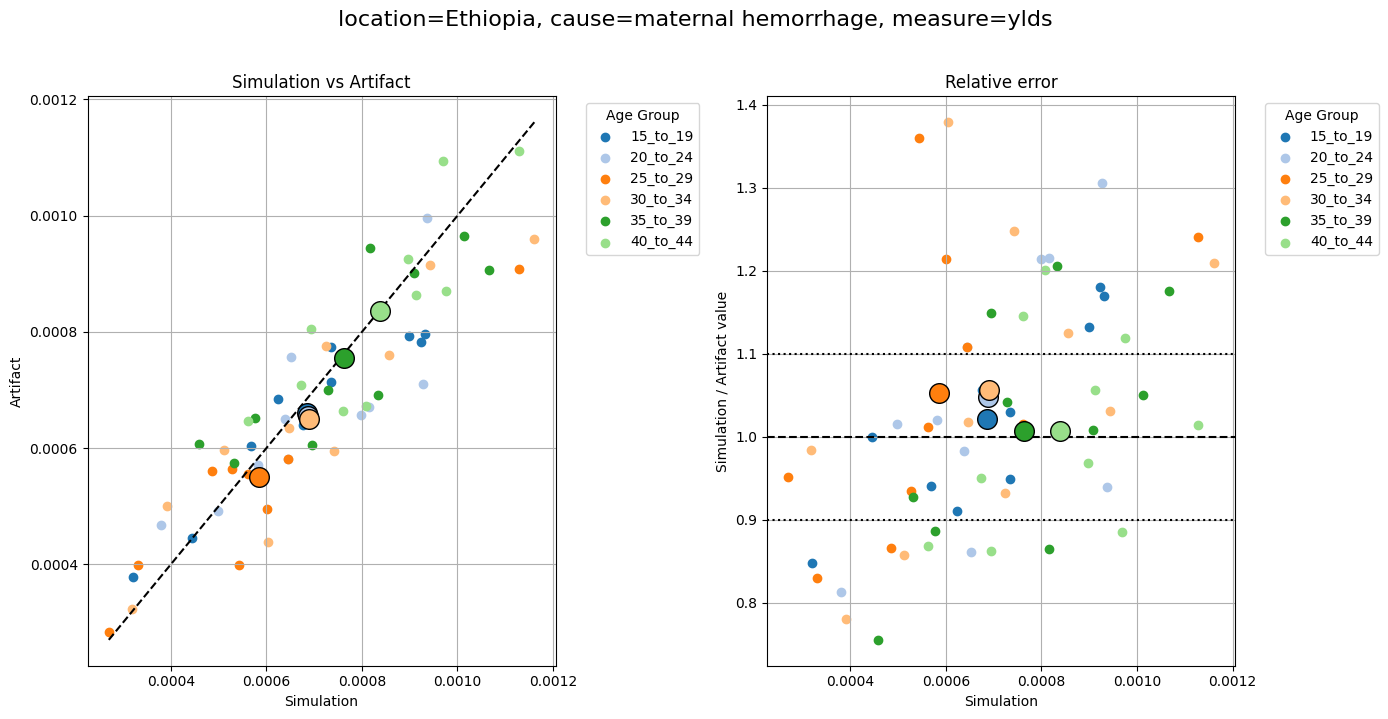

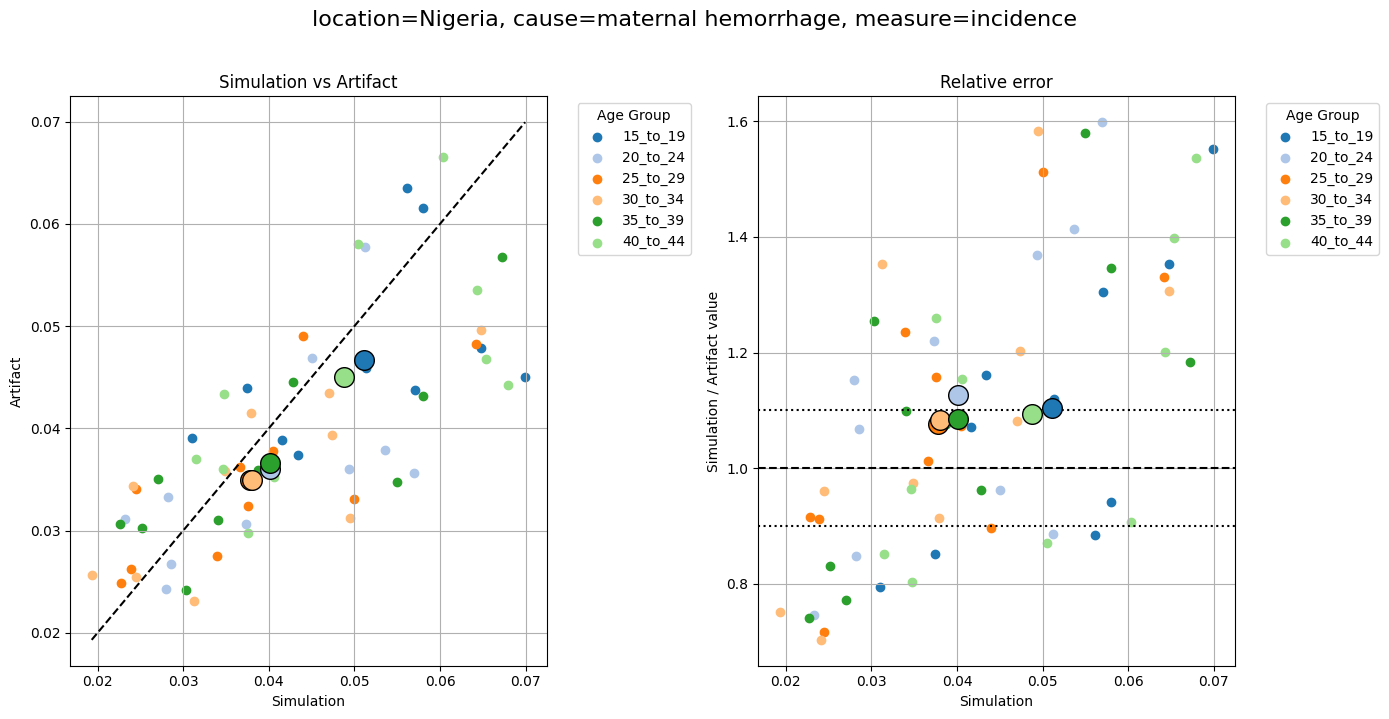

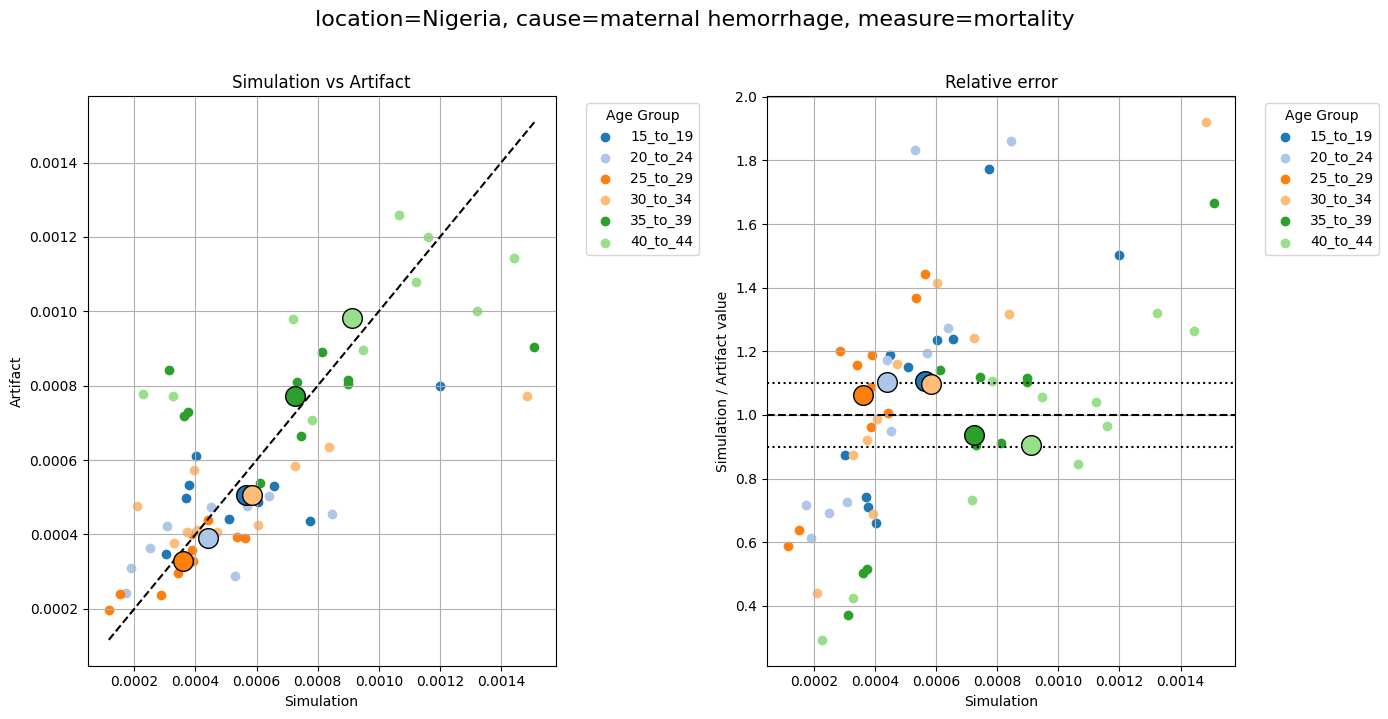

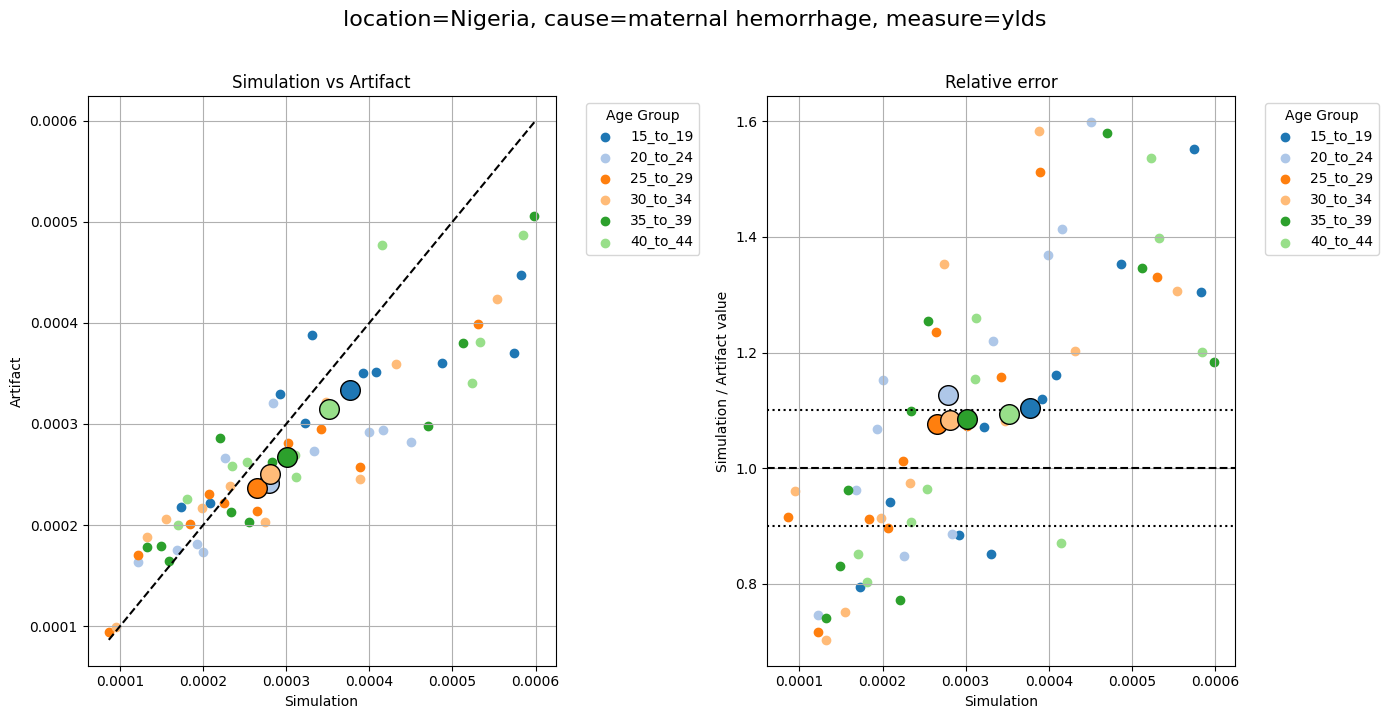

In [43]:
for location in locations:
    for measure in measures:    
        plot_quantitative_comparison(rate_results, artifact_rates_prepped, filters={
            'location': location,
            'cause': 'maternal_hemorrhage',
            'measure': measure,
        })

# Incidence is overestimated, which has been the case since model 13
# https://github.com/ihmeuw/vivarium_research_mncnh_portfolio/blob/718ba6c8d45c024b8594d1b980e8d7afdfb58f9a/verification_and_validation/model_13.0_maternal_checks.ipynb
# It seems like we might overestimate more in draws with higher incidence (and less in draws with lower incidence)

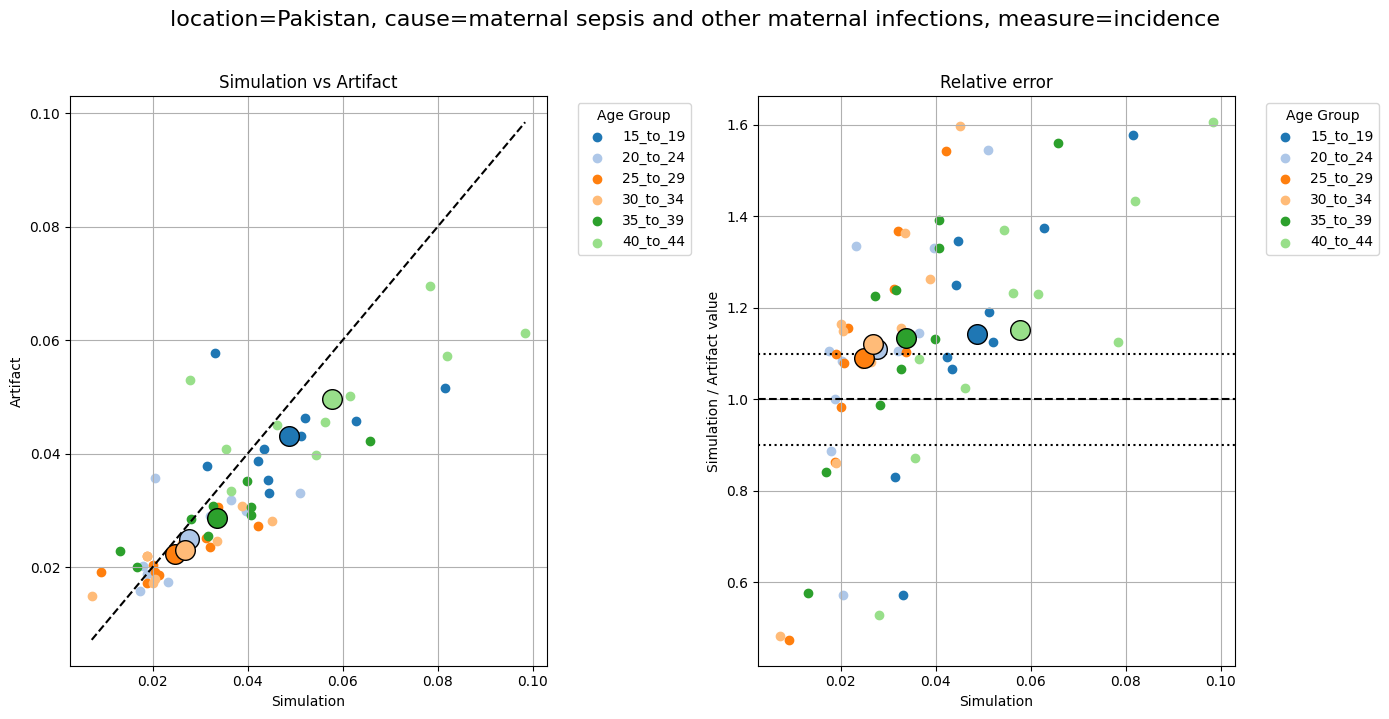

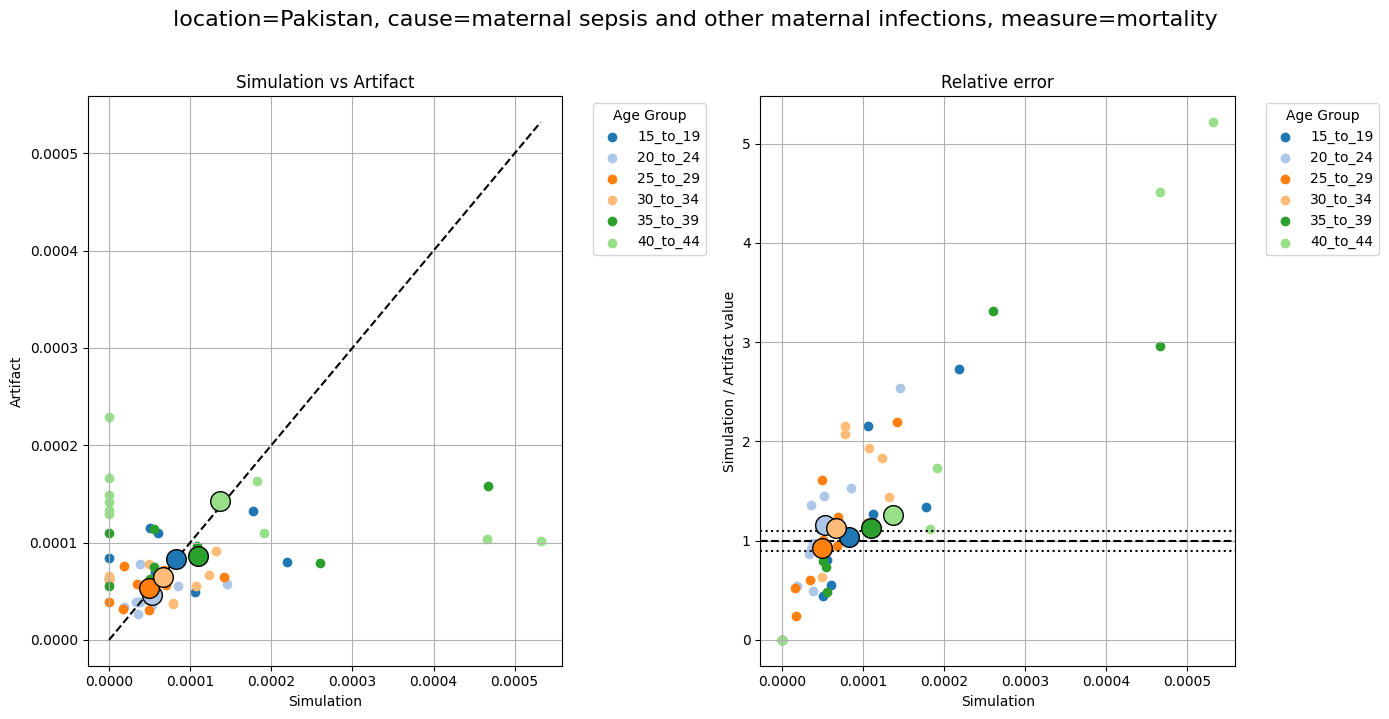

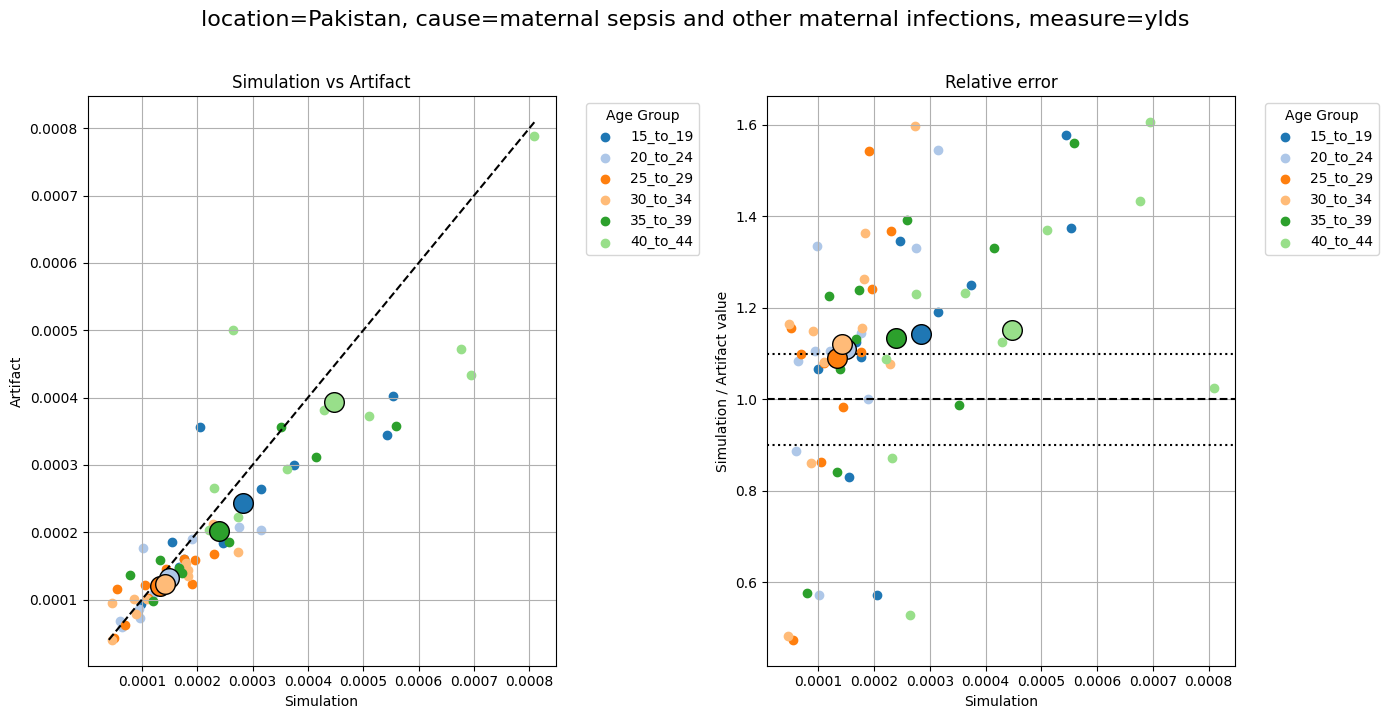

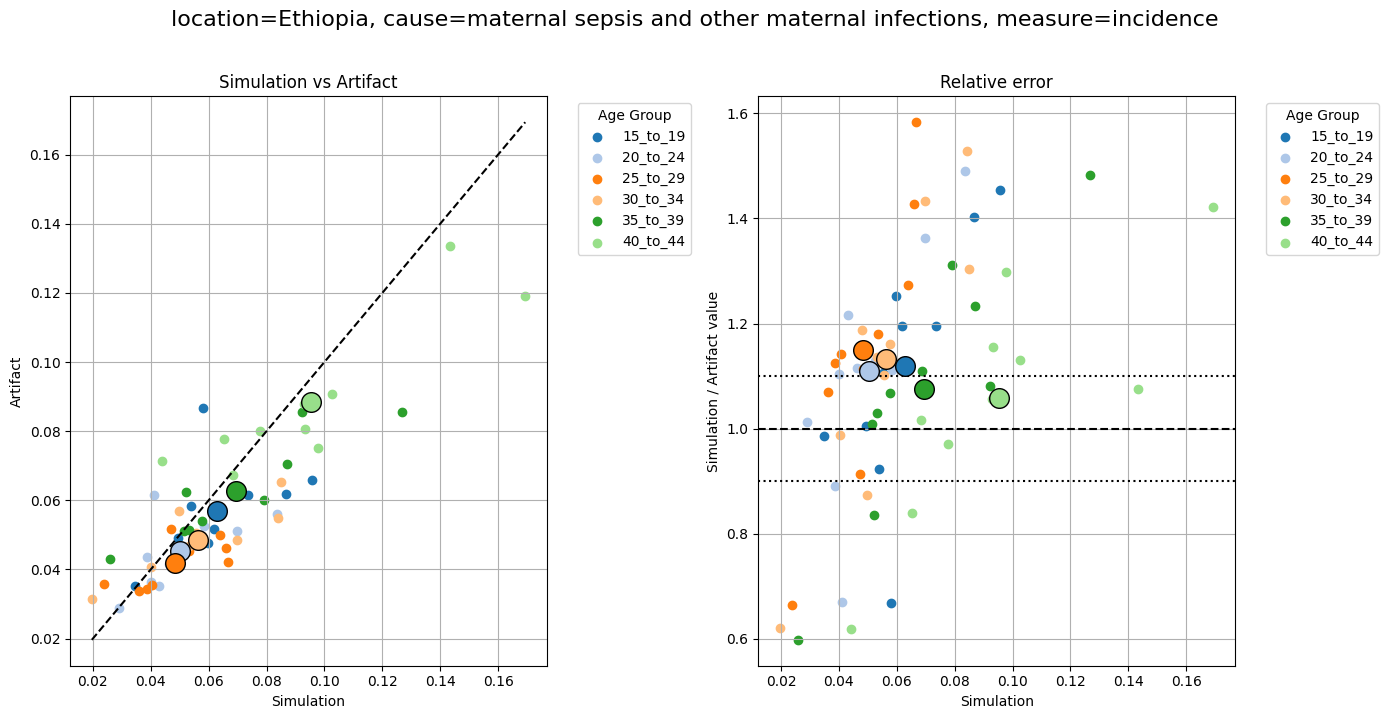

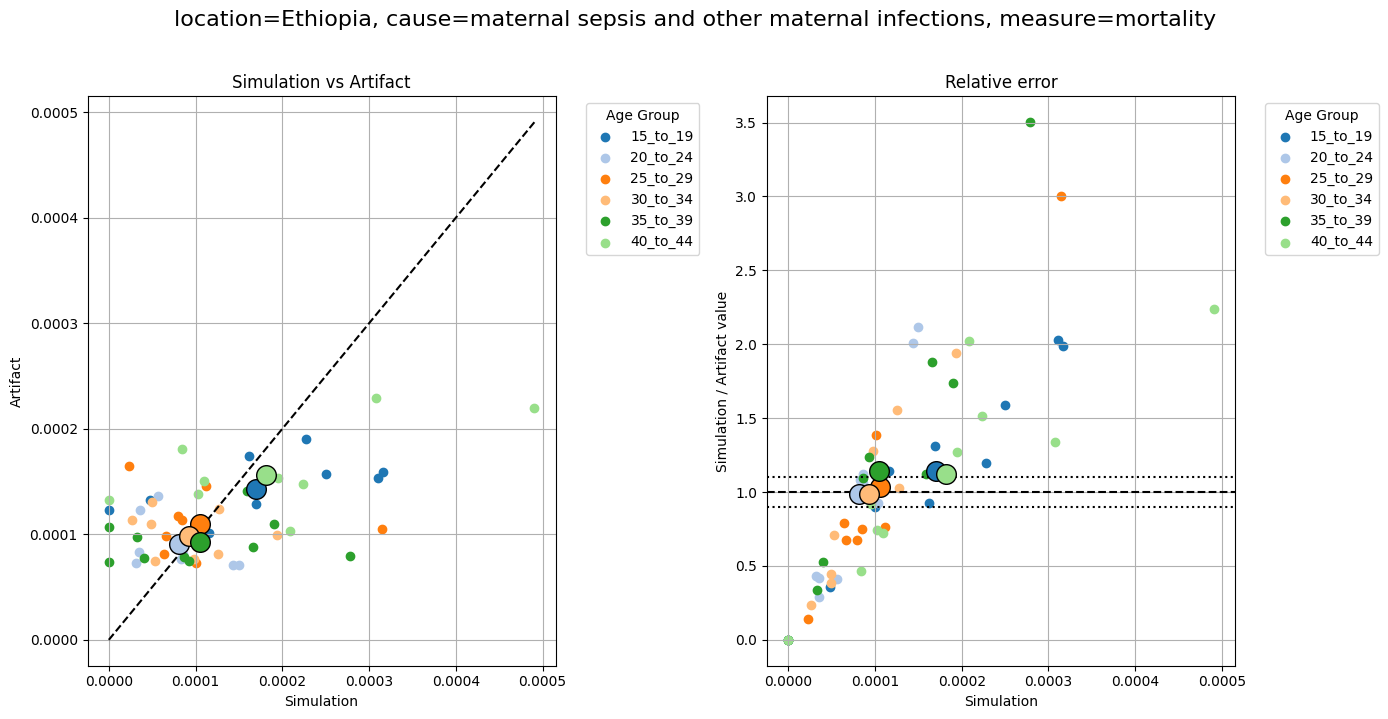

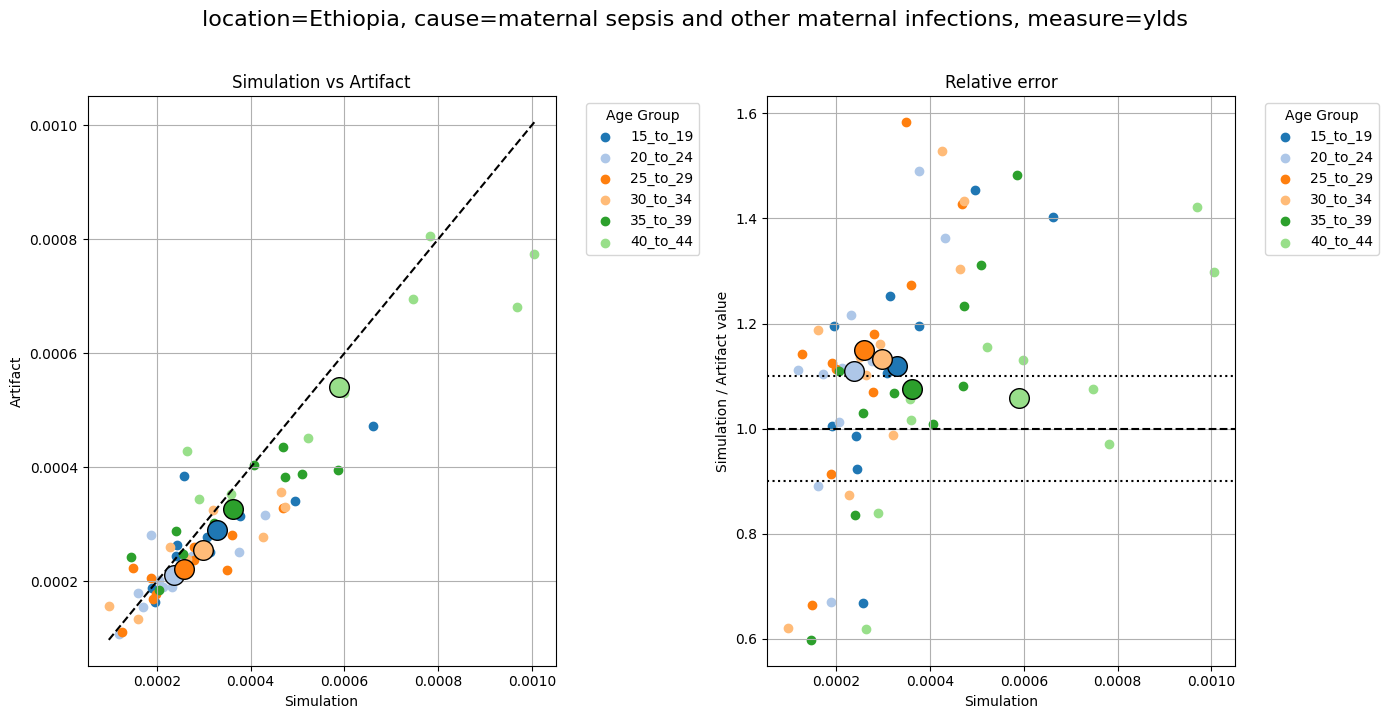

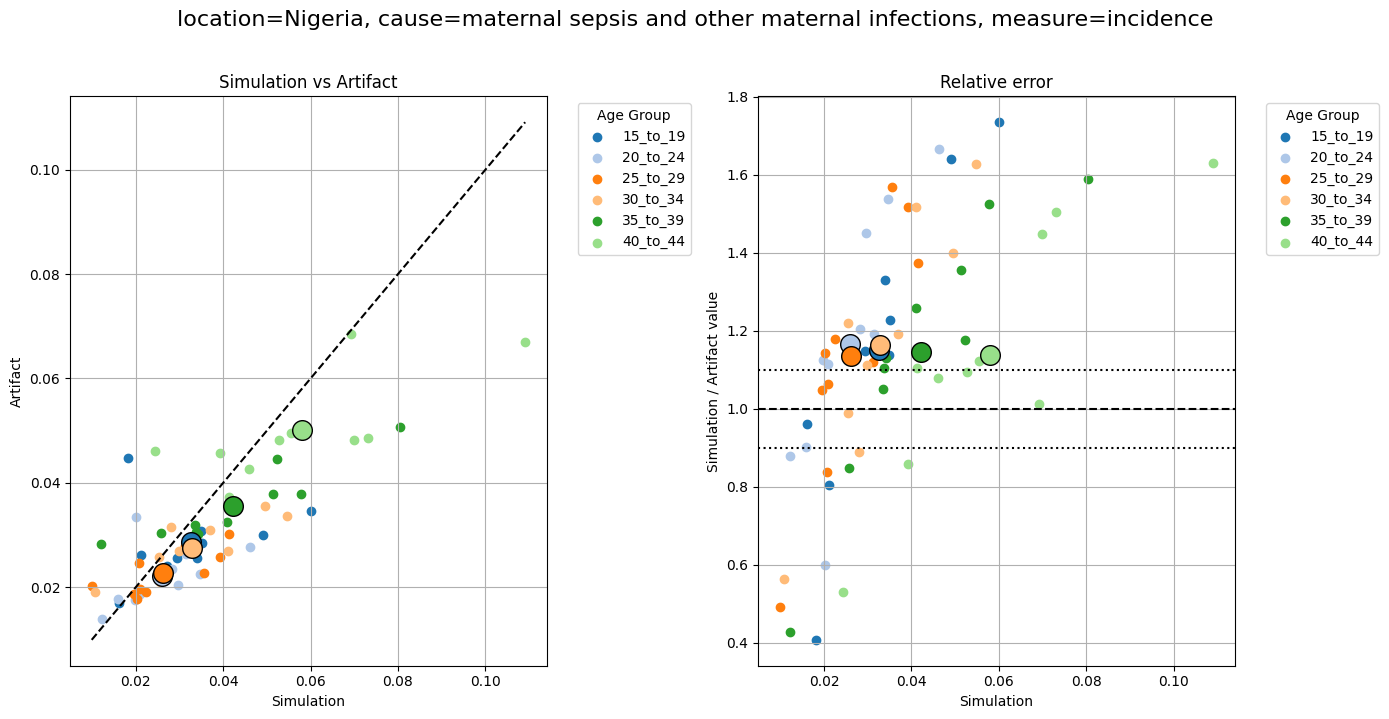

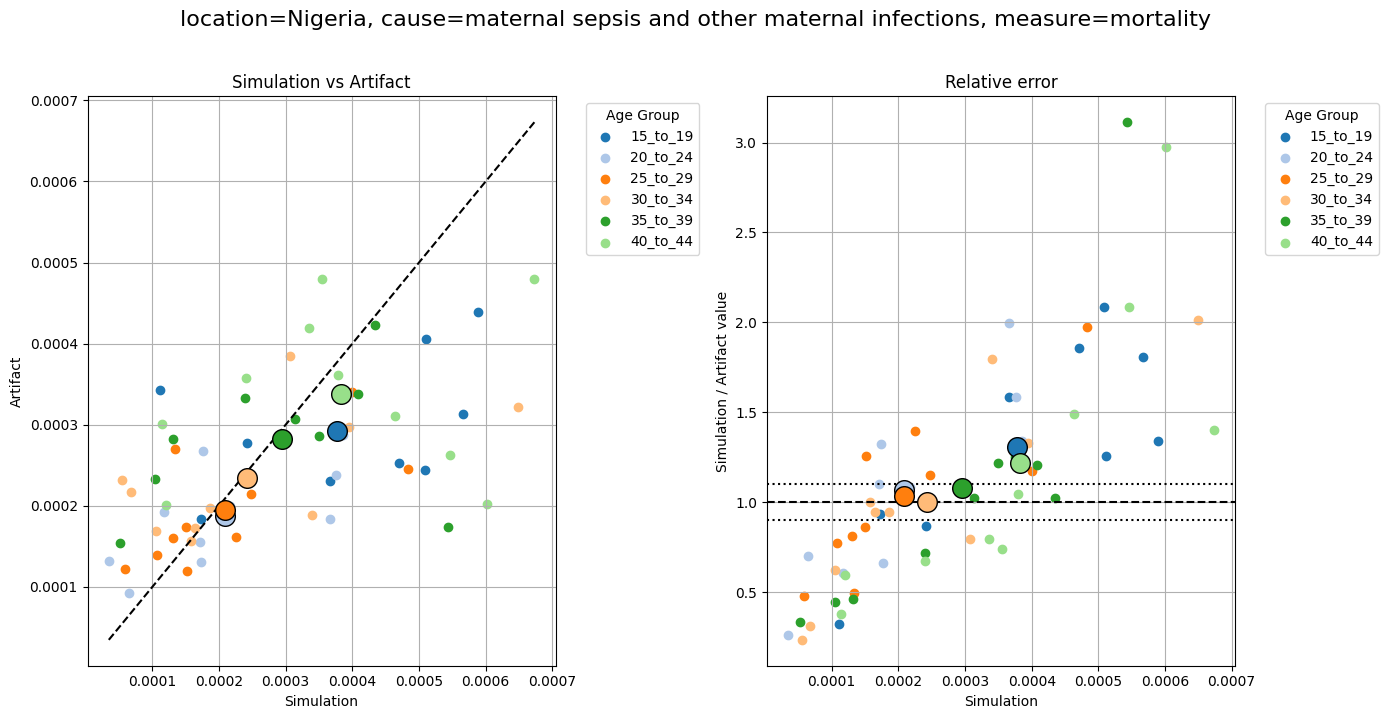

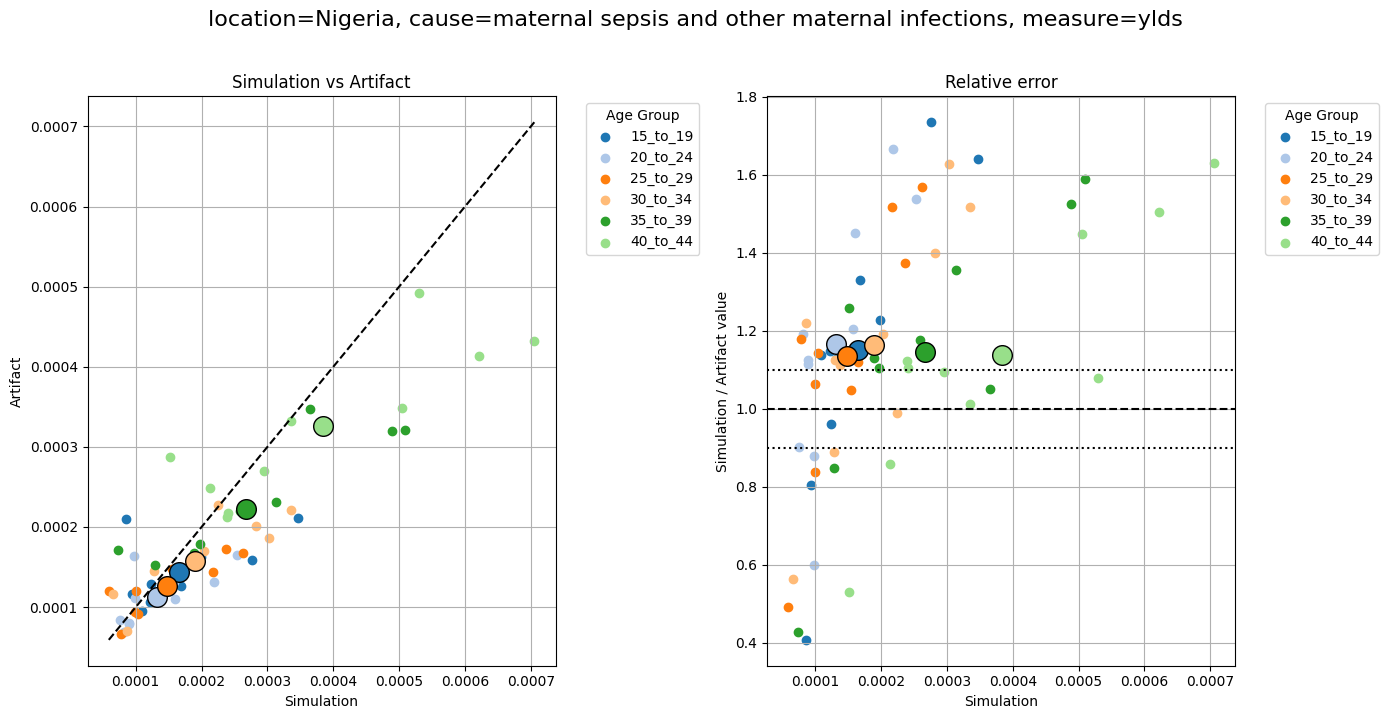

In [44]:
for location in locations:
    for measure in measures:    
        plot_quantitative_comparison(rate_results, artifact_rates_prepped, filters={
            'location': location,
            'cause': 'maternal_sepsis_and_other_maternal_infections',
            'measure': measure,
        })

# Similar issue to hemorrhage
# TODO: we should consider bumping up population size... there are several draws with zero death counts for given age groups

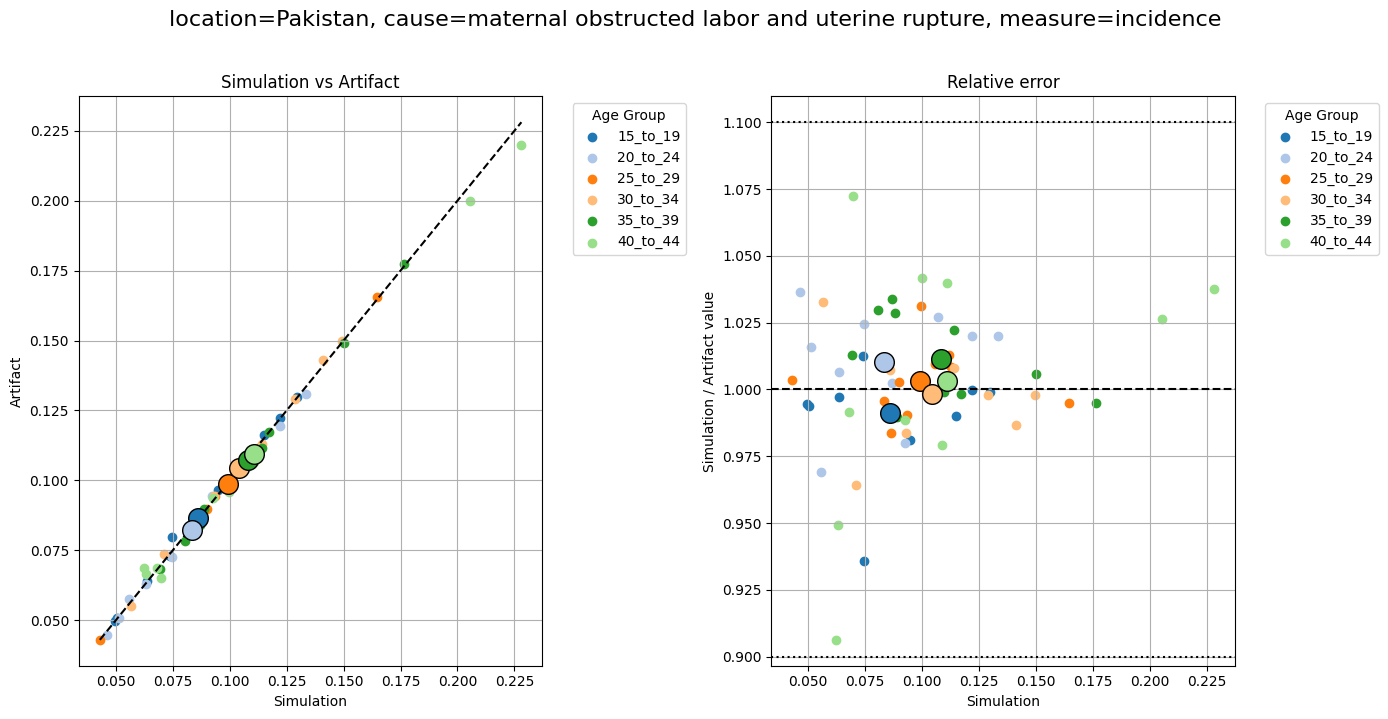

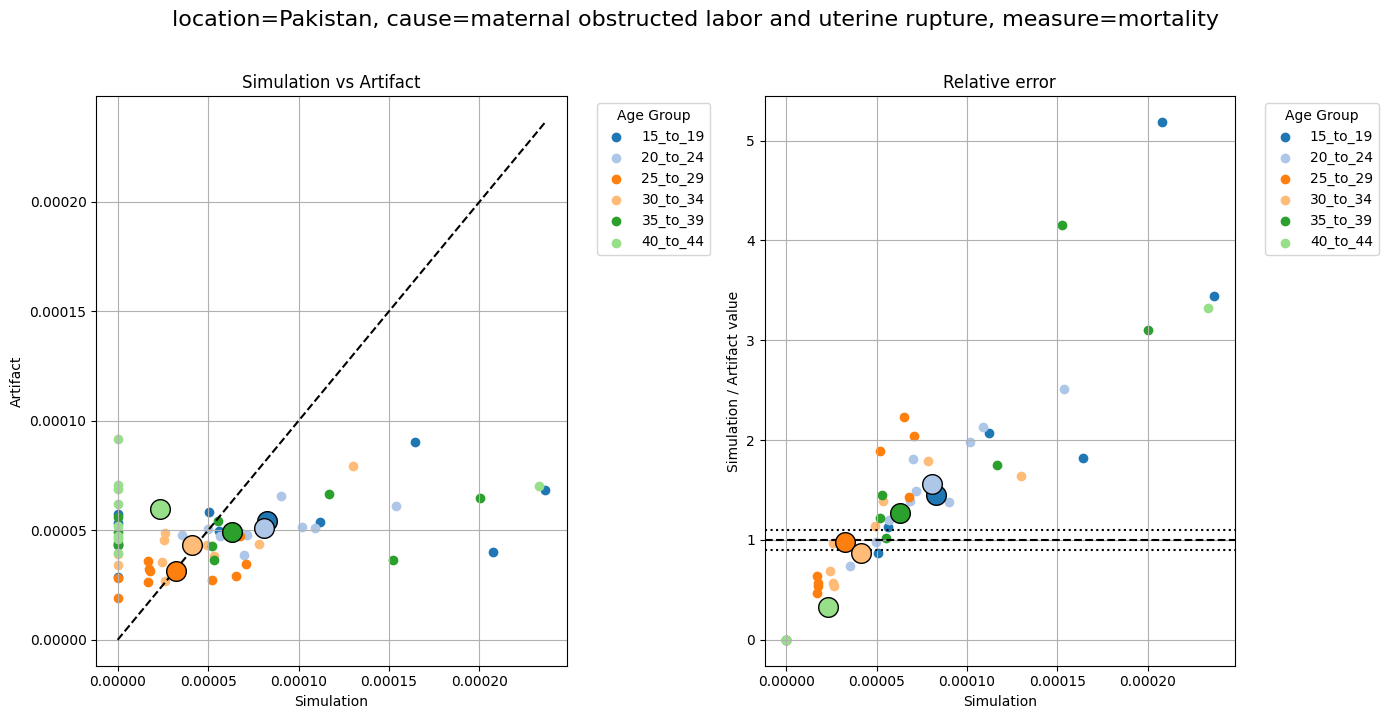

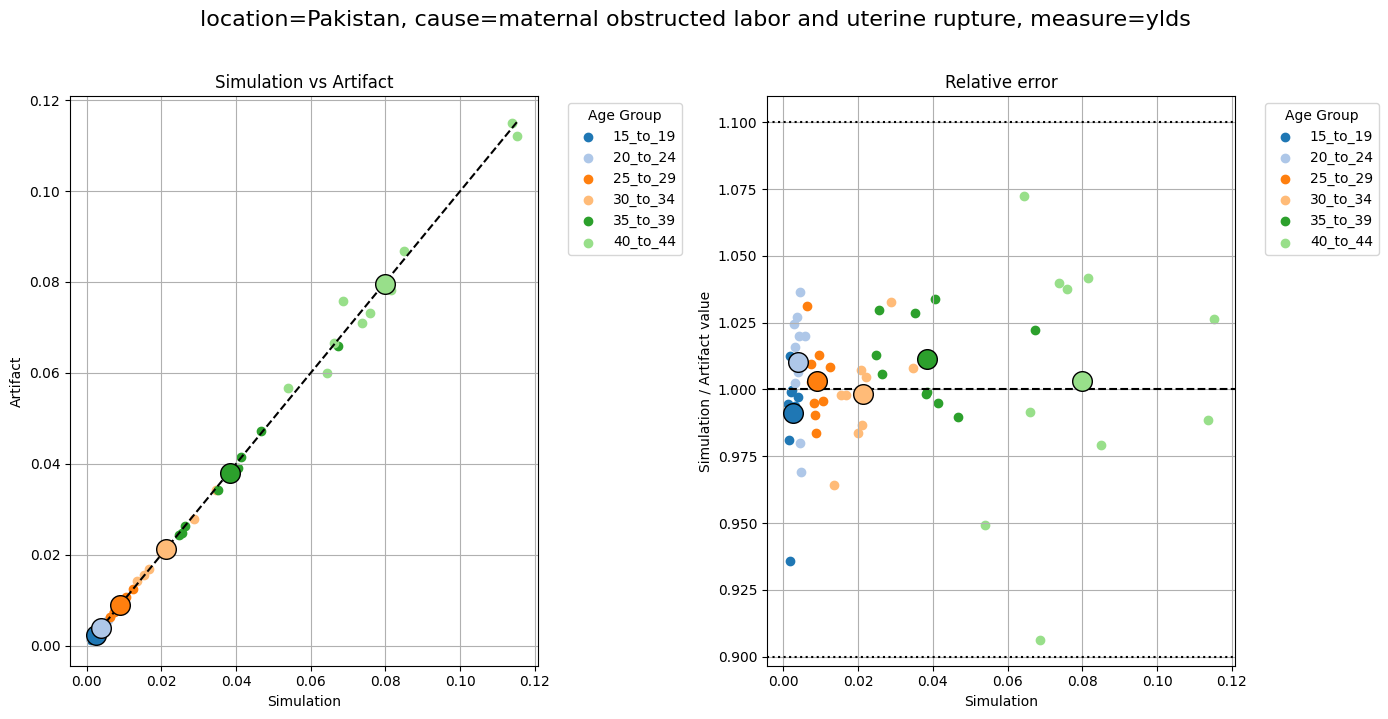

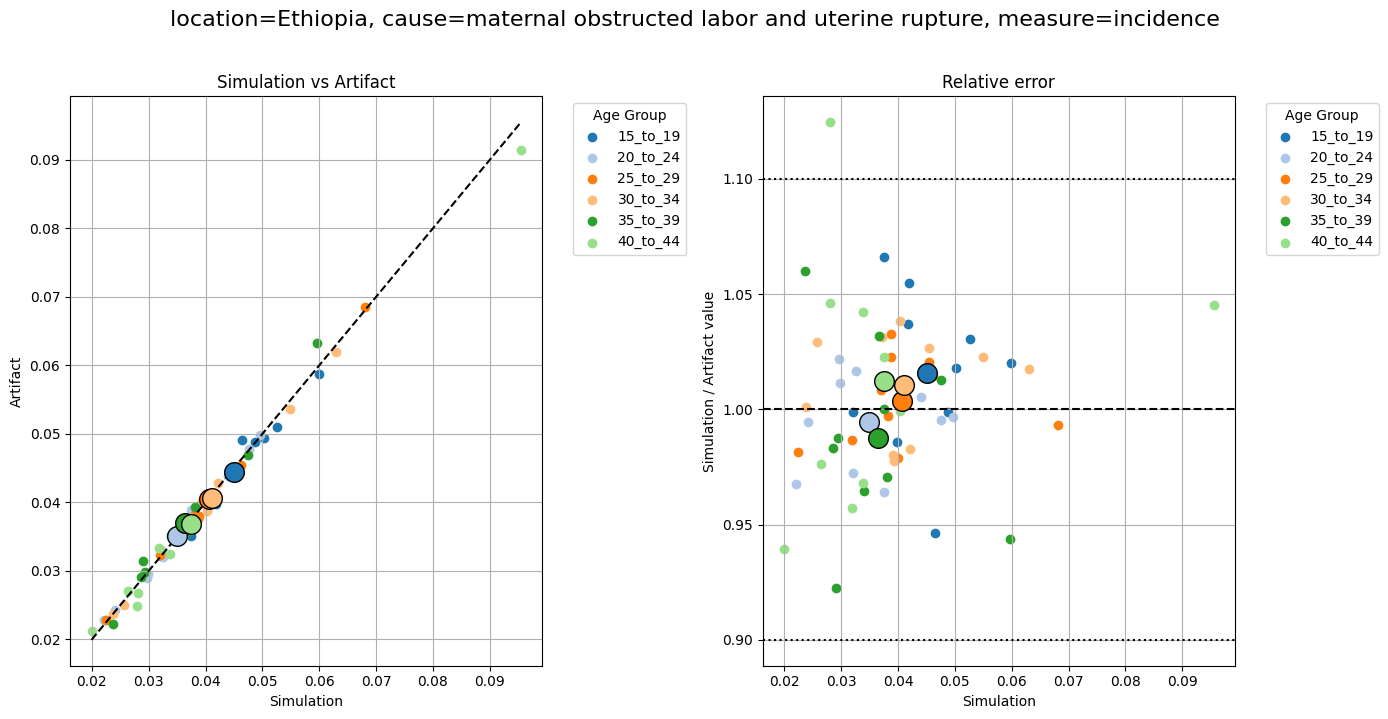

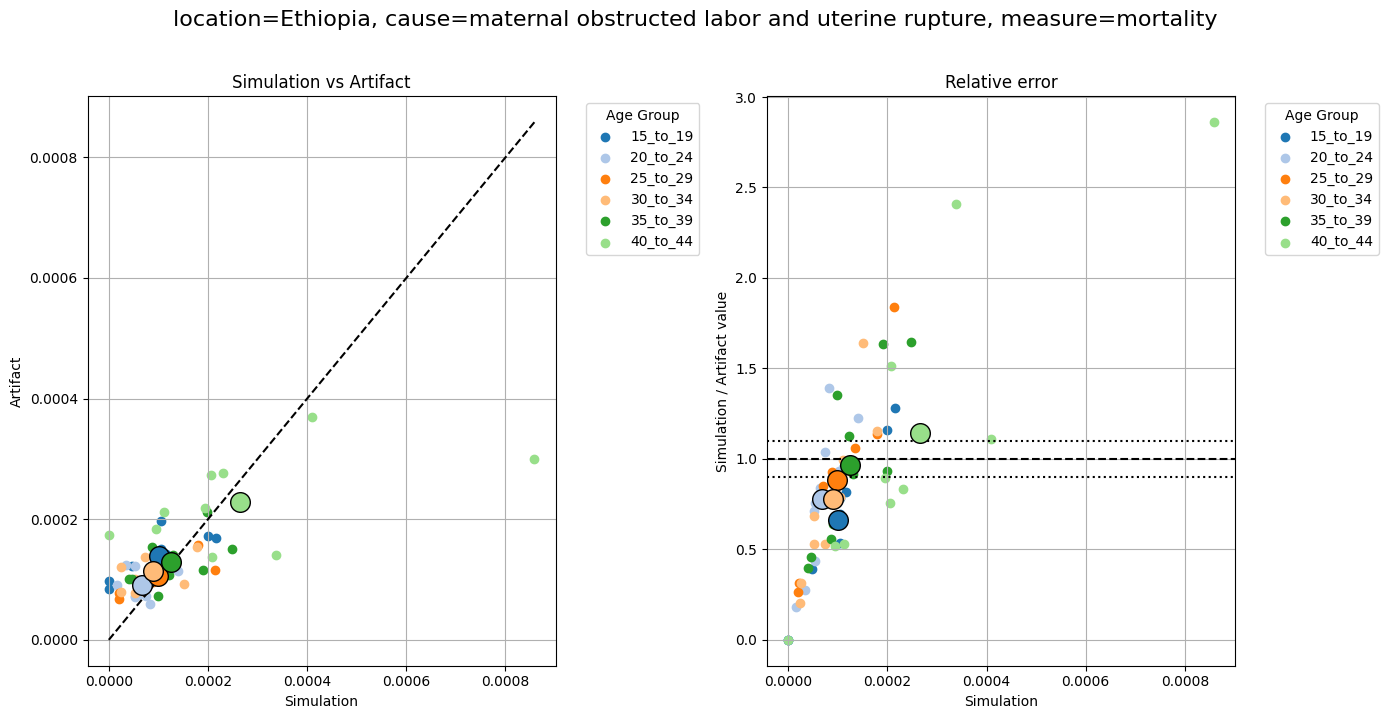

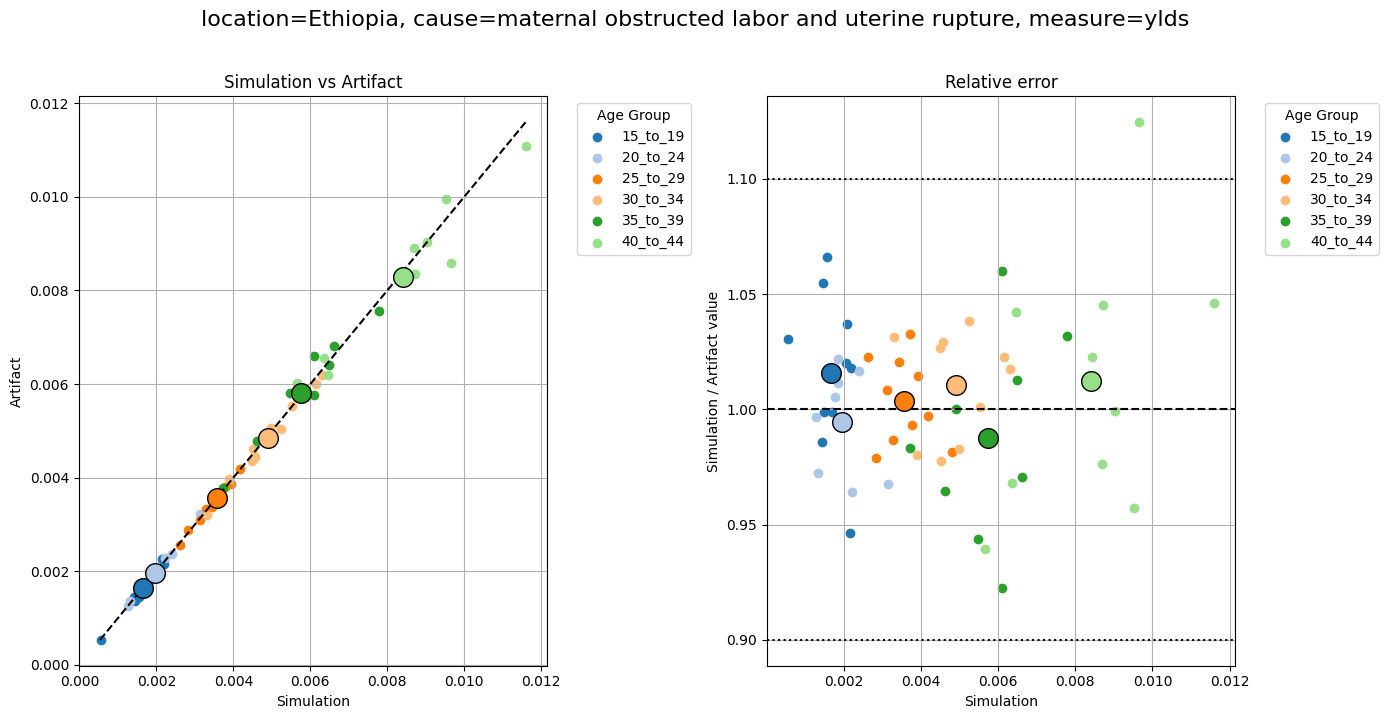

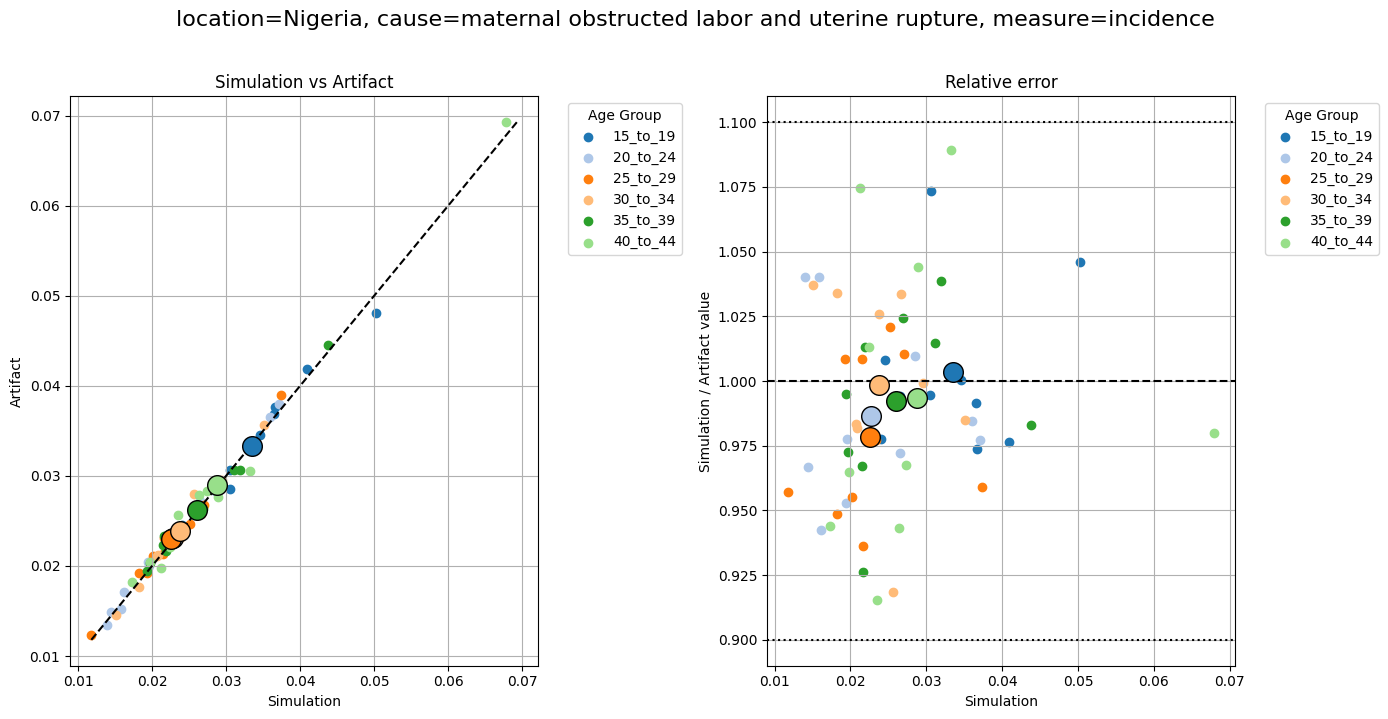

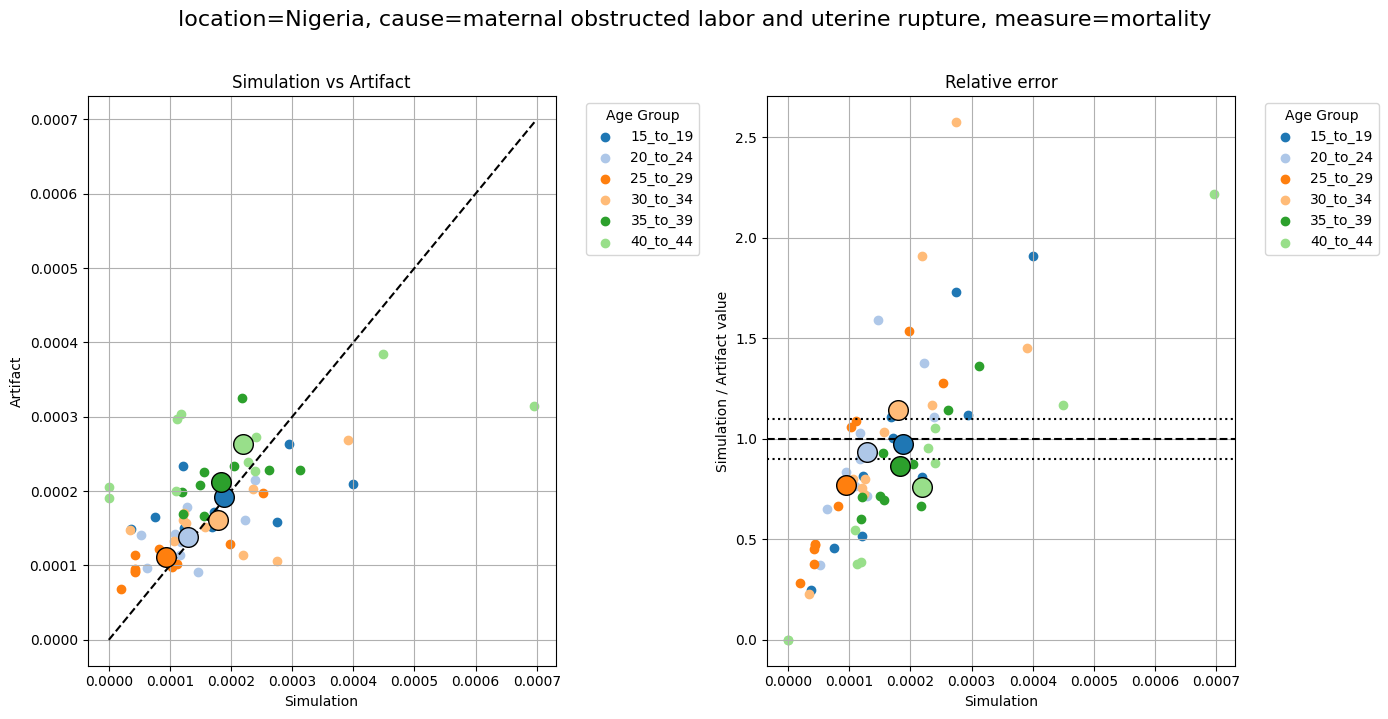

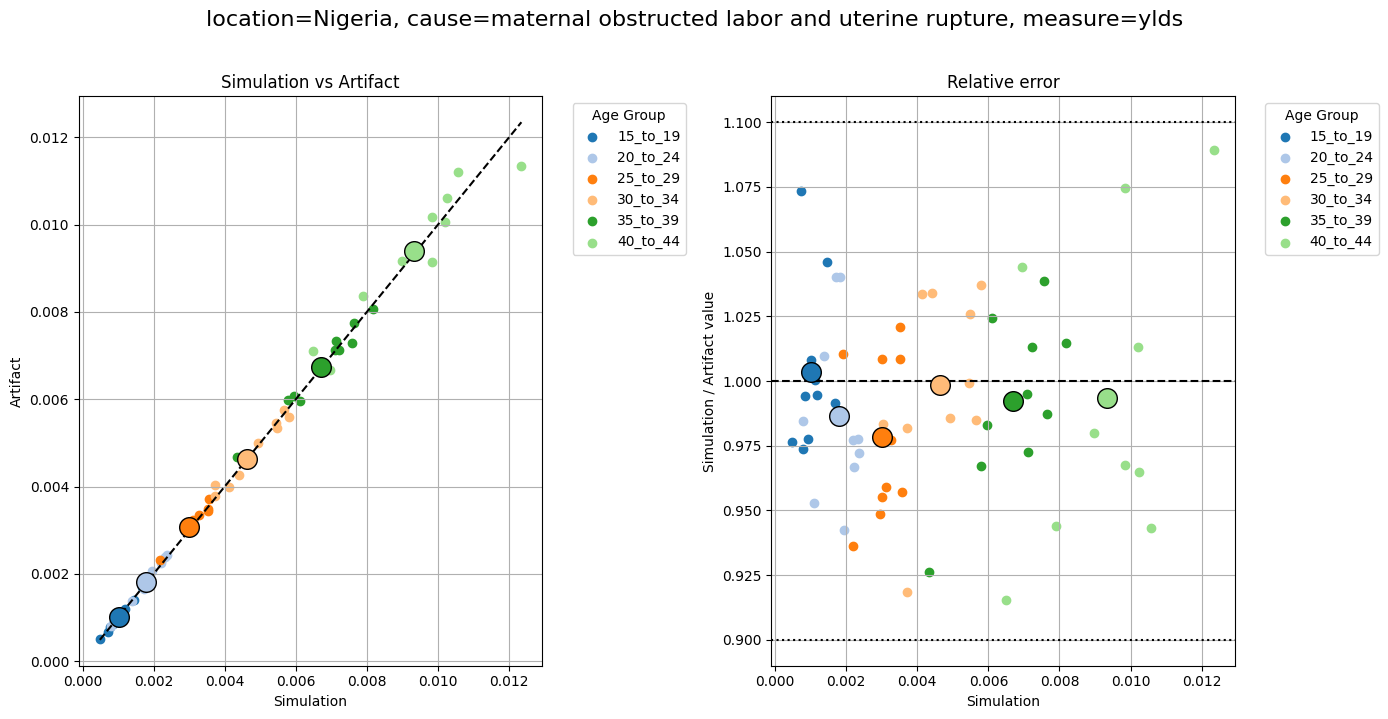

In [45]:
for location in locations:
    for measure in measures:
        plot_quantitative_comparison(rate_results, artifact_rates_prepped, filters={
            'location': location,
            'cause': 'maternal_obstructed_labor_and_uterine_rupture',
            'measure': measure,
        })

# Looks good, mortality sample size is very very small

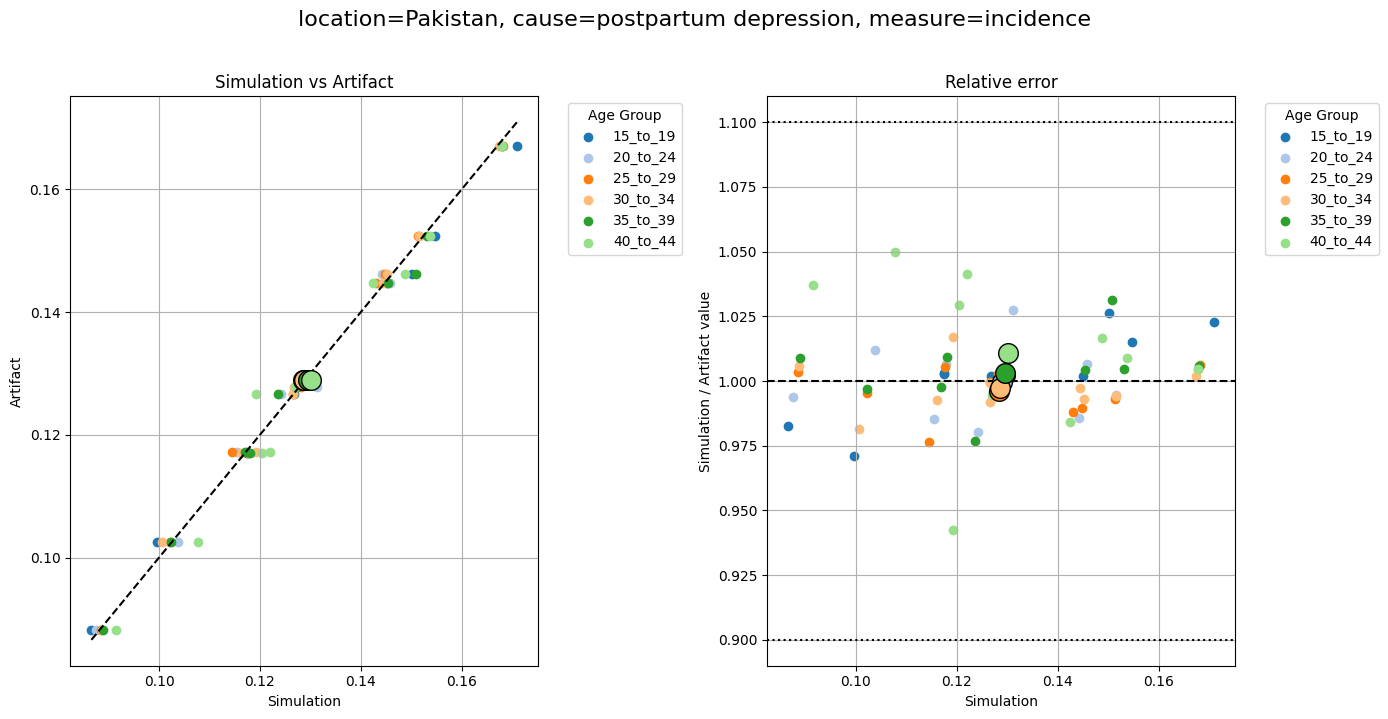

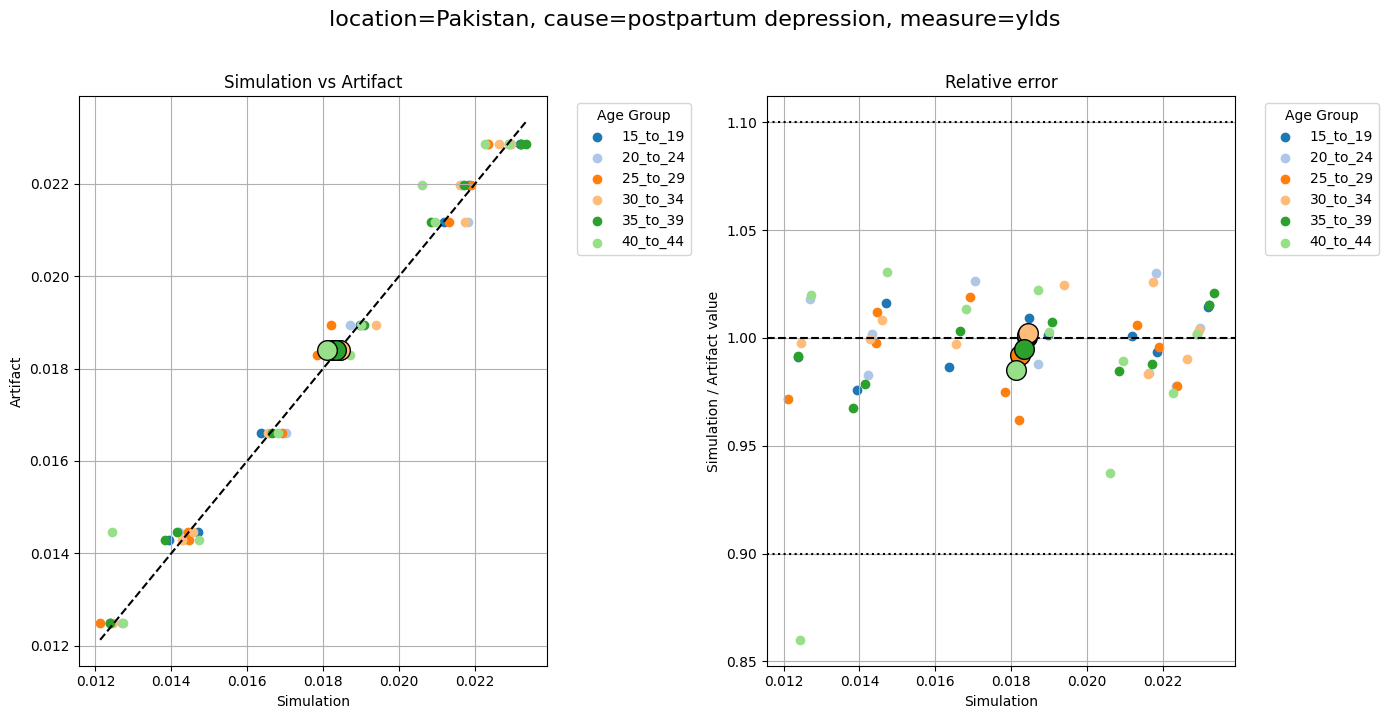

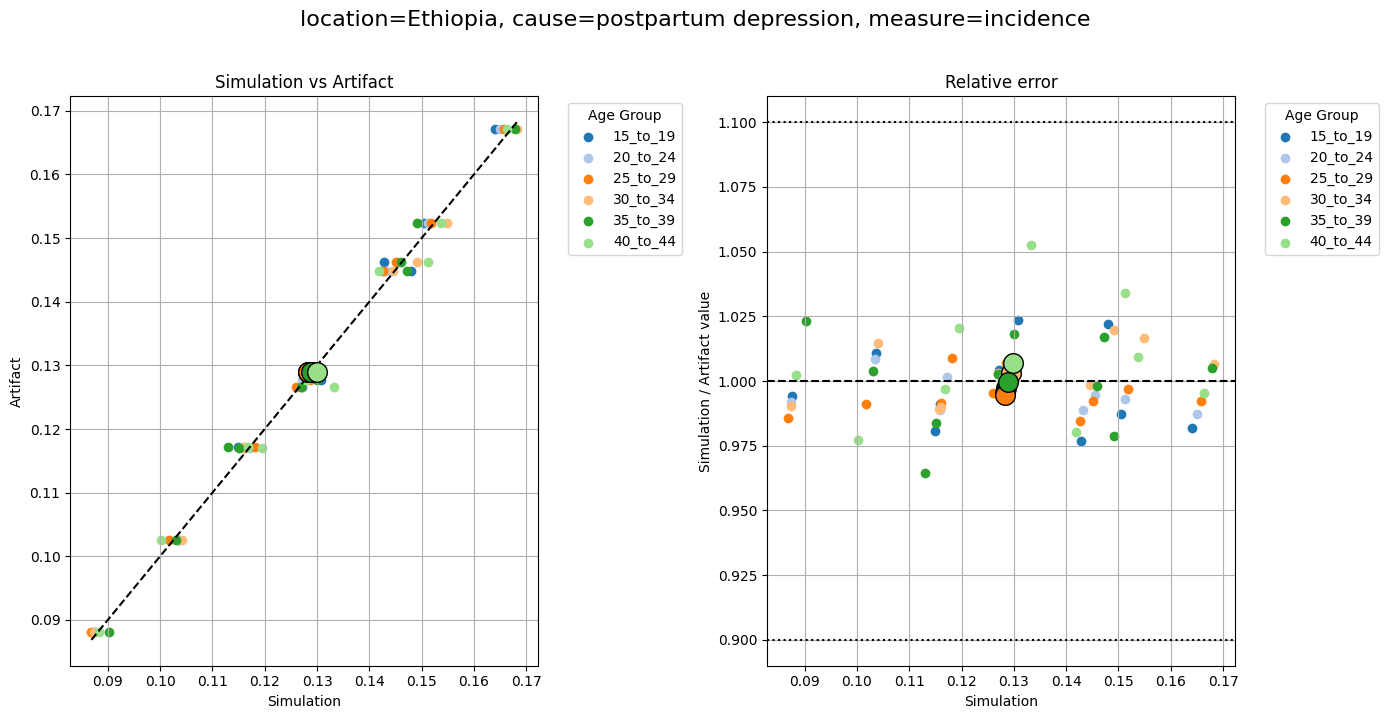

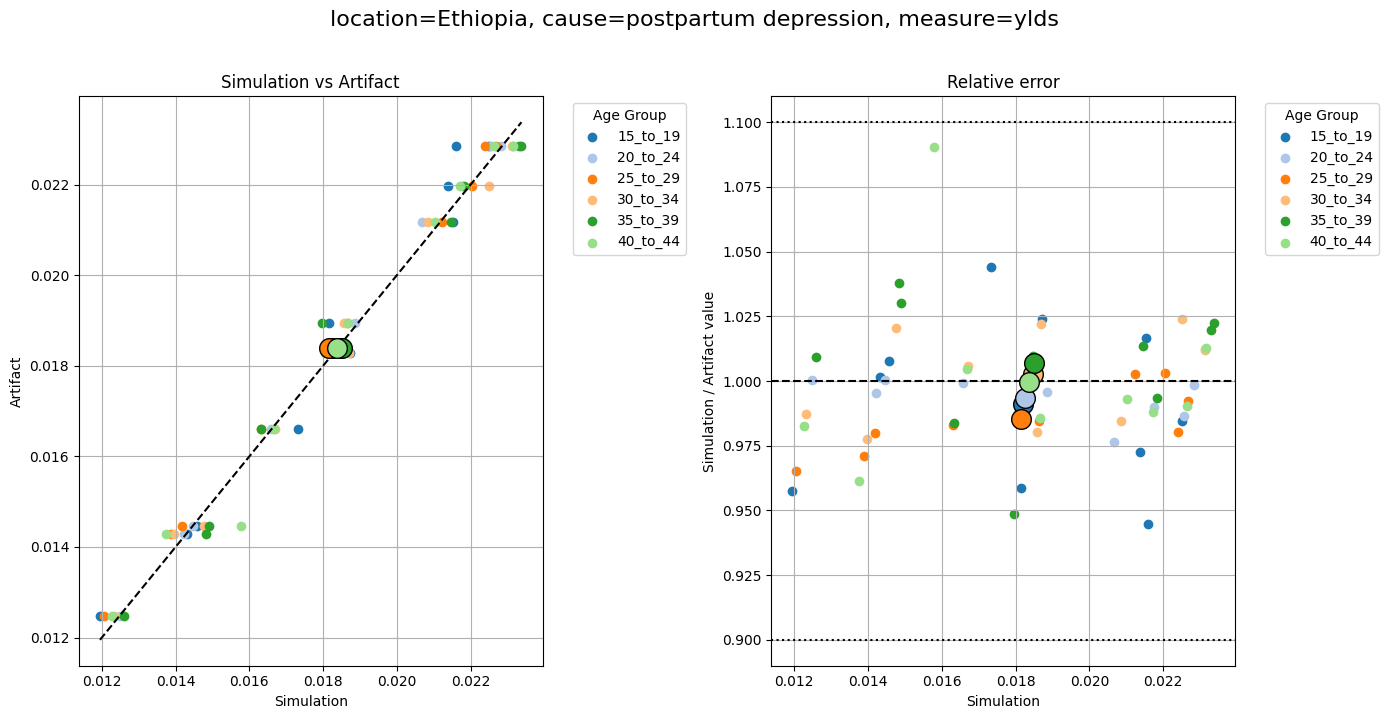

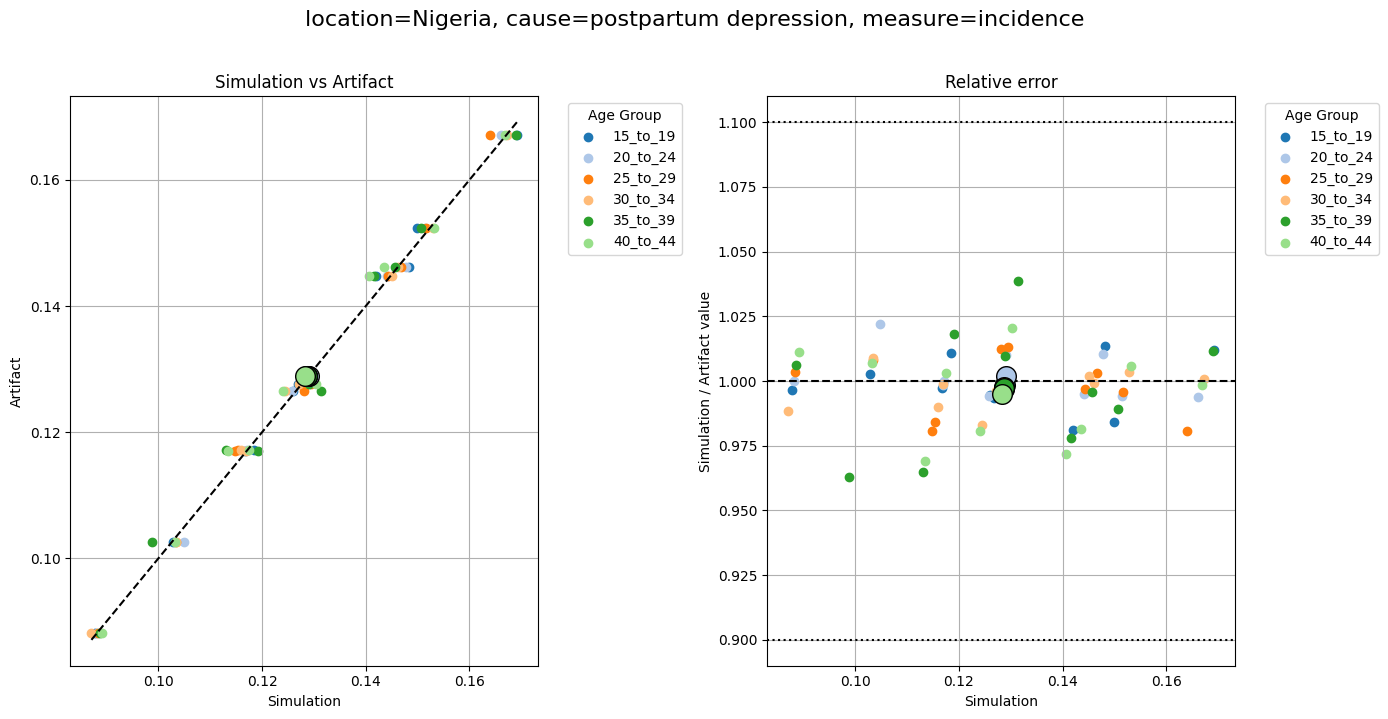

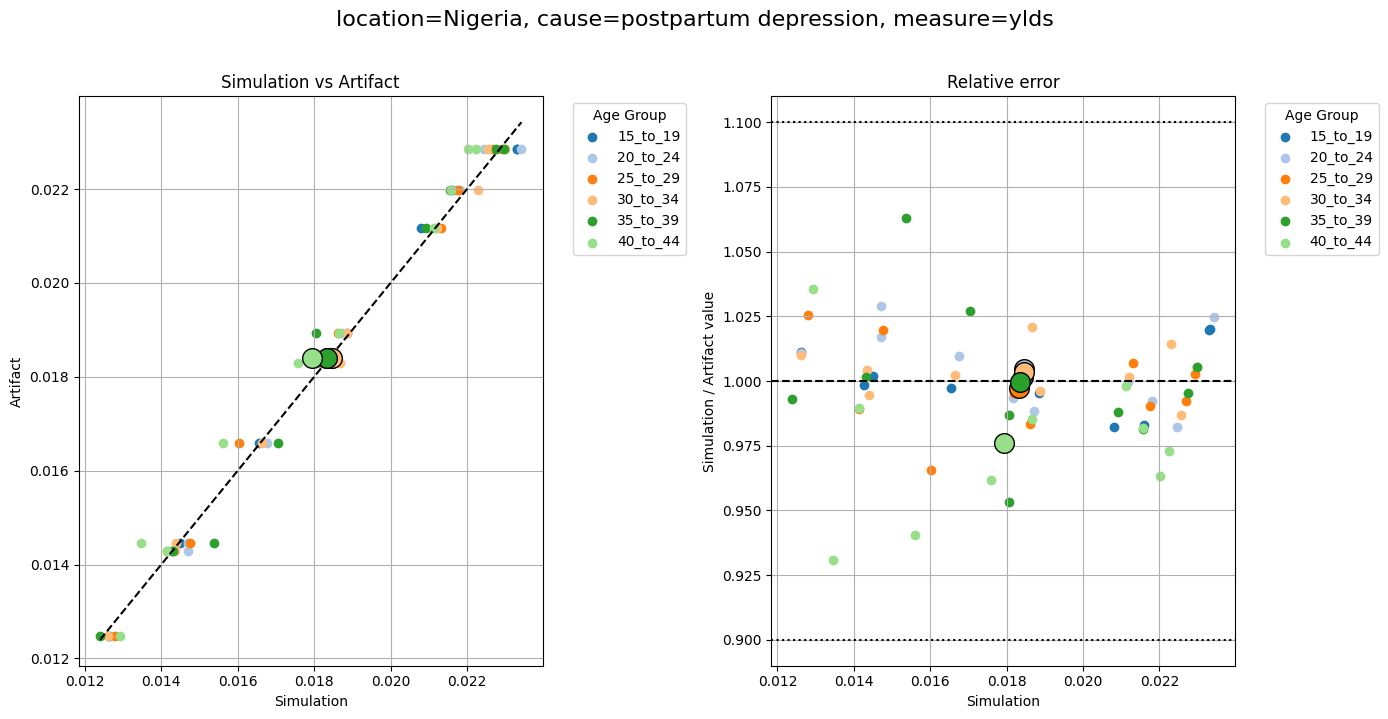

In [46]:
for location in locations:
    for measure in measures:
        if measure == 'mortality':
            continue

        plot_quantitative_comparison(rate_results, artifact_rates_prepped, filters={
            'location': location,
            'cause': 'postpartum_depression',
            'measure': measure,
        })

# Looks good.

## Verify pregnancy outcomes

In [47]:
outcome_fractions = (births.groupby(groupby_cols + ['pregnancy_outcome'])['value'].sum()
                    / births.groupby(groupby_cols)['value'].sum()).reset_index()
outcome_fractions = outcome_fractions.dropna().rename(columns={'pregnancy_outcome': 'outcome'})
outcome_fractions['age_start'] = outcome_fractions.age_group.str.split('_to_').str[0].astype(float)
outcome_fractions['age_end'] = outcome_fractions.age_group.str.split('_to_').str[1].astype(float) + 1
outcome_fractions

location  input_draw age_group       outcome     value  age_start  \
0     Ethiopia          22  10_to_14    live_birth  0.342879       10.0   
1     Ethiopia          22  10_to_14  partial_term  0.646285       10.0   
2     Ethiopia          22  10_to_14    stillbirth  0.010836       10.0   
3     Ethiopia          22  15_to_19    live_birth  0.435583       15.0   
4     Ethiopia          22  15_to_19  partial_term  0.551586       15.0   
...        ...         ...       ...           ...       ...        ...   
1588  Pakistan         244  45_to_49  partial_term  0.237628       45.0   
1589  Pakistan         244  45_to_49    stillbirth  0.043598       45.0   
1590  Pakistan         244  50_to_54    live_birth  0.562500       50.0   
1591  Pakistan         244  50_to_54  partial_term  0.416667       50.0   
1592  Pakistan         244  50_to_54    stillbirth  0.020833       50.0   

      age_end  
0        15.0  
1        15.0  
2        15.0  
3        20.0  
4        20.0  
...       ...  
1588     50.0  
1589     50.0  
1590     55.0  
1591     55.0  
1592     55.0  

[810 rows x 7 columns]

In [48]:
artifact_birth_outcomes.columns.name = 'input_draw'

In [49]:
artifact_birth_outcomes_prepped = artifact_birth_outcomes.stack().rename("value").reset_index()
artifact_birth_outcomes_prepped['input_draw'] = artifact_birth_outcomes_prepped.input_draw.str.replace('draw_', '').astype(int)
assert artifact_birth_outcomes_prepped.year_start.nunique() == artifact_birth_outcomes_prepped.year_end.nunique() == 1
assert artifact_birth_outcomes_prepped.sex.nunique() == 1
artifact_birth_outcomes_prepped = artifact_birth_outcomes_prepped.drop(columns=['year_start', 'year_end', 'sex'])
artifact_birth_outcomes_prepped['age_group'] = (
    artifact_birth_outcomes_prepped.age_start.astype(int).astype(str) + '_to_' + (artifact_birth_outcomes_prepped.age_end.astype(int) - 1).astype(str)
)

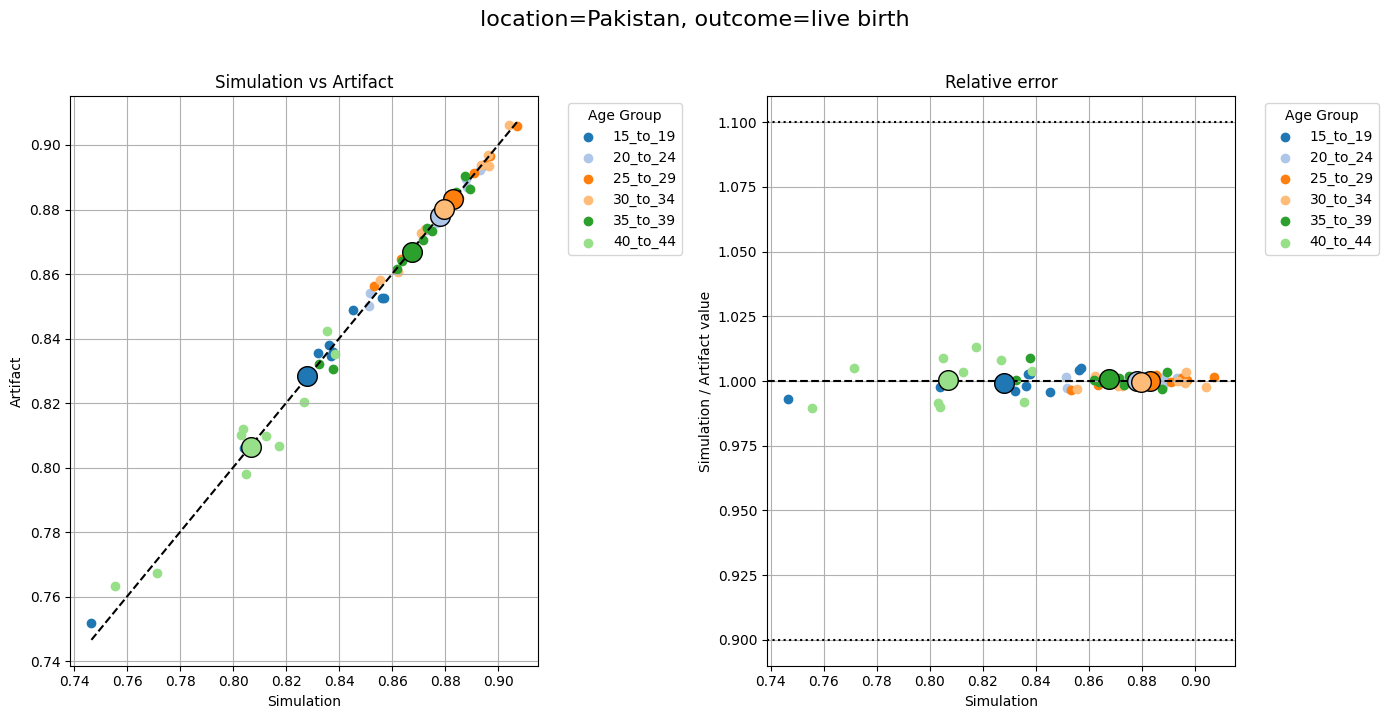

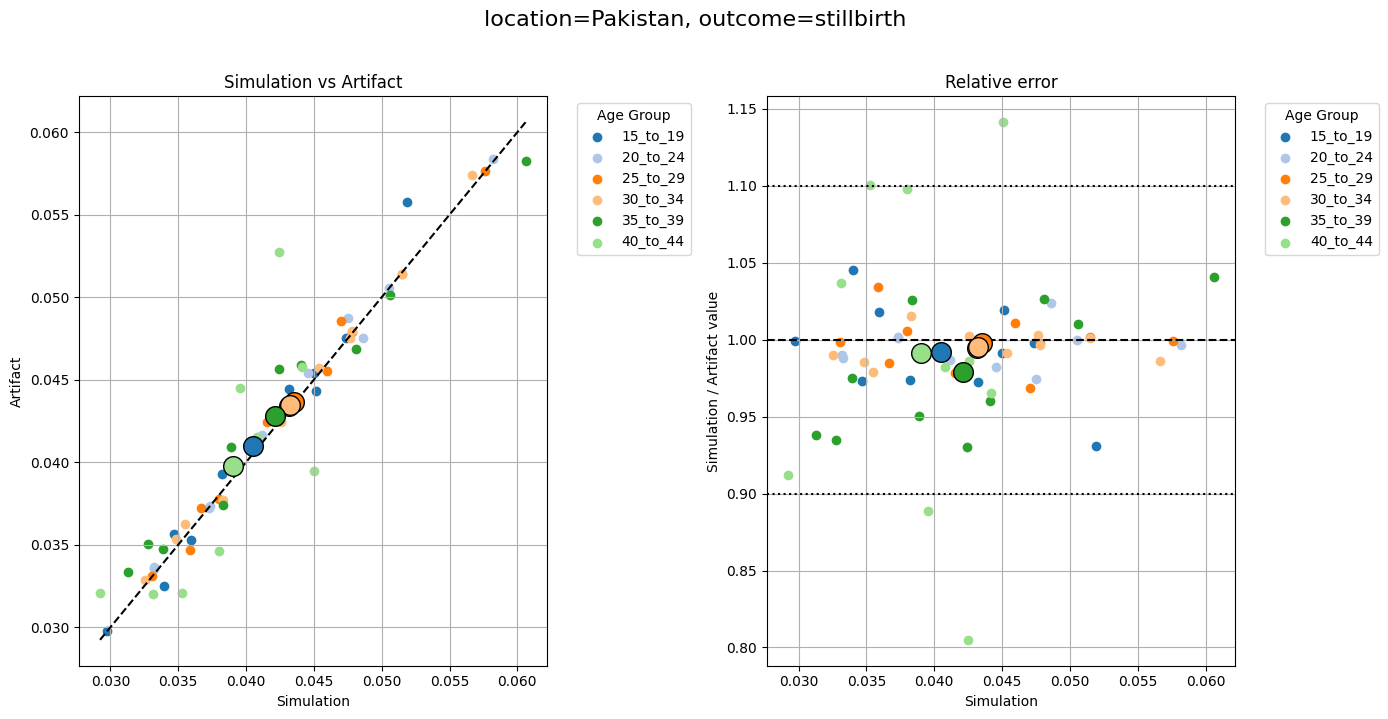

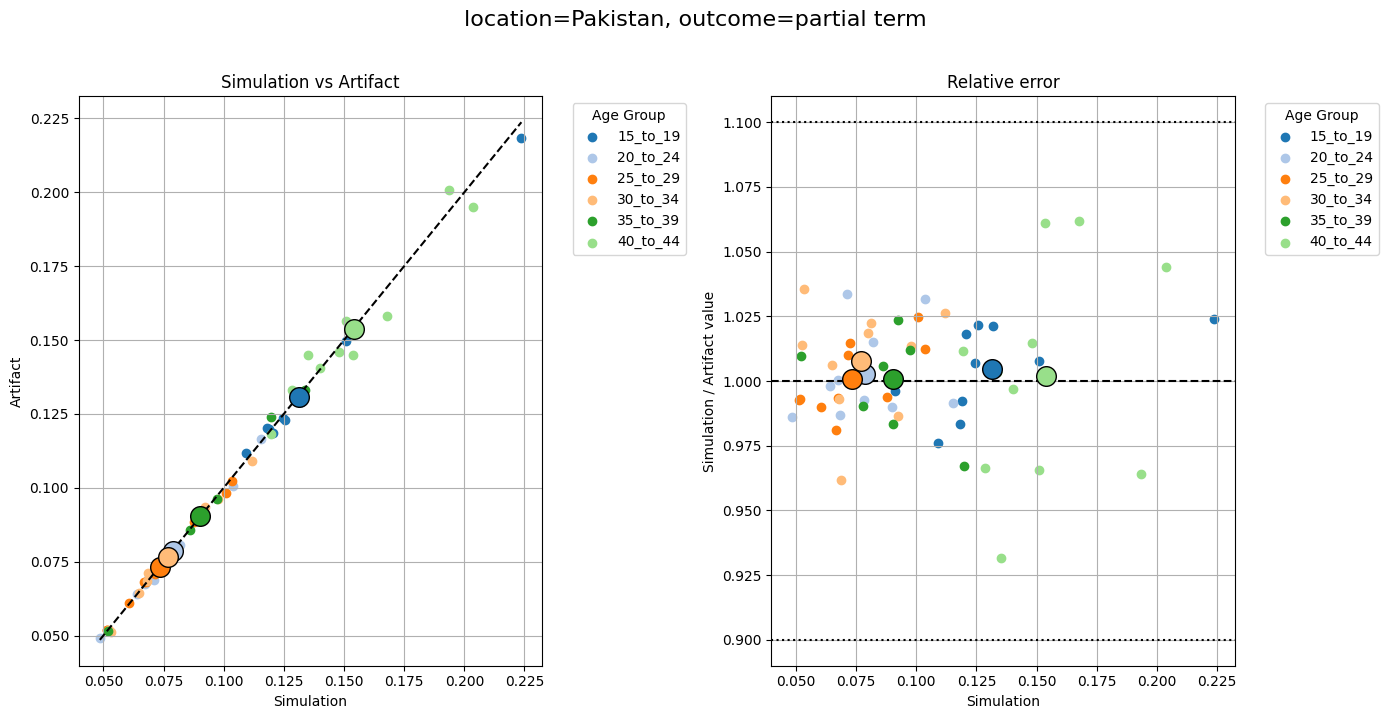

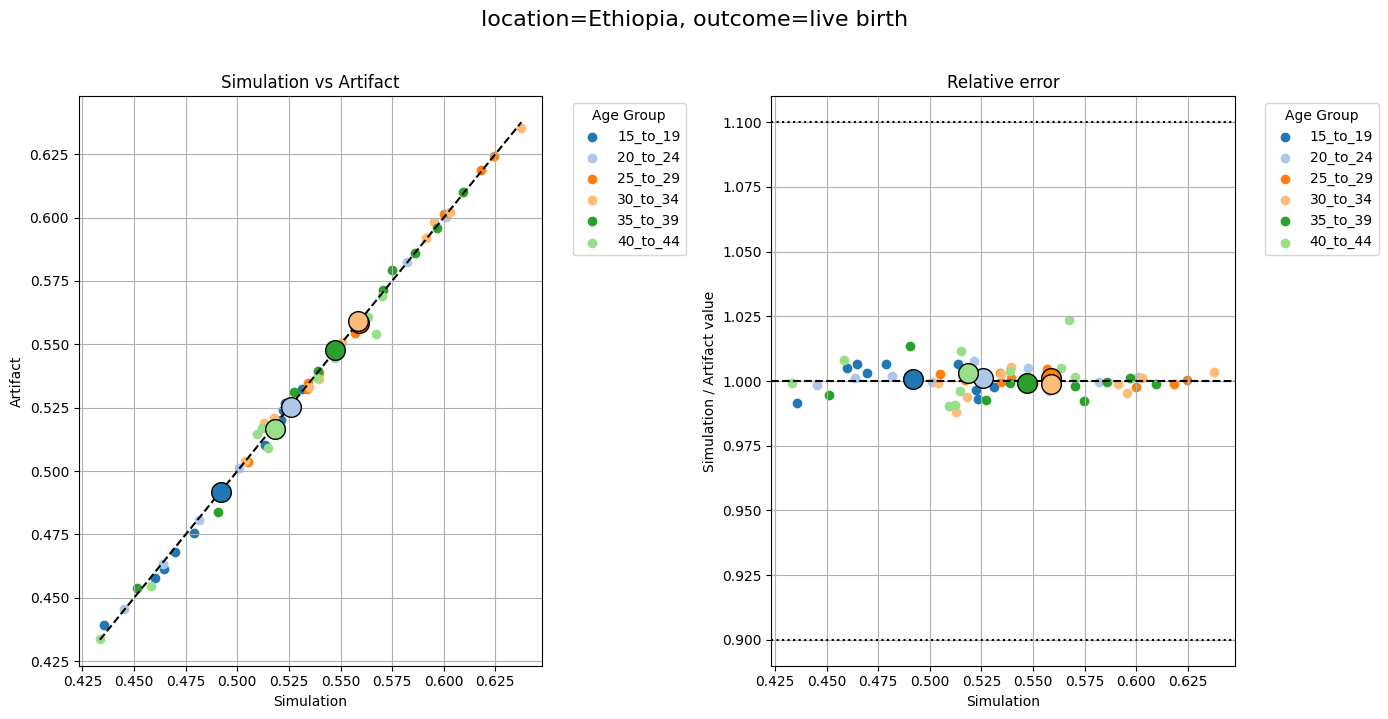

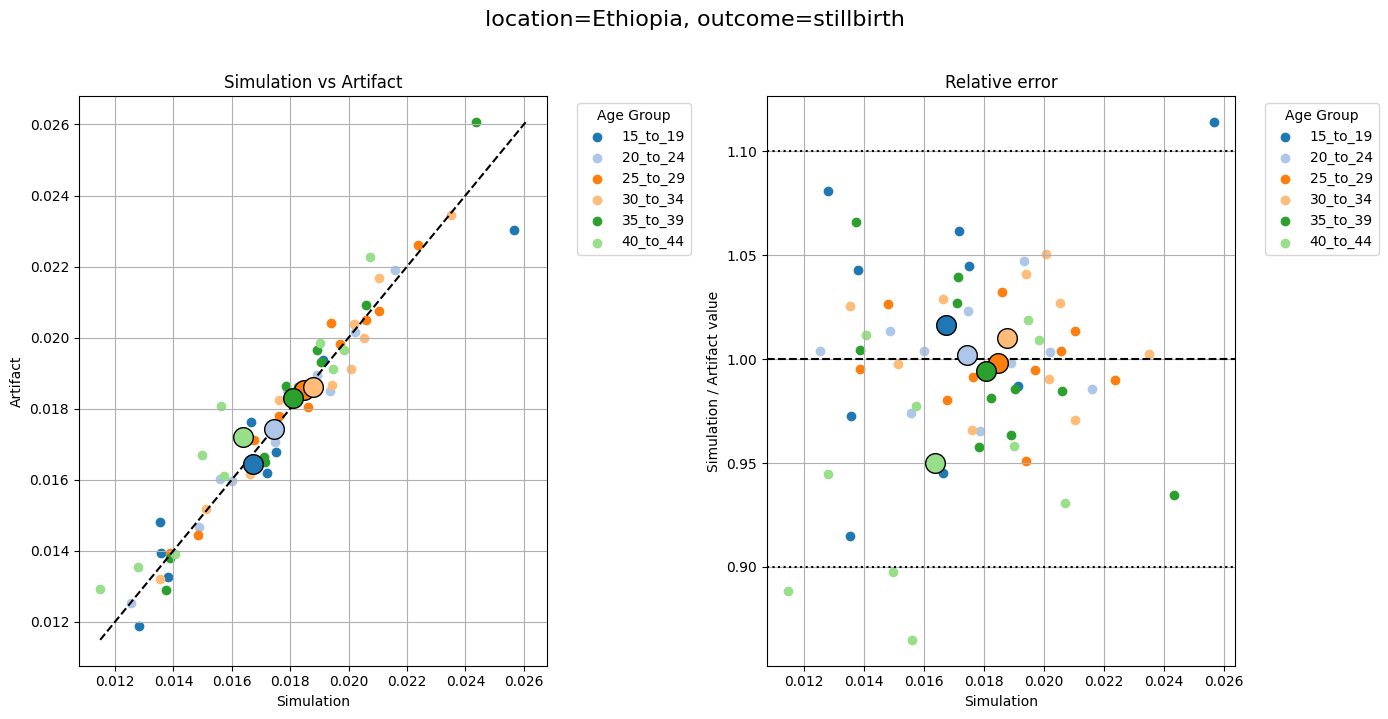

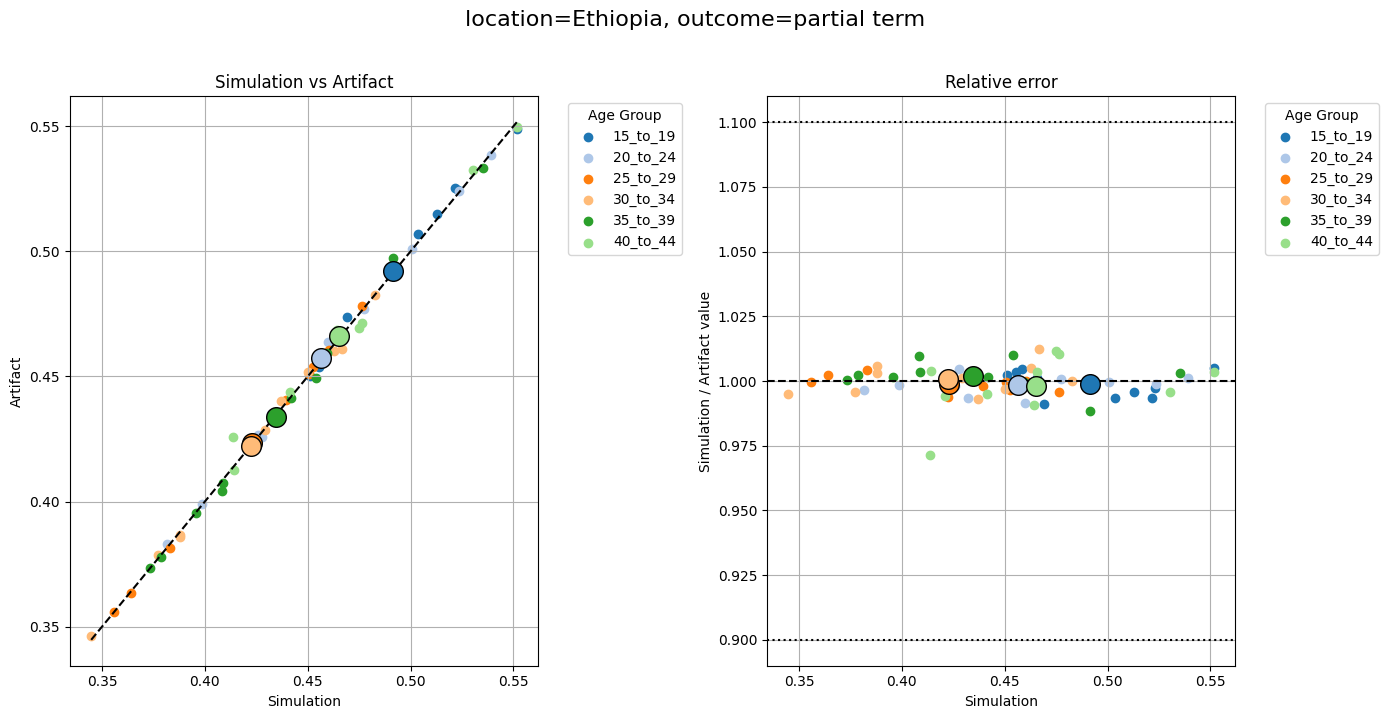

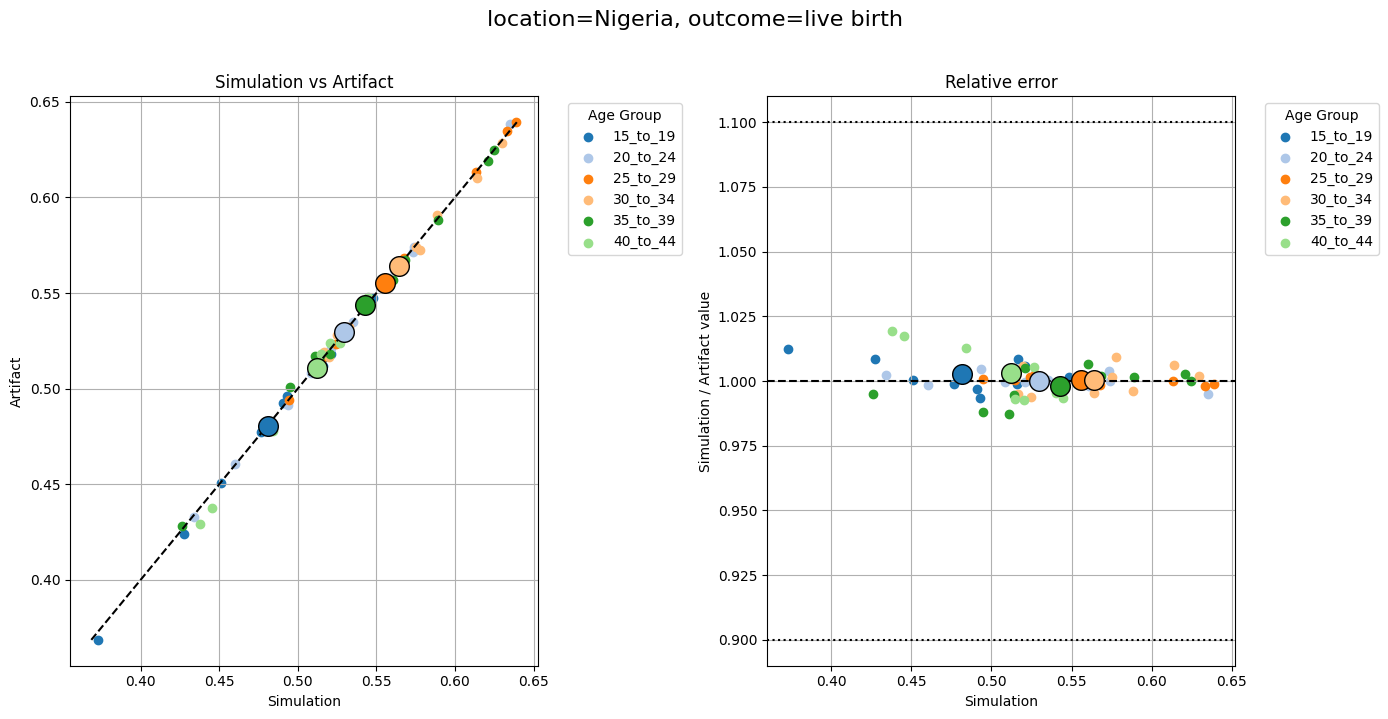

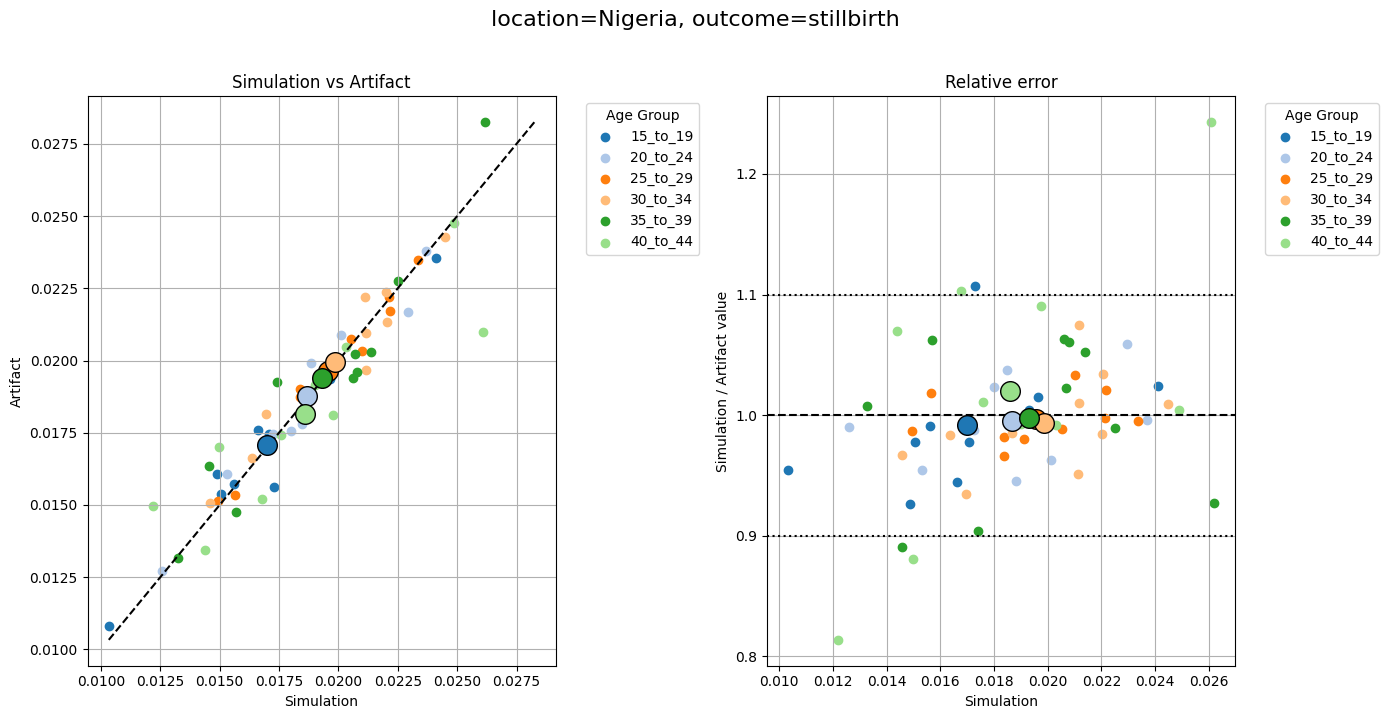

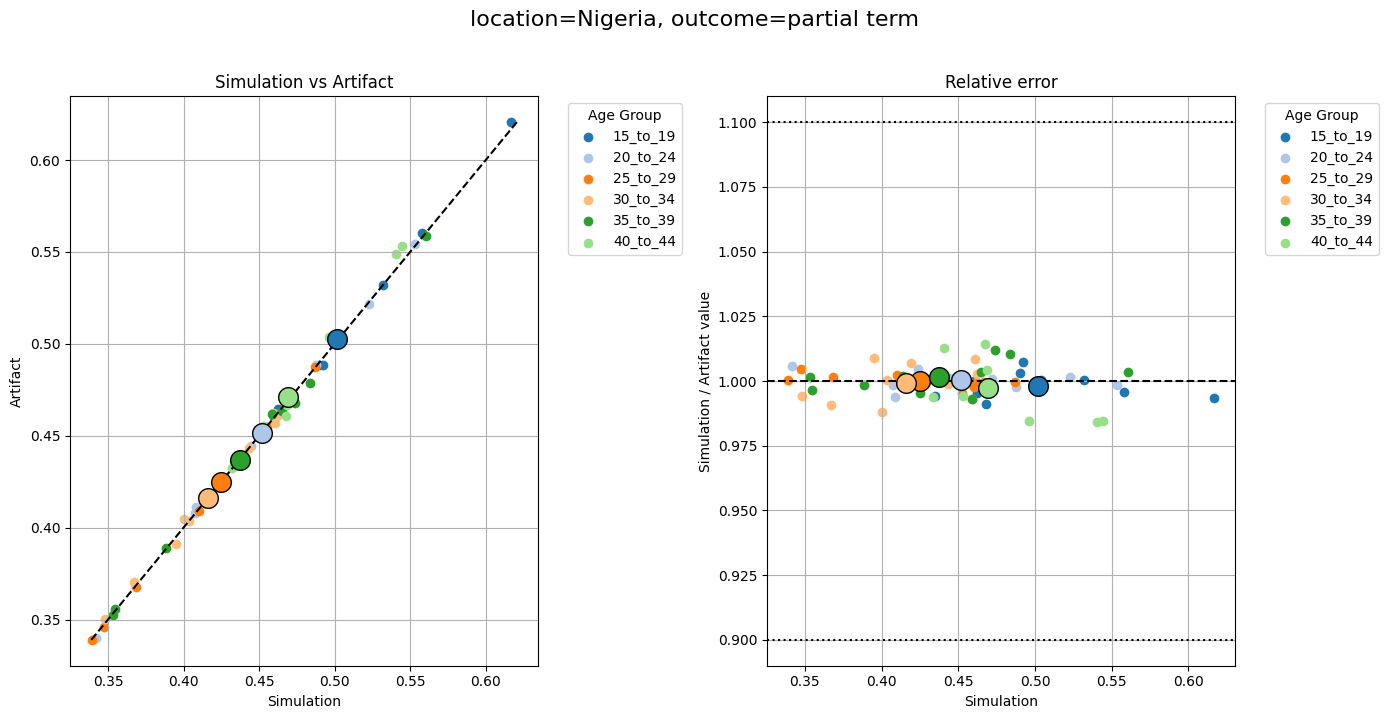

In [50]:
for location in locations:
    for outcome in ['live_birth', 'stillbirth', 'partial_term']:
        plot_quantitative_comparison(
            outcome_fractions,
            artifact_birth_outcomes_prepped,
            filters={
                'location': location,
                'outcome': outcome,
            }
        )
# Still look good

## Verify antenatal care (ANC) coverage vs artifact

In [51]:
# Not age-specific
births['partial_term'] = births.pregnancy_outcome == 'partial_term'

anc_groupby_cols = [c for c in groupby_cols if c != 'age_group'] + ['partial_term']
anc_coverage_simulation = (
       (
       births.groupby(anc_groupby_cols + ['anc_coverage'])['value'].sum()
              / births.groupby(anc_groupby_cols)['value'].sum()
       )
       #.unstack('input_draw')
       #.pipe(describe_rowwise)
       .reset_index()
)
anc_coverage_simulation

location  input_draw  partial_term                         anc_coverage  \
0    Ethiopia          22         False  first_trimester_and_later_pregnancy   
1    Ethiopia          22         False                 first_trimester_only   
2    Ethiopia          22         False                 later_pregnancy_only   
3    Ethiopia          22         False                                 none   
4    Ethiopia          22          True  first_trimester_and_later_pregnancy   
..        ...         ...           ...                                  ...   
235  Pakistan         244         False                                 none   
236  Pakistan         244          True  first_trimester_and_later_pregnancy   
237  Pakistan         244          True                 first_trimester_only   
238  Pakistan         244          True                 later_pregnancy_only   
239  Pakistan         244          True                                 none   

        value  
0    0.398772  
1    0.045684  
2    0.278322  
3    0.277222  
4    0.000000  
..        ...  
235  0.072761  
236  0.000000  
237  0.662692  
238  0.000000  
239  0.337308  

[240 rows x 5 columns]

In [52]:
anc1_coverage_artifact = (
    read_artifact('covariate.antenatal_care_1_visit_coverage_proportion.estimate')
)
anc4_coverage_artifact = (
    read_artifact('covariate.antenatal_care_4_visits_coverage_proportion.estimate')
)
ancfirst_coverage_artifact = (
    read_artifact('covariate.antenatal_care_first_trimester_visit_coverage_proportion.estimate')
)
anc1_coverage_artifact

draw_22   draw_60   draw_71   draw_79  \
location year_start year_end                                           
Pakistan 2023       2024      0.924081  0.924081  0.924081  0.924081   
Ethiopia 2023       2024      0.721476  0.752616  0.803045  0.847649   
Nigeria  2023       2024      0.713920  0.729363  0.754373  0.776495   

                              draw_115  draw_118  draw_146  draw_167  \
location year_start year_end                                           
Pakistan 2023       2024      0.924081  0.924081  0.924081  0.924081   
Ethiopia 2023       2024      0.714653  0.816801  0.701419  0.775057   
Nigeria  2023       2024      0.710536  0.761195  0.703973  0.740492   

                              draw_197  draw_244  
location year_start year_end                      
Pakistan 2023       2024      0.924081  0.924081  
Ethiopia 2023       2024      0.738209  0.751531  
Nigeria  2023       2024      0.722218  0.728825

In [53]:
# so let's check partial term pregnancies first

In [54]:
# make sure no partial term pregnancies attend anc in later pregnancy
assert anc_coverage_simulation.loc[(anc_coverage_simulation.partial_term)
                                   &(anc_coverage_simulation.anc_coverage.isin(['first_trimester_and_later_pregnancy',
                                                                                'later_pregnancy_only']))].value.sum() == 0, "Partial term pregnancies are attending later pregnancy ANC visits"

In [55]:
# now let's check that the rate of ANC visit for first trimester only matches artifact value for ANCfirst
anc_coverage_simulation_partial_term = anc_coverage_simulation[(anc_coverage_simulation.partial_term)
                                                               &(anc_coverage_simulation.anc_coverage == 'first_trimester_only')
                                                               ]
anc_coverage_simulation_partial_term = anc_coverage_simulation_partial_term.groupby('location')['value'].describe(percentiles=[0.025,0.975])
anc_coverage_simulation_partial_term

count      mean       std       min      2.5%       50%     97.5%  \
location                                                                      
Ethiopia   10.0  0.440190  0.009860  0.415542  0.419411  0.444292  0.449501   
Nigeria    10.0  0.320218  0.015612  0.290047  0.295084  0.316603  0.343326   
Pakistan   10.0  0.654999  0.021889  0.623256  0.623714  0.652697  0.687596   

               max  
location            
Ethiopia  0.450714  
Nigeria   0.344316  
Pakistan  0.690060

Text(0, 0.5, 'ANC Coverage')

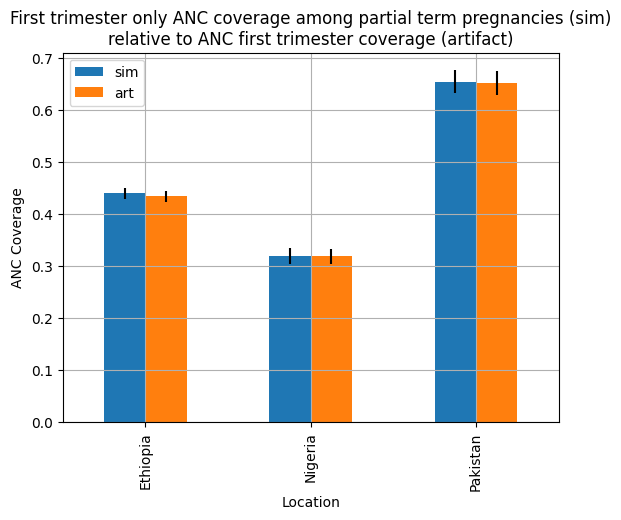

In [56]:
plot_data = anc_coverage_simulation_partial_term.merge(ancfirst_coverage_artifact.pipe(describe_rowwise), on='location', suffixes=('_sim', '_art'))

(
    plot_data[['mean_sim', 'mean_art']]
        .rename(columns=lambda c: c.replace('mean_', ''))
        .plot.bar(yerr=
            plot_data[['std_sim', 'std_art']]
                .rename(columns=lambda c: c.replace('std_', ''))
        )
)
plt.grid()
plt.title('First trimester only ANC coverage among partial term pregnancies (sim)\nrelative to ANC first trimester coverage (artifact)')
plt.xlabel('Location')
plt.ylabel('ANC Coverage')

# Looks good

In [57]:
# great, now let's move on to live and still birth outcomes
anc_coverage_simulation_births = anc_coverage_simulation[(anc_coverage_simulation.partial_term == False)]
anc_coverage_simulation_births = (anc_coverage_simulation_births.groupby([x for x in anc_coverage_simulation_births.columns 
                                                                          if x not in ['value', 'input_draw']])
                                                                          ['value'].describe(percentiles=[0.025,0.975]).reset_index())
anc_coverage_simulation_births

location  partial_term                         anc_coverage  count  \
0   Ethiopia         False  first_trimester_and_later_pregnancy   10.0   
1   Ethiopia         False                 first_trimester_only   10.0   
2   Ethiopia         False                 later_pregnancy_only   10.0   
3   Ethiopia         False                                 none   10.0   
4    Nigeria         False  first_trimester_and_later_pregnancy   10.0   
5    Nigeria         False                 first_trimester_only   10.0   
6    Nigeria         False                 later_pregnancy_only   10.0   
7    Nigeria         False                                 none   10.0   
8   Pakistan         False  first_trimester_and_later_pregnancy   10.0   
9   Pakistan         False                 first_trimester_only   10.0   
10  Pakistan         False                 later_pregnancy_only   10.0   
11  Pakistan         False                                 none   10.0   

        mean       std       min      2.5%       50%     97.5%       max  
0   0.421443  0.028726  0.372894  0.374353  0.432953  0.449213  0.450032  
1   0.017651  0.028961  0.000000  0.000000  0.000000  0.067145  0.068563  
2   0.323806  0.049443  0.252440  0.256651  0.317548  0.395543  0.401475  
3   0.237100  0.046711  0.153632  0.160337  0.246761  0.294136  0.297528  
4   0.320134  0.015124  0.292048  0.296558  0.315334  0.343133  0.344386  
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
6   0.414920  0.035937  0.370085  0.370708  0.417250  0.468189  0.469831  
7   0.264946  0.023425  0.223156  0.226523  0.269008  0.293797  0.295384  
8   0.512541  0.038919  0.456226  0.457366  0.518689  0.565939  0.570953  
9   0.141407  0.045189  0.092085  0.093061  0.132659  0.225300  0.234143  
10  0.273280  0.022271  0.236930  0.238185  0.279025  0.301157  0.303240  
11  0.072773  0.000092  0.072638  0.072650  0.072765  0.072920  0.072933

In [58]:
first_trimester_and_later_pregnancy_target = np.minimum(anc4_coverage_artifact, ancfirst_coverage_artifact)
first_trimester_and_later_pregnancy_target['anc_coverage'] = 'first_trimester_and_later_pregnancy'
first_trimester_only_target = ancfirst_coverage_artifact - first_trimester_and_later_pregnancy_target
first_trimester_only_target['anc_coverage'] = 'first_trimester_only'
later_pregnancy_only_target = anc1_coverage_artifact - ancfirst_coverage_artifact
later_pregnancy_only_target['anc_coverage'] = 'later_pregnancy_only'
none_target = 1 - anc1_coverage_artifact
none_target['anc_coverage'] = 'none'
target_data = pd.concat([first_trimester_and_later_pregnancy_target,
                          first_trimester_only_target,
                          later_pregnancy_only_target,
                          none_target]).reset_index()
target_data = (target_data.set_index([x for x in target_data.columns if 'draw' not in x])
               .pipe(describe_rowwise)
               .reset_index())
target_data

location  year_start  year_end                         anc_coverage  \
0   Pakistan        2023      2024  first_trimester_and_later_pregnancy   
1   Ethiopia        2023      2024  first_trimester_and_later_pregnancy   
2    Nigeria        2023      2024  first_trimester_and_later_pregnancy   
3   Pakistan        2023      2024                 first_trimester_only   
4   Ethiopia        2023      2024                 first_trimester_only   
5    Nigeria        2023      2024                 first_trimester_only   
6   Pakistan        2023      2024                 later_pregnancy_only   
7   Ethiopia        2023      2024                 later_pregnancy_only   
8    Nigeria        2023      2024                 later_pregnancy_only   
9   Pakistan        2023      2024                                 none   
10  Ethiopia        2023      2024                                 none   
11   Nigeria        2023      2024                                 none   

    count      mean       std       min      2.5%       50%     97.5%  \
0    10.0  0.512125  0.039216  0.455287  0.456545  0.517997  0.565642   
1    10.0  0.416892  0.028684  0.367275  0.369376  0.429638  0.444441   
2    10.0  0.319203  0.014138  0.292091  0.296565  0.315482  0.340948   
3    10.0  0.140263  0.045718  0.089994  0.091152  0.131373  0.225366   
4    10.0  0.017468  0.028638  0.000000  0.000000  0.000000  0.066477   
5    10.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6    10.0  0.271693  0.023203  0.234627  0.235853  0.277716  0.301458   
7    10.0  0.327885  0.050445  0.255709  0.259955  0.320240  0.402112   
8    10.0  0.414935  0.034963  0.371559  0.372210  0.415812  0.467542   
9    10.0  0.075919  0.000000  0.075919  0.075919  0.075919  0.075919   
10   10.0  0.237754  0.047739  0.152351  0.159292  0.247926  0.295603   
11   10.0  0.265861  0.023676  0.223505  0.226948  0.270906  0.294551   

         max  
0   0.570510  
1   0.445711  
2   0.342361  
3   0.234167  
4   0.068102  
5   0.000000  
6   0.303440  
7   0.408119  
8   0.469104  
9   0.075919  
10  0.298581  
11  0.296027

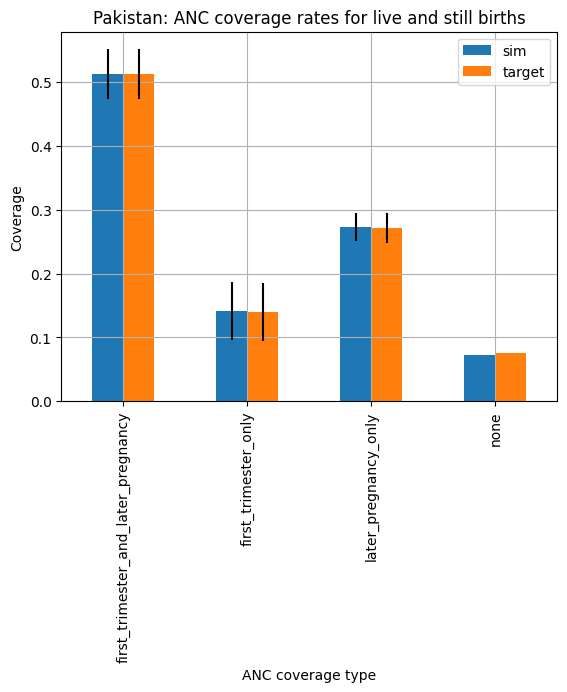

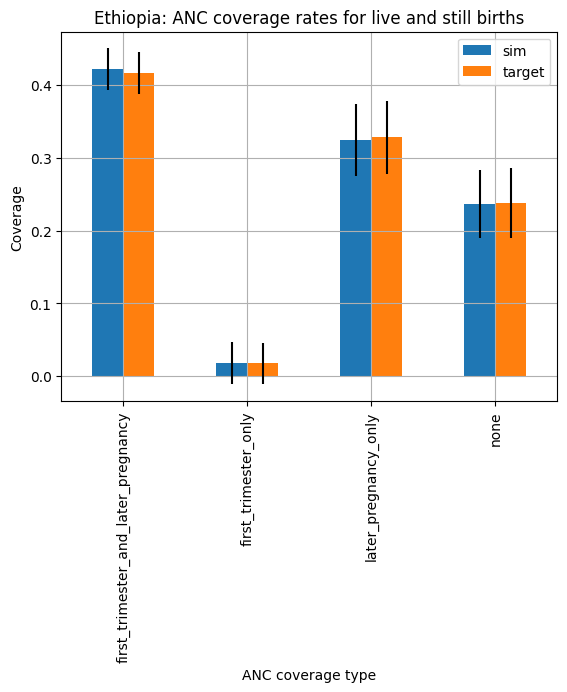

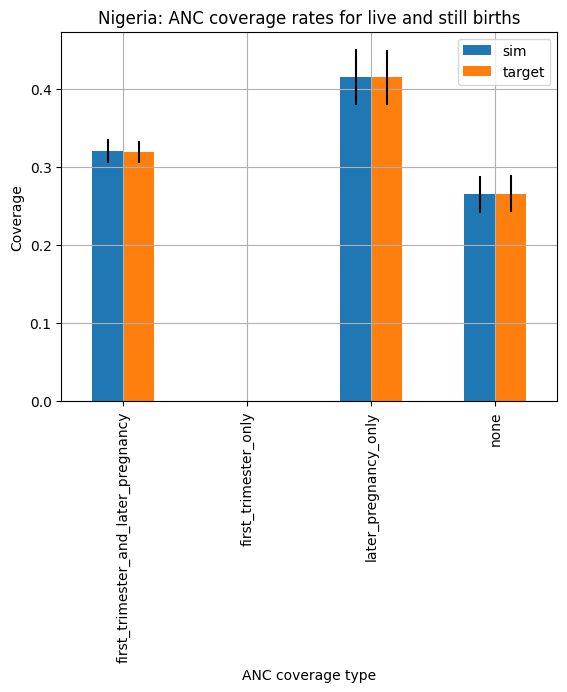

In [59]:
plot_data = target_data.merge(anc_coverage_simulation_births, on=['location','anc_coverage'], suffixes=('_target', '_sim')) 
plot_data = plot_data.set_index('anc_coverage')
for location in locations:
    (
        plot_data.loc[plot_data.location==location][['mean_sim', 'mean_target']]
            .rename(columns=lambda c: c.replace('mean_', ''))
            .plot.bar(yerr=
                plot_data.loc[plot_data.location==location][['std_sim', 'std_target']]
                    .rename(columns=lambda c: c.replace('std_', ''))
            )
    )
    plt.grid()
    plt.title(f'{location}: ANC coverage rates for live and still births')
    plt.xlabel('ANC coverage type')
    plt.ylabel('Coverage')

    # looks great!

## Verify ultrasound coverage vs docs

In [60]:
assert births[(births.anc_coverage == 'none') & (births.ultrasound_type != 'no_ultrasound')]['value'].sum() == 0, "There should be no ultrasound data for non-ANC births"

# Not age-specific
ultrasound_groupby_cols = [c for c in groupby_cols if c != 'age_group']
ultrasound_coverage_sim = (
    (
        births[births.anc_coverage != 'none'].groupby(ultrasound_groupby_cols + ['ultrasound_type'])['value'].sum() /
            births[births.anc_coverage != 'none'].groupby(ultrasound_groupby_cols)['value'].sum()
    )
        .unstack('input_draw')
        .pipe(describe_rowwise)
        .reset_index()
)
ultrasound_coverage_sim = ultrasound_coverage_sim[(ultrasound_coverage_sim.ultrasound_type != 'no_ultrasound')]
ultrasound_coverage_sim

# looks good
# https://vivarium-research.readthedocs.io/en/latest/models/concept_models/vivarium_mncnh_portfolio/ai_ultrasound_module/module_document.html#id6
# Ethiopia 60.7%, Nigeria 58.7%, Pakistan 66.7%

location ultrasound_type  count      mean       std       min      2.5%  \
0  Ethiopia     AI_assisted   10.0  0.000000  0.000000  0.000000  0.000000   
2  Ethiopia        standard   10.0  0.607556  0.001007  0.605534  0.605764   
3   Nigeria     AI_assisted   10.0  0.000000  0.000000  0.000000  0.000000   
5   Nigeria        standard   10.0  0.586920  0.001369  0.584046  0.584435   
6  Pakistan     AI_assisted   10.0  0.000000  0.000000  0.000000  0.000000   
8  Pakistan        standard   10.0  0.667190  0.001251  0.665521  0.665554   

        50%     97.5%       max  
0  0.000000  0.000000  0.000000  
2  0.607953  0.608602  0.608643  
3  0.000000  0.000000  0.000000  
5  0.587128  0.588831  0.589146  
6  0.000000  0.000000  0.000000  
8  0.667294  0.668896  0.668962

In [61]:
# now let's make sure that that doesn't vary significantly by anc coverage type
    # (so far we are not modeling any differences here)
# Not age-specific
ultrasound_groupby_cols = [c for c in groupby_cols if c != 'age_group'] + ['anc_coverage']
ultrasound_coverage_sim = (
    (
        births[births.anc_coverage != 'none'].groupby(ultrasound_groupby_cols + ['ultrasound_type'])['value'].sum() /
            births[births.anc_coverage != 'none'].groupby(ultrasound_groupby_cols)['value'].sum()
    )
        .unstack('input_draw')
        .pipe(describe_rowwise)
        .reset_index()
)
ultrasound_coverage_sim = ultrasound_coverage_sim[(ultrasound_coverage_sim.ultrasound_type != 'no_ultrasound')]
ultrasound_coverage_sim
# looks great!

location                         anc_coverage ultrasound_type  count  \
0   Ethiopia  first_trimester_and_later_pregnancy     AI_assisted   10.0   
2   Ethiopia  first_trimester_and_later_pregnancy        standard   10.0   
3   Ethiopia                 first_trimester_only     AI_assisted   10.0   
5   Ethiopia                 first_trimester_only        standard   10.0   
6   Ethiopia                 later_pregnancy_only     AI_assisted   10.0   
8   Ethiopia                 later_pregnancy_only        standard   10.0   
9   Ethiopia                                 none     AI_assisted    0.0   
11  Ethiopia                                 none        standard    0.0   
12   Nigeria  first_trimester_and_later_pregnancy     AI_assisted   10.0   
14   Nigeria  first_trimester_and_later_pregnancy        standard   10.0   
15   Nigeria                 first_trimester_only     AI_assisted   10.0   
17   Nigeria                 first_trimester_only        standard   10.0   
18   Nigeria                 later_pregnancy_only     AI_assisted   10.0   
20   Nigeria                 later_pregnancy_only        standard   10.0   
21   Nigeria                                 none     AI_assisted    0.0   
23   Nigeria                                 none        standard    0.0   
24  Pakistan  first_trimester_and_later_pregnancy     AI_assisted   10.0   
26  Pakistan  first_trimester_and_later_pregnancy        standard   10.0   
27  Pakistan                 first_trimester_only     AI_assisted   10.0   
29  Pakistan                 first_trimester_only        standard   10.0   
30  Pakistan                 later_pregnancy_only     AI_assisted   10.0   
32  Pakistan                 later_pregnancy_only        standard   10.0   
33  Pakistan                                 none     AI_assisted    0.0   
35  Pakistan                                 none        standard    0.0   

        mean       std       min      2.5%       50%     97.5%       max  
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2   0.607709  0.002353  0.604653  0.604704  0.607272  0.611910  0.612589  
3   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
5   0.607148  0.001766  0.604414  0.604490  0.607144  0.609314  0.609325  
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
8   0.608069  0.002458  0.605505  0.605515  0.607425  0.611909  0.612028  
9        NaN       NaN       NaN       NaN       NaN       NaN       NaN  
11       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
14  0.586111  0.001327  0.583789  0.584095  0.585760  0.587829  0.587839  
15  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
17  0.587975  0.005072  0.580548  0.580819  0.589033  0.594494  0.594891  
18  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
20  0.586688  0.002176  0.583589  0.583650  0.586081  0.589832  0.589989  
21       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
23       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
24  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
26  0.666736  0.002512  0.663626  0.663630  0.667413  0.670779  0.671516  
27  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
29  0.667940  0.003331  0.662844  0.663195  0.667801  0.671933  0.671951  
30  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
32  0.667015  0.002826  0.662537  0.662746  0.667447  0.670629  0.670729  
33       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
35       NaN       NaN       NaN       NaN       NaN       NaN       NaN

## Verify azithromycin and misoprostol coverage vs artifact

In [62]:
assert births[(births.misoprostol_availability == True) & (births.anc_coverage == False)].value.sum() == 0, "Misoprostol coverage is non-zero for those without ANC"
assert births[(births.misoprostol_availability == True) & (births.delivery_facility_type != 'home')].value.sum() == 0, "Misoprostol coverage among non-home births"
assert births[(births.azithromycin_availability == True) & (births.delivery_facility_type.isin(['home', 'none']))].value.sum() == 0, "Azithromycin coverage among home births"

In [63]:
# Not age-specific, but is facility-type-specific
azithromycin_misoprostol_groupby_cols = [c for c in groupby_cols if c != 'age_group'] + ['delivery_facility_type']

azithromycin_misoprostol_coverage_simulation = []

for intervention in ['azithromycin', 'misoprostol']:
    intervention_coverage = (
        births[births[f'{intervention}_availability'] == True].groupby(azithromycin_misoprostol_groupby_cols)['value'].sum() /
        births.groupby(azithromycin_misoprostol_groupby_cols)['value'].sum()
    ).reset_index()
    intervention_coverage['intervention'] = intervention
    azithromycin_misoprostol_coverage_simulation.append(intervention_coverage)

azithromycin_misoprostol_coverage_simulation = pd.concat(azithromycin_misoprostol_coverage_simulation, ignore_index=True)
azithromycin_misoprostol_coverage_simulation

location  input_draw delivery_facility_type  value  intervention
0    Ethiopia          22                 BEmONC    0.0  azithromycin
1    Ethiopia          22                 CEmONC    0.0  azithromycin
2    Ethiopia          22                   home    0.0  azithromycin
3    Ethiopia          22                   none    0.0  azithromycin
4    Ethiopia          60                 BEmONC    0.0  azithromycin
..        ...         ...                    ...    ...           ...
235  Pakistan         197                   none    0.0   misoprostol
236  Pakistan         244                 BEmONC    0.0   misoprostol
237  Pakistan         244                 CEmONC    0.0   misoprostol
238  Pakistan         244                   home    0.0   misoprostol
239  Pakistan         244                   none    0.0   misoprostol

[240 rows x 5 columns]

In [64]:
# Simulation results contain a 'none' delivery facility type, this should never have any coverage
# Redundant to checks above but it doesn't hurt
assert azithromycin_misoprostol_coverage_simulation[azithromycin_misoprostol_coverage_simulation.delivery_facility_type == 'none'].value.sum() == 0
azithromycin_misoprostol_coverage_simulation = azithromycin_misoprostol_coverage_simulation[azithromycin_misoprostol_coverage_simulation.delivery_facility_type != 'none']

In [65]:
azithromycin_misoprostol_coverage_simulation_summaries = (
    azithromycin_misoprostol_coverage_simulation
        .groupby([x for x in azithromycin_misoprostol_coverage_simulation.columns if x not in ['value', 'input_draw']])
        ['value'].describe(percentiles=[0.025, 0.975])
)
azithromycin_misoprostol_coverage_simulation_summaries

count      mean       std  \
location delivery_facility_type intervention                              
Ethiopia BEmONC                 azithromycin   10.0  0.000000  0.000000   
                                misoprostol    10.0  0.000000  0.000000   
         CEmONC                 azithromycin   10.0  0.000000  0.000000   
                                misoprostol    10.0  0.000000  0.000000   
         home                   azithromycin   10.0  0.000000  0.000000   
                                misoprostol    10.0  0.000000  0.000000   
Nigeria  BEmONC                 azithromycin   10.0  0.000000  0.000000   
                                misoprostol    10.0  0.000000  0.000000   
         CEmONC                 azithromycin   10.0  0.000000  0.000000   
                                misoprostol    10.0  0.000000  0.000000   
         home                   azithromycin   10.0  0.000000  0.000000   
                                misoprostol    10.0  0.000000  0.000000   
Pakistan BEmONC                 azithromycin   10.0  0.000000  0.000000   
                                misoprostol    10.0  0.000000  0.000000   
         CEmONC                 azithromycin   10.0  0.204289  0.038085   
                                misoprostol    10.0  0.000000  0.000000   
         home                   azithromycin   10.0  0.000000  0.000000   
                                misoprostol    10.0  0.000000  0.000000   

                                                   min      2.5%       50%  \
location delivery_facility_type intervention                                 
Ethiopia BEmONC                 azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
         CEmONC                 azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
         home                   azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
Nigeria  BEmONC                 azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
         CEmONC                 azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
         home                   azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
Pakistan BEmONC                 azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
         CEmONC                 azithromycin  0.157969  0.159042  0.201455   
                                misoprostol   0.000000  0.000000  0.000000   
         home                   azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   

                                                 97.5%      max  
location delivery_facility_type intervention                     
Ethiopia BEmONC                 azithromycin  0.000000  0.00000  
                                misoprostol   0.000000  0.00000  
         CEmONC                 azithromycin  0.000000  0.00000  
                                misoprostol   0.000000  0.00000  
         home                   azithromycin  0.000000  0.00000  
                                misoprostol   0.000000  0.00000  
Nigeria  BEmONC                 azithromycin  0.000000  0.00000  
                                misoprostol   0.000000  0.00000  
         CEmONC                 azithromycin  0.000000  0.00000  
                                misoprostol   0.000000  0.00000  
         home                   azithromycin  0.000000  0.00000  
                                misoprostol   0.000000  0.00000  
Pakistan BEmONC                 azithromycin  0.000000  0.00

In [66]:
# NOTE: Only baseline coverage is in artifact
azithromycin_misoprostol_baseline_coverage_artifact = pd.concat([
    read_artifact(f'intervention.no_{intervention}_risk.probability_{intervention}_{delivery_facility.lower()}', filter_terms=['child_age_start==0'])
        .assign(intervention=intervention, delivery_facility_type=delivery_facility)
        .set_index(['intervention', 'delivery_facility_type'], append=True)
        .reset_index()
    for delivery_facility in ['BEmONC', 'CEmONC', 'home']
    for intervention in ['azithromycin', 'misoprostol']
], ignore_index=True)
azithromycin_misoprostol_baseline_coverage_artifact['scenario'] = 'baseline'
azithromycin_misoprostol_baseline_coverage_artifact

location     sex  age_start     age_end  year_start  year_end  \
0    Pakistan  Female   0.000000    0.019178      2023.0    2024.0   
1    Pakistan  Female   0.019178    0.076712      2023.0    2024.0   
2    Pakistan  Female   0.076712    0.500000      2023.0    2024.0   
3    Pakistan  Female   0.500000    1.000000      2023.0    2024.0   
4    Pakistan  Female   1.000000    2.000000      2023.0    2024.0   
..        ...     ...        ...         ...         ...       ...   
454   Nigeria    Male  90.000000   95.000000      2023.0    2024.0   
455   Nigeria    Male  95.000000  125.000000      2023.0    2024.0   
456  Pakistan     NaN        NaN         NaN         NaN       NaN   
457  Ethiopia     NaN        NaN         NaN         NaN       NaN   
458   Nigeria     NaN        NaN         NaN         NaN       NaN   

     intervention delivery_facility_type  draw_22  draw_60  draw_71  draw_79  \
0    azithromycin                 BEmONC      0.0      0.0      0.0      0.0   
1    azithromycin                 BEmONC      0.0      0.0      0.0      0.0   
2    azithromycin                 BEmONC      0.0      0.0      0.0      0.0   
3    azithromycin                 BEmONC      0.0      0.0      0.0      0.0   
4    azithromycin                 BEmONC      0.0      0.0      0.0      0.0   
..            ...                    ...      ...      ...      ...      ...   
454  azithromycin                   home      0.0      0.0      0.0      0.0   
455  azithromycin                   home      0.0      0.0      0.0      0.0   
456   misoprostol                   home      0.0      0.0      0.0      0.0   
457   misoprostol                   home      0.0      0.0      0.0      0.0   
458   misoprostol                   home      0.0      0.0      0.0      0.0   

     draw_115  draw_118  draw_146  draw_167  draw_197  draw_244  scenario  
0         0.0       0.0       0.0       0.0       0.0       0.0  baseline  
1         0.0       0.0       0.0       0.0       0.0       0.0  baseline  
2         0.0       0.0       0.0       0.0       0.0       0.0  baseline  
3         0.0       0.0       0.0       0.0       0.0       0.0  baseline  
4         0.0       0.0       0.0       0.0       0.0       0.0  baseline  
..        ...       ...       ...       ...       ...       ...       ...  
454       0.0       0.0       0.0       0.0       0.0       0.0  baseline  
455       0.0       0.0       0.0       0.0       0.0       0.0  baseline  
456       0.0       0.0       0.0       0.0       0.0       0.0  baseline  
457       0.0       0.0       0.0       0.0       0.0       0.0  baseline  
458       0.0       0.0       0.0       0.0       0.0       0.0  baseline  

[459 rows x 19 columns]

In [67]:
assert (
    azithromycin_misoprostol_baseline_coverage_artifact
        .groupby([c for c in azithromycin_misoprostol_baseline_coverage_artifact.columns if c in azithromycin_misoprostol_groupby_cols] + ['intervention'])
        [[f'draw_{draw}' for draw in draws]]
        .nunique().max().max()
) == 1, "Varying azithromycin or misoprostol coverage rates (by age or sex or year)"

In [68]:
azithromycin_misoprostol_baseline_coverage_artifact = (
    azithromycin_misoprostol_baseline_coverage_artifact
        .groupby([c for c in azithromycin_misoprostol_baseline_coverage_artifact.columns if c in azithromycin_misoprostol_groupby_cols] + ['intervention'])
        [[f'draw_{draw}' for draw in draws]]
        .first()
)
azithromycin_misoprostol_baseline_coverage_artifact

draw_22   draw_60   draw_71  \
location delivery_facility_type intervention                                 
Ethiopia BEmONC                 azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
         CEmONC                 azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
         home                   azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
Nigeria  BEmONC                 azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
         CEmONC                 azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
         home                   azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
Pakistan BEmONC                 azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
         CEmONC                 azithromycin  0.238745  0.246435  0.181109   
                                misoprostol   0.000000  0.000000  0.000000   
         home                   azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   

                                               draw_79  draw_115  draw_118  \
location delivery_facility_type intervention                                 
Ethiopia BEmONC                 azithromycin  0.000000   0.00000  0.000000   
                                misoprostol   0.000000   0.00000  0.000000   
         CEmONC                 azithromycin  0.000000   0.00000  0.000000   
                                misoprostol   0.000000   0.00000  0.000000   
         home                   azithromycin  0.000000   0.00000  0.000000   
                                misoprostol   0.000000   0.00000  0.000000   
Nigeria  BEmONC                 azithromycin  0.000000   0.00000  0.000000   
                                misoprostol   0.000000   0.00000  0.000000   
         CEmONC                 azithromycin  0.000000   0.00000  0.000000   
                                misoprostol   0.000000   0.00000  0.000000   
         home                   azithromycin  0.000000   0.00000  0.000000   
                                misoprostol   0.000000   0.00000  0.000000   
Pakistan BEmONC                 azithromycin  0.000000   0.00000  0.000000   
                                misoprostol   0.000000   0.00000  0.000000   
         CEmONC                 azithromycin  0.160041   0.25227  0.231346   
                                misoprostol   0.000000   0.00000  0.000000   
         home                   azithromycin  0.000000   0.00000  0.000000   
                                misoprostol   0.000000   0.00000  0.000000   

                                              draw_146  draw_167  draw_197  \
location delivery_facility_type intervention                                 
Ethiopia BEmONC                 azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
         CEmONC                 azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
         home                   azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
Nigeria  BEmONC                 azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
         CEmONC                 azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0

In [69]:
azithromycin_misoprostol_baseline_coverage_artifact_summaries = (
    azithromycin_misoprostol_baseline_coverage_artifact
        .pipe(describe_rowwise)
)
azithromycin_misoprostol_baseline_coverage_artifact_summaries

count      mean       std  \
location delivery_facility_type intervention                              
Ethiopia BEmONC                 azithromycin   10.0  0.000000  0.000000   
                                misoprostol    10.0  0.000000  0.000000   
         CEmONC                 azithromycin   10.0  0.000000  0.000000   
                                misoprostol    10.0  0.000000  0.000000   
         home                   azithromycin   10.0  0.000000  0.000000   
                                misoprostol    10.0  0.000000  0.000000   
Nigeria  BEmONC                 azithromycin   10.0  0.000000  0.000000   
                                misoprostol    10.0  0.000000  0.000000   
         CEmONC                 azithromycin   10.0  0.000000  0.000000   
                                misoprostol    10.0  0.000000  0.000000   
         home                   azithromycin   10.0  0.000000  0.000000   
                                misoprostol    10.0  0.000000  0.000000   
Pakistan BEmONC                 azithromycin   10.0  0.000000  0.000000   
                                misoprostol    10.0  0.000000  0.000000   
         CEmONC                 azithromycin   10.0  0.204461  0.037133   
                                misoprostol    10.0  0.000000  0.000000   
         home                   azithromycin   10.0  0.000000  0.000000   
                                misoprostol    10.0  0.000000  0.000000   

                                                   min      2.5%       50%  \
location delivery_facility_type intervention                                 
Ethiopia BEmONC                 azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
         CEmONC                 azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
         home                   azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
Nigeria  BEmONC                 azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
         CEmONC                 azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
         home                   azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
Pakistan BEmONC                 azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   
         CEmONC                 azithromycin  0.160041  0.160465  0.202096   
                                misoprostol   0.000000  0.000000  0.000000   
         home                   azithromycin  0.000000  0.000000  0.000000   
                                misoprostol   0.000000  0.000000  0.000000   

                                                 97.5%      max  
location delivery_facility_type intervention                     
Ethiopia BEmONC                 azithromycin  0.000000  0.00000  
                                misoprostol   0.000000  0.00000  
         CEmONC                 azithromycin  0.000000  0.00000  
                                misoprostol   0.000000  0.00000  
         home                   azithromycin  0.000000  0.00000  
                                misoprostol   0.000000  0.00000  
Nigeria  BEmONC                 azithromycin  0.000000  0.00000  
                                misoprostol   0.000000  0.00000  
         CEmONC                 azithromycin  0.000000  0.00000  
                                misoprostol   0.000000  0.00000  
         home                   azithromycin  0.000000  0.00000  
                                misoprostol   0.000000  0.00000  
Pakistan BEmONC                 azithromycin  0.000000  0.00

azithromycin coverage is 0 at BEmONC in Pakistan


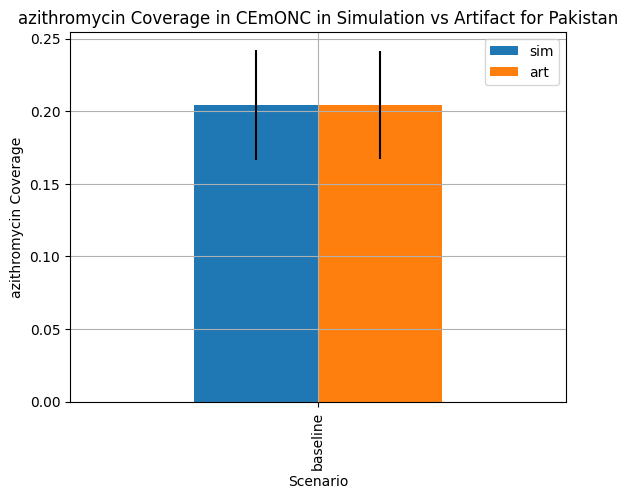

azithromycin coverage is 0 at home in Pakistan
azithromycin coverage is 0 at BEmONC in Ethiopia
azithromycin coverage is 0 at CEmONC in Ethiopia
azithromycin coverage is 0 at home in Ethiopia
azithromycin coverage is 0 at BEmONC in Nigeria
azithromycin coverage is 0 at CEmONC in Nigeria
azithromycin coverage is 0 at home in Nigeria
misoprostol coverage is 0 at BEmONC in Pakistan
misoprostol coverage is 0 at CEmONC in Pakistan
misoprostol coverage is 0 at home in Pakistan
misoprostol coverage is 0 at BEmONC in Ethiopia
misoprostol coverage is 0 at CEmONC in Ethiopia
misoprostol coverage is 0 at home in Ethiopia
misoprostol coverage is 0 at BEmONC in Nigeria
misoprostol coverage is 0 at CEmONC in Nigeria
misoprostol coverage is 0 at home in Nigeria


In [70]:
all_intervention_plot_data = (
    azithromycin_misoprostol_coverage_simulation_summaries.join(azithromycin_misoprostol_baseline_coverage_artifact_summaries, lsuffix='_sim', rsuffix='_art')
).reset_index()
assert len(all_intervention_plot_data) == len(azithromycin_misoprostol_coverage_simulation_summaries) == len(azithromycin_misoprostol_baseline_coverage_artifact_summaries)

for intervention in ['azithromycin', 'misoprostol']:
    for location in locations:
        for delivery_facility_type in ['BEmONC', 'CEmONC', 'home']:
            try:
                plot_data = all_intervention_plot_data[
                    (all_intervention_plot_data.location == location) &
                    (all_intervention_plot_data.delivery_facility_type == delivery_facility_type) &
                    (all_intervention_plot_data.intervention == intervention)
                ].drop(columns=["location", "delivery_facility_type", "intervention"]).assign(scenario='baseline').set_index('scenario')
            except KeyError:
                continue

            # If coverage should be zero, we can check that exactly (without a plot)
            if (plot_data['max_art'] == 0).all():
                assert (plot_data['max_sim'] == 0).all()
                print(f'{intervention} coverage is 0 at {delivery_facility_type} in {location}')
                continue

            (
                plot_data[['mean_sim', 'mean_art']]
                    .rename(columns=lambda c: c.replace('mean_', ''))
                    .plot.bar(yerr=
                        plot_data[['std_sim', 'std_art']]
                            .rename(columns=lambda c: c.replace('std_', ''))
                    )
            )
            plt.grid()
            plt.title(f'{intervention} Coverage in {delivery_facility_type} in Simulation vs Artifact for {location}')
            plt.xlabel('Scenario')
            plt.ylabel(f'{intervention} Coverage')
            plt.show()

# looks good

## Verify azithromycin and misoprostol coverage and RRs vs docs


In [71]:
births_all_scenarios = read_results('anc_other', baseline_only=False)
births_all_scenarios

acs_availability  acs_eligibility age_group  \
0                   False            False  10_to_14   
1                   False            False  10_to_14   
2                   False            False  10_to_14   
3                   False            False  10_to_14   
4                   False            False  10_to_14   
...                   ...              ...       ...   
4976635              True             True   95_plus   
4976636              True             True   95_plus   
4976637              True             True   95_plus   
4976638              True             True   95_plus   
4976639              True             True   95_plus   

                                anc_coverage  azithromycin_availability  \
0        first_trimester_and_later_pregnancy                      False   
1        first_trimester_and_later_pregnancy                      False   
2        first_trimester_and_later_pregnancy                      False   
3        first_trimester_and_later_pregnancy                      False   
4        first_trimester_and_later_pregnancy                      False   
...                                      ...                        ...   
4976635                                 none                       True   
4976636                                 none                       True   
4976637                                 none                       True   
4976638                                 none                       True   
4976639                                 none                       True   

         believed_preterm delivery_facility_type  misoprostol_availability  \
0                   False                 BEmONC                     False   
1                   False                 BEmONC                     False   
2                   False                 BEmONC                     False   
3                   False                 BEmONC                     False   
4                   False                 BEmONC                     False   
...                   ...                    ...                       ...   
4976635              True                   none                      True   
4976636              True                   none                      True   
4976637              True                   none                      True   
4976638              True                   none                      True   
4976639              True                   none                      True   

        pregnancy_outcome  preterm_birth ultrasound_type  scenario  \
0              live_birth          False     AI_assisted  baseline   
1              live_birth          False     AI_assisted  baseline   
2              live_birth          False     AI_assisted  baseline   
3              live_birth          False     AI_assisted  baseline   
4              live_birth          False     AI_assisted  baseline   
...                   ...            ...             ...       ...   
4976635        stillbirth           True        standard  baseline   
4976636        stillbirth           True        standard  baseline   
4976637        stillbirth           True        standard  baseline   
4976638        stillbirth           True        standard  baseline   
4976639        stillbirth           True        standard  baseline   

         input_draw  location  value  
0                22  Pakistan    0.0  
1                60  Pakistan    0.0  
2                71  Pakistan    0.0  
3                79  Pakistan    0.0  
4               115  Pakistan    0.0  
...             ...       ...    ...  
4976635         118   Nigeria    0.0  
4976636         146   Nigeria    0.0  
4976637         167   Nigeria    0.0  
4976638         197   Nigeria    0.0  
4976639         244   Nigeria    0.0  

[4976640 rows x 15 columns]

In [72]:
scenarios_run = list(births_all_scenarios.scenario.unique())
scenarios_run

['baseline']

In [73]:
incidence_all_scenarios = combine_count_results_by_cause('incidence', 'counts', baseline_only=False)
incidence_all_scenarios

age_group  azithromycin_availability delivery_facility_type  \
0       10_to_14                      False                 BEmONC   
1       10_to_14                      False                 BEmONC   
2       10_to_14                      False                 BEmONC   
3       10_to_14                      False                 BEmONC   
4       10_to_14                      False                 BEmONC   
...          ...                        ...                    ...   
103675   95_plus                       True                   none   
103676   95_plus                       True                   none   
103677   95_plus                       True                   none   
103678   95_plus                       True                   none   
103679   95_plus                       True                   none   

        misoprostol_availability pregnancy_outcome  scenario  input_draw  \
0                          False        live_birth  baseline          22   
1                          False        live_birth  baseline          60   
2                          False        live_birth  baseline          71   
3                          False        live_birth  baseline          79   
4                          False        live_birth  baseline         115   
...                          ...               ...       ...         ...   
103675                      True        stillbirth  baseline         118   
103676                      True        stillbirth  baseline         146   
103677                      True        stillbirth  baseline         167   
103678                      True        stillbirth  baseline         197   
103679                      True        stillbirth  baseline         244   

        location  value                                          cause  \
0       Pakistan   10.0  maternal_sepsis_and_other_maternal_infections   
1       Pakistan   17.0  maternal_sepsis_and_other_maternal_infections   
2       Pakistan   25.0  maternal_sepsis_and_other_maternal_infections   
3       Pakistan   24.0  maternal_sepsis_and_other_maternal_infections   
4       Pakistan   21.0  maternal_sepsis_and_other_maternal_infections   
...          ...    ...                                            ...   
103675   Nigeria    0.0                          postpartum_depression   
103676   Nigeria    0.0                          postpartum_depression   
103677   Nigeria    0.0                          postpartum_depression   
103678   Nigeria    0.0                          postpartum_depression   
103679   Nigeria    0.0                          postpartum_depression   

          measure  
0       incidence  
1       incidence  
2       incidence  
3       incidence  
4       incidence  
...           ...  
103675  incidence  
103676  incidence  
103677  incidence  
103678  incidence  
103679  incidence  

[103680 rows x 11 columns]

In [74]:
deaths_all_scenarios = (
    read_results('maternal_disorders_burden_observer_disorder_deaths', baseline_only=False)
        .rename(columns={'maternal_disorders_burden_observer_cause_of_death':'cause'})
)
deaths_all_scenarios

age_group  azithromycin_availability delivery_facility_type  \
0       10_to_14                      False                 BEmONC   
1       10_to_14                      False                 BEmONC   
2       10_to_14                      False                 BEmONC   
3       10_to_14                      False                 BEmONC   
4       10_to_14                      False                 BEmONC   
...          ...                        ...                    ...   
129595   95_plus                       True                   none   
129596   95_plus                       True                   none   
129597   95_plus                       True                   none   
129598   95_plus                       True                   none   
129599   95_plus                       True                   none   

                                         cause  misoprostol_availability  \
0       abortion_miscarriage_ectopic_pregnancy                     False   
1       abortion_miscarriage_ectopic_pregnancy                     False   
2       abortion_miscarriage_ectopic_pregnancy                     False   
3       abortion_miscarriage_ectopic_pregnancy                     False   
4       abortion_miscarriage_ectopic_pregnancy                     False   
...                                        ...                       ...   
129595             residual_maternal_disorders                      True   
129596             residual_maternal_disorders                      True   
129597             residual_maternal_disorders                      True   
129598             residual_maternal_disorders                      True   
129599             residual_maternal_disorders                      True   

       pregnancy_outcome  scenario  input_draw  location  value  
0             live_birth  baseline          22  Pakistan    0.0  
1             live_birth  baseline          60  Pakistan    0.0  
2             live_birth  baseline          71  Pakistan    0.0  
3             live_birth  baseline          79  Pakistan    0.0  
4             live_birth  baseline         115  Pakistan    0.0  
...                  ...       ...         ...       ...    ...  
129595        stillbirth  baseline         118   Nigeria    0.0  
129596        stillbirth  baseline         146   Nigeria    0.0  
129597        stillbirth  baseline         167   Nigeria    0.0  
129598        stillbirth  baseline         197   Nigeria    0.0  
129599        stillbirth  baseline         244   Nigeria    0.0  

[129600 rows x 10 columns]

In [75]:
azithromycin_coverage = (
    births_all_scenarios[births_all_scenarios.azithromycin_availability].groupby(['delivery_facility_type', 'scenario', 'location'])['value'].sum() /
    births_all_scenarios.groupby(['delivery_facility_type', 'scenario', 'location'])['value'].sum()
).dropna()
azithromycin_coverage

delivery_facility_type  scenario  location
BEmONC                  baseline  Ethiopia    0.000000
                                  Nigeria     0.000000
                                  Pakistan    0.000000
CEmONC                  baseline  Ethiopia    0.000000
                                  Nigeria     0.000000
                                  Pakistan    0.203012
home                    baseline  Ethiopia    0.000000
                                  Nigeria     0.000000
                                  Pakistan    0.000000
none                    baseline  Ethiopia    0.000000
                                  Nigeria     0.000000
                                  Pakistan    0.000000
Name: value, dtype: float64

In [76]:
assert (azithromycin_coverage.loc[slice('home', 'none')] == 0).all(), "azithromycin coverage outside IFD"
azithromycin_coverage = azithromycin_coverage.loc[slice('BEmONC', 'CEmONC')]

In [77]:
azithromycin_scaleup_scenarios = ['azithromycin_vv', 'azithromycin_scaleup', 'full_product_scaleup']

In [78]:
# https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/intrapartum/azithromycin_intervention.html#baseline-coverage-data
assert (azithromycin_coverage[
    ~azithromycin_coverage.index.get_level_values('scenario').isin(azithromycin_scaleup_scenarios)
    & (azithromycin_coverage.index.get_level_values('delivery_facility_type') != 'CEmONC')
    & (azithromycin_coverage.index.get_level_values('location') != 'Pakistan')
] == 0).all(), "baseline coverage outside Pakistan CEmONC"

In [79]:
# https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/intrapartum/azithromycin_intervention.html#baseline-coverage-data
# Not guaranteed to be exactly the same across scenarios because IFD (and therefore eligibility) can change
# But all scenarios should be close to target of 20.3, and they are
azithromycin_coverage[
    ~azithromycin_coverage.index.get_level_values('scenario').isin(azithromycin_scaleup_scenarios)
].loc[('CEmONC', slice(None), 'Pakistan')]

scenario
baseline    0.203012
Name: value, dtype: float64

In [80]:
if 'azithromycin_scaleup' in scenarios_run:
    # https://vivarium-research.readthedocs.io/en/latest/models/concept_models/vivarium_mncnh_portfolio/concept_model.html#id17
    assert (azithromycin_coverage.loc[(slice(None), 'azithromycin_scaleup')] == 1).all(), "azithromycin not fully scaled up in scale up scenario"

In [81]:
if 'azithromycin_vv' in scenarios_run:
    # Target is 50%, this looks close
    display(azithromycin_coverage.loc[(slice(None), 'azithromycin_vv')])

In [82]:
def calculate_incidence_and_deaths_rrs(intervention, confounders=(), baseline_coverage_confounders=()):
    print(intervention)
    for outcome, outcome_df in [('incidence', incidence_all_scenarios), ('deaths', deaths_all_scenarios)]:
        # TODO: Could compare these RRs at the draw level vs artifact
        print(outcome)

        if f'{intervention}_vv' in scenarios_run:
            print('Cross-simulant comparison: compare people with and without, in the V&V scenario')
            outcome_events_in_scenario = outcome_df.loc[
                (outcome_df.scenario == f'{intervention}_vv')
            ]
            births_in_scenario = births_all_scenarios.loc[
                (births_all_scenarios.scenario == f'{intervention}_vv') &
                (births_all_scenarios.pregnancy_outcome != 'partial_term')
            ]
            outcome_risk_by_intervention = (
                outcome_events_in_scenario.groupby([f'{intervention}_availability'] + list(confounders) + ['input_draw', 'location', 'cause'])['value'].sum()
                /
                births_in_scenario.groupby([f'{intervention}_availability'] + list(confounders) + ['input_draw', 'location'])['value'].sum()
            ).dropna()
            relative_risk = (outcome_risk_by_intervention.loc[(True,)] / outcome_risk_by_intervention.loc[(False,)]).replace(np.inf, np.nan).dropna()
            display(relative_risk.sort_values())
            display(relative_risk.groupby(['cause']).describe(percentiles=[0.025,0.975]))
        else:
            print(f'Cannot do cross-simulant comparison because {intervention} V&V scenario was not run')

        if f'{intervention}_scaleup' in scenarios_run:
            print('Cross-scenario comparison: compare those eligible, between baseline and scale-up scenario')
            outcome_events_by_scenario = outcome_df.loc[
                (outcome_df.scenario.isin(['baseline', f'{intervention}_scaleup']))
            ].groupby(['scenario'] + list(baseline_coverage_confounders) + ['input_draw', 'location', 'cause'])['value'].sum()
            births_by_scenario = births_all_scenarios.loc[
                (births_all_scenarios.scenario.isin(['baseline', f'{intervention}_scaleup'])) &
                (births_all_scenarios.pregnancy_outcome != 'partial_term')
            ].groupby(['scenario'] + list(baseline_coverage_confounders) + ['input_draw', 'location'])['value'].sum()
            assert (births_by_scenario.loc['baseline'] == births_by_scenario.loc[f'{intervention}_scaleup']).all(), "intervention scaleup changed number of births"
            births_for_coverage = births_all_scenarios.loc[
                (births_all_scenarios.scenario.isin(['baseline', f'{intervention}_scaleup'])) &
                (births_all_scenarios.pregnancy_outcome != 'partial_term')
            ]
            coverage_by_scenario = (
                births_for_coverage.loc[births_for_coverage[f'{intervention}_availability']]
                    .groupby(['scenario'] + list(baseline_coverage_confounders) + ['input_draw', 'location'])['value'].sum()
                /
                births_for_coverage
                    .groupby(['scenario'] + list(baseline_coverage_confounders) + ['input_draw', 'location'])['value'].sum()
            ).dropna()
            if (coverage_by_scenario.loc['baseline'] > 0).any():
                print('Scaled up from')
                display(coverage_by_scenario.loc['baseline'].sort_values())
                display(coverage_by_scenario.loc['baseline'].groupby(['location'] + list(baseline_coverage_confounders)).describe(percentiles=[0.025,0.975]))
            else:
                assert len(baseline_coverage_confounders) == 0

            assert (
                (coverage_by_scenario.loc[f'{intervention}_scaleup'] == coverage_by_scenario.loc['baseline']) |
                (coverage_by_scenario.loc[f'{intervention}_scaleup'] == 1)
            ).all()
            scaled_up_index = (coverage_by_scenario.loc[f'{intervention}_scaleup'] != coverage_by_scenario.loc['baseline']).pipe(lambda s: s.index[s])

            relative_risk = (
                outcome_events_by_scenario.loc[f'{intervention}_scaleup'].pipe(lambda s: s[s.index.droplevel('cause').isin(scaled_up_index)])
                /
                outcome_events_by_scenario.loc['baseline'].pipe(lambda s: s[s.index.droplevel('cause').isin(scaled_up_index)])
            ).replace(np.inf, np.nan).dropna()
            print('Observed RRs')
            display(relative_risk.sort_values())
            display(relative_risk.groupby(['cause'] + list(baseline_coverage_confounders)).describe(percentiles=[0.025,0.975]))
        else:
            print(f'Cannot do cross-scenario comparison because {intervention} scale-up scenario was not run')

In [83]:
# Target is 0.65 (95% CI 0.55-0.77) on maternal sepsis
# https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/intrapartum/azithromycin_intervention.html#id13

# Confounded by delivery facility -- it affects azithromycin availability, but is also correlated
# with ANC which increases hemoglobin (through IFA)
# Unfortunately having this confounder means we don't have good sample size/power for deaths
calculate_incidence_and_deaths_rrs(
    'azithromycin',
    confounders=['delivery_facility_type'],
    # Baseline coverage in Pakistan is specific to CEmONC
    baseline_coverage_confounders=['delivery_facility_type'],
)

# It seems like we are slightly underestimating the impact, based on the incidence results
# but deaths look better?
# Maybe just stochastic noise

azithromycin
incidence
Cannot do cross-simulant comparison because azithromycin V&V scenario was not run
Cannot do cross-scenario comparison because azithromycin scale-up scenario was not run
deaths
Cannot do cross-simulant comparison because azithromycin V&V scenario was not run
Cannot do cross-scenario comparison because azithromycin scale-up scenario was not run


In [84]:
# https://vivarium-research.readthedocs.io/en/latest/models/concept_models/vivarium_mncnh_portfolio/concept_model.html#id16
misoprostol_coverage = (
    births_all_scenarios[births_all_scenarios.misoprostol_availability].groupby(['scenario', 'delivery_facility_type', 'anc_coverage'])['value'].sum() /
    births_all_scenarios.groupby(['scenario', 'delivery_facility_type', 'anc_coverage'])['value'].sum()
).dropna()
assert (misoprostol_coverage[misoprostol_coverage.index.get_level_values('scenario') != 'misoprostol_vv'] == 0).all(), "misoprostol coverage outside of misoprostol scenario"
if 'misoprostol_vv' in scenarios_run:
    misoprostol_coverage = misoprostol_coverage.loc['misoprostol_vv']
    assert (misoprostol_coverage[misoprostol_coverage.index.get_level_values('delivery_facility_type') != 'home'] == 0).all(), "misoprostol coverage outside of home births"
    misoprostol_coverage = misoprostol_coverage.loc['home']
    assert (misoprostol_coverage[misoprostol_coverage.index.get_level_values('anc_coverage') == 'none'] == 0).all(), "misoprostol coverage among those not attending ANC"
    misoprostol_coverage = misoprostol_coverage[misoprostol_coverage.index.get_level_values('anc_coverage') != 'none']
    display(misoprostol_coverage)

# Should all be close to 50%, which they are

In [85]:
# Target is 0.61 (95% CI: 0.50 to 0.74) on maternal hemorrhage
# https://vivarium-research.readthedocs.io/en/latest/models/concept_models/vivarium_mncnh_portfolio/concept_model.html#id17

# Confounded by delivery facility -- misoprostol only available at home, but that is
# correlated with no ANC which decreases hemoglobin (through IFA)
calculate_incidence_and_deaths_rrs(
    'misoprostol',
    confounders=['delivery_facility_type']
)

# Seems relatively close, although again a bit off for incidence?

misoprostol
incidence
Cannot do cross-simulant comparison because misoprostol V&V scenario was not run
Cannot do cross-scenario comparison because misoprostol scale-up scenario was not run
deaths
Cannot do cross-simulant comparison because misoprostol V&V scenario was not run
Cannot do cross-scenario comparison because misoprostol scale-up scenario was not run
